In [1]:
!python -m venv my_env

In [92]:
import numpy as np
import pandas as pd
import datatable as dt
from datatable import f
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network  import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, det_curve
from sklearn.datasets import make_classification

import scipy
import statsmodels
import keras
import nltk
import torch
import tensorflow
import pipe
import pprint
import random

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

In [173]:
df = pd.read_csv('simulated_data.csv')
df.tail()

id diagnosis   area_mean  area_worst  compactness_mean  \
14272  92751         B  164.130895  164.130895          0.045051   
14273  92751         B  201.310953  201.310953          0.040230   
14274  92751         B  171.792439  171.792439          0.045287   
14275  92751         B  168.373681  168.373681          0.036249   
14276  92751         B  164.705799  164.705799          0.039615   

       compactness_worst  concave points_mean  concave points_worst  \
14272           0.045051                  0.0                   0.0   
14273           0.040230                  0.0                   0.0   
14274           0.045287                  0.0                   0.0   
14275           0.036249                  0.0                   0.0   
14276           0.039615                  0.0                   0.0   

       concavity_mean  concavity_worst  fractal_dimension_mean  \
14272             0.0              0.0                0.056146   
14273             0.0              0.0                0.057780   
14274             0.0              0.0                0.060658   
14275             0.0              0.0                0.058009   
14276             0.0              0.0                0.060972   

       fractal_dimension_worst  perimeter_mean  perimeter_worst  radius_mean  \
14272                 0.056146       45.892093        45.892093     7.789452   
14273                 0.057780       50.638020        50.638020     7.861976   
14274                 0.060658       46.727636        46.727636     7.306300   
14275                 0.058009       51.212123        51.212123     8.162515   
14276                 0.060972       45.776702        45.776702     7.811408   

       radius_worst  smoothness_mean  smoothness_worst  symmetry_mean  \
14272      7.789452         0.055194          0.055194       0.170003   
14273      7.861976         0.042708          0.042708       0.164168   
14274      7.306300         0.059848          0.059848       0.153404   
14275      8.162515         0.057474          0.057474       0.101048   
14276      7.811408         0.047629          0.047629       0.189983   

       symmetry_worst  texture_mean  texture_worst test_group  
14272        0.170003     24.873812      24.873812      train  
14273        0.164168     26.296062      26.296062      train  
14274        0.153404     25.429555      25.429555      train  
14275        0.101048     27.657507      27.657507      train  
14276        0.189983     23.555447      23.555447      train

In [174]:
columns_for_model = [col for col in df.columns.tolist() if '_mean' in col or col == 'bias_term']
X_train = df[df.test_group == 'train'][columns_for_model]
X_test = df[df.test_group == 'test'][columns_for_model]
y_train = df[df.test_group == 'train'].diagnosis
y_test = df[df.test_group == 'test'].diagnosis

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [179]:
base_model = MLPClassifier(random_state=55)

hidden_layer_size1 = round(len(columns_for_model)*2)
hidden_layer_size2 = round(len(columns_for_model)*1.75)
hidden_layer_size3 = round(len(columns_for_model)*1.5)
hidden_layer_size4 = round(len(columns_for_model)*1.2)
hidden_layer_size5 = round(len(columns_for_model)*3/4)
hidden_layer_size6 = round(len(columns_for_model)*2/3)
hidden_layer_size7 = round(len(columns_for_model)*0.5)

param_grid = {
    'hidden_layer_sizes': [(hidden_layer_size1, hidden_layer_size3),
                          (hidden_layer_size2, hidden_layer_size4),
                          (hidden_layer_size3, hidden_layer_size5),
                          (hidden_layer_size4, hidden_layer_size6),
                          (hidden_layer_size5, hidden_layer_size7)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'lbfgs'],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [100, 200, 300, 400, 500,]
}

grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(random_state=55), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'hidden_layer_sizes': [(20, 15), (18, 12), (15, 8),
                                                (12, 7), (8, 5)],
                         'learning_rate': ['constant', 'adaptive'],
                         'max_iter': [100, 200, 300, 400, 500],
                         'solver': ['adam', 'lbfgs']},
             scoring='accuracy')

In [180]:
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values('mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_fit_time', 'param_activation', 
    'param_hidden_layer_sizes', 'param_learning_rate', 'param_max_iter']]

mean_test_score  mean_fit_time param_activation param_hidden_layer_sizes  \
92          0.937785       3.943428             relu                   (8, 5)   
82          0.937785       3.981879             relu                   (8, 5)   
178         0.937612       9.226241             tanh                  (12, 7)   
168         0.937612       9.397610             tanh                  (12, 7)   
84          0.937523       4.084705             relu                   (8, 5)   
86          0.937523       4.453683             relu                   (8, 5)   
94          0.937523       4.272662             relu                   (8, 5)   
96          0.937523       4.518786             relu                   (8, 5)   
98          0.937523       5.222669             relu                   (8, 5)   
88          0.937523       4.198453             relu                   (8, 5)   
166         0.937087       8.491505             tanh                  (12, 7)   
176         0.937087       7.992270             tanh                  (12, 7)   
173         0.936649       1.568161             tanh                  (12, 7)   
163         0.936649       1.586252             tanh                  (12, 7)   
80          0.935773       2.838659             relu                   (8, 5)   
90          0.935773       3.059677             relu                   (8, 5)   
167         0.935597       2.905603             tanh                  (12, 7)   
177         0.935597       2.906952             tanh                  (12, 7)   
36          0.935510       6.355374             relu                 (18, 12)   
38          0.935510       7.104988             relu                 (18, 12)   
28          0.935510       6.275845             relu                 (18, 12)   
34          0.935510       6.182999             relu                 (18, 12)   
24          0.935510       5.812880             relu                 (18, 12)   
26          0.935510       5.842463             relu                 (18, 12)   
32          0.935072       6.966262             relu                 (18, 12)   
22          0.935072       5.430173             relu                 (18, 12)   
67          0.934986       3.187392             relu                  (12, 7)   
77          0.934986       3.028524             relu                  (12, 7)   
175         0.934898       2.175109             tanh                  (12, 7)   
165         0.934898       3.135327             tanh                  (12, 7)   
75          0.934724       2.692460             relu                  (12, 7)   
65          0.934724       3.460784             relu                  (12, 7)   
52          0.934635       4.555742             relu                  (15, 8)   
42          0.934635       5.269390             relu                  (15, 8)   
69          0.934286       3.753630             relu                  (12, 7)   
79          0.934286       4.341011             relu                  (12, 7)   
23          0.934286       2.274908             relu                 (18, 12)   
33          0.934286       2.928989             relu                 (18, 12)   
44          0.934023       5.621896             relu                  (15, 8)   
48          0.934023       5.421346             relu                  (15, 8)   
58          0.934023       6.947669             relu                  (15, 8)   
46          0.934023       5.208664             relu                  (15, 8)   
54          0.934023       6.912089             relu                  (15, 8)   
56          0.934023       6.718414             relu                  (15, 8)   
141         0.933673       1.696868             tanh                  (15, 8)   
151         0.933673       1.764367             tanh                  (15, 8)   
3           0.933672       3.854884             relu                 (20, 15)   
13          0.933672       3.514008             relu                 (20, 15)   
14          0.933498       6.508199 

In [181]:
results.groupby('param_hidden_layer_sizes', as_index=False).agg({'mean_test_score':'mean'})

param_hidden_layer_sizes  mean_test_score
0                   (8, 5)         0.928947
1                  (12, 7)         0.931420
2                  (15, 8)         0.930090
3                 (18, 12)         0.929455
4                 (20, 15)         0.927337

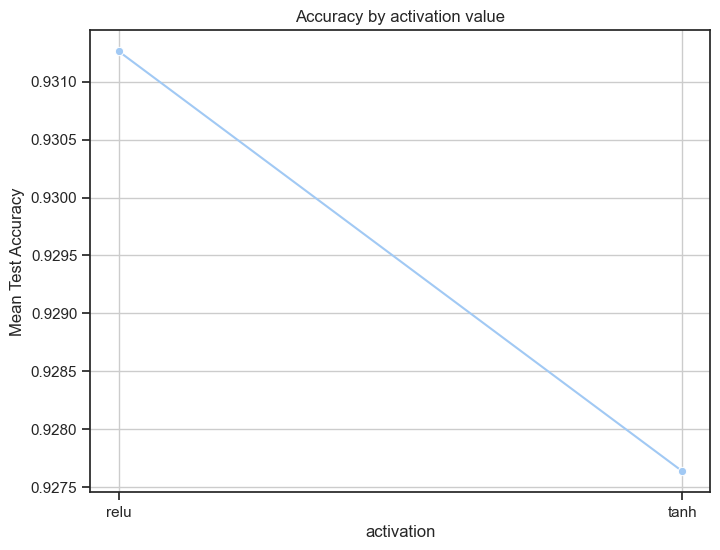

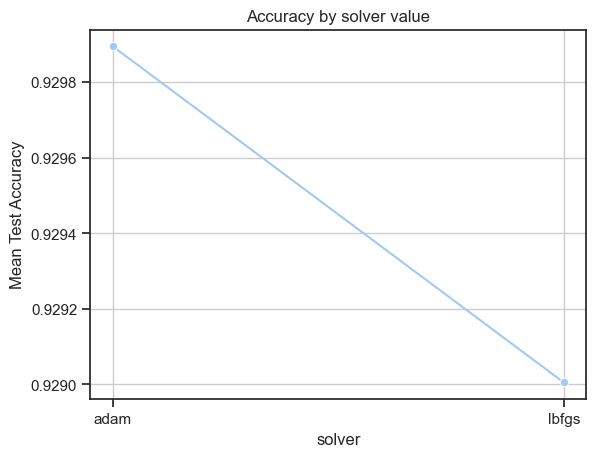

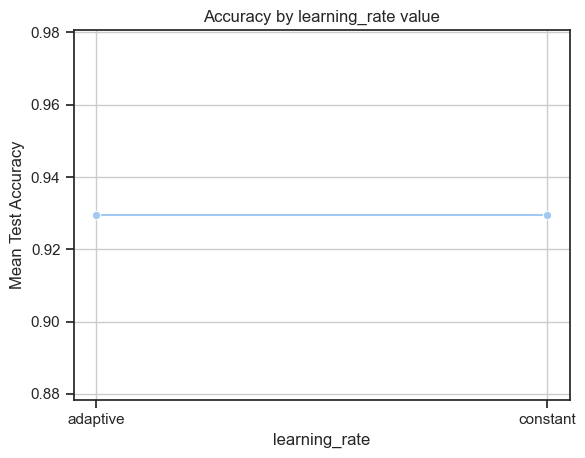

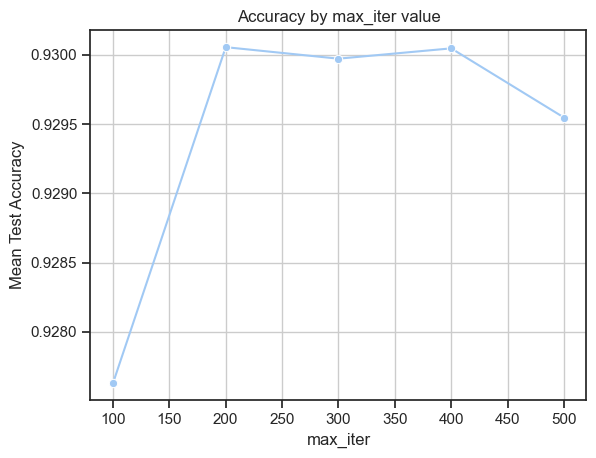

In [182]:
plt.figure(figsize=(8, 6))

for param in param_grid.keys():
    if param != 'hidden_layer_sizes':
        sns.lineplot(data=results.groupby('param_' + param, as_index=False).agg({'mean_test_score':'mean'}), 
                     x='param_' + param, y='mean_test_score', marker='o')
        plt.title('Accuracy by ' + param + ' value')
        plt.xlabel(param)
        plt.ylabel('Mean Test Accuracy')
        plt.grid(True)
        plt.show()

## Fiddling with hidden layer sizes

In [205]:
base_model = MLPClassifier(random_state=55, activation='relu', solver='adam', learning_rate='constant', max_iter=400)

hidden_layer_size1 = round(len(columns_for_model)*2/3)
hidden_layer_size2 = round(len(columns_for_model)*3/4)
hidden_layer_size3 = round(len(columns_for_model))
hidden_layer_size4 = round(len(columns_for_model)*1.2)
hidden_layer_size5 = round(len(columns_for_model)*1.5)
hidden_layer_size6 = round(len(columns_for_model)*2)
hidden_layer_size7 = round(len(columns_for_model)*2.5)
hidden_layer_size8 = round(len(columns_for_model)*5)
hidden_layer_size9 = round(len(columns_for_model)*10)

param_grid = {
    'hidden_layer_sizes': [
        (hidden_layer_size1),
        (hidden_layer_size2),
        (hidden_layer_size3),
        (hidden_layer_size4),
        (hidden_layer_size5),
        (hidden_layer_size6),
        (hidden_layer_size7),
        (hidden_layer_size8),
        (hidden_layer_size9),
    ],
}

grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=400, random_state=55),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [7, 8, 10, 12, 15, 20, 25, 50,
                                                100]},
             scoring='accuracy')

In [206]:
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values('mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_fit_time', 'param_hidden_layer_sizes']]

mean_test_score  mean_fit_time  param_hidden_layer_sizes
6         0.934986       6.199021                        25
1         0.934897       4.554490                         8
4         0.933673       5.154015                        15
8         0.932885       6.374934                       100
7         0.932885       7.818256                        50
5         0.931310       7.156269                        20
0         0.929299       4.919227                         7
3         0.924311       5.062338                        12
2         0.922384       2.857625                        10

In [207]:
base_model = MLPClassifier(random_state=55, activation='relu', solver='adam', learning_rate='constant', max_iter=400)

hidden_layer_size1 = round(len(columns_for_model)*2/3)
hidden_layer_size2 = round(len(columns_for_model)*3/4)
hidden_layer_size3 = round(len(columns_for_model))
hidden_layer_size4 = round(len(columns_for_model)*1.2)
hidden_layer_size5 = round(len(columns_for_model)*1.5)
hidden_layer_size6 = round(len(columns_for_model)*2)
hidden_layer_size7 = round(len(columns_for_model)*2.5)
hidden_layer_size8 = round(len(columns_for_model)*5)
hidden_layer_size9 = round(len(columns_for_model)*10)

param_grid = {
    'hidden_layer_sizes': [
        (hidden_layer_size3, hidden_layer_size1),
        (hidden_layer_size4, hidden_layer_size2),
        (hidden_layer_size5, hidden_layer_size3),
        (hidden_layer_size6, hidden_layer_size4),
        (hidden_layer_size7, hidden_layer_size5),
        (hidden_layer_size8, hidden_layer_size7),
        (hidden_layer_size9, hidden_layer_size8),
    ],
}

grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=400, random_state=55),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(10, 7), (12, 8), (15, 10),
                                                (20, 12), (25, 15), (50, 25),
                                                (100, 50)]},
             scoring='accuracy')

In [208]:
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values('mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_fit_time', 'param_hidden_layer_sizes']]

mean_test_score  mean_fit_time param_hidden_layer_sizes
2         0.936122       3.593108                 (15, 10)
4         0.935686       5.026473                 (25, 15)
3         0.933499       6.609799                 (20, 12)
5         0.933410       8.208231                 (50, 25)
0         0.933148       6.163274                  (10, 7)
6         0.929911      11.104099                (100, 50)
1         0.927812       4.983500                  (12, 8)

In [209]:
base_model = MLPClassifier(random_state=55, activation='relu', solver='adam', learning_rate='constant', max_iter=400)

hidden_layer_size1 = round(len(columns_for_model)*2/3)
hidden_layer_size2 = round(len(columns_for_model)*3/4)
hidden_layer_size3 = round(len(columns_for_model))
hidden_layer_size4 = round(len(columns_for_model)*1.2)
hidden_layer_size5 = round(len(columns_for_model)*1.5)
hidden_layer_size6 = round(len(columns_for_model)*2)
hidden_layer_size7 = round(len(columns_for_model)*2.5)
hidden_layer_size8 = round(len(columns_for_model)*5)
hidden_layer_size9 = round(len(columns_for_model)*10)

param_grid = {
    'hidden_layer_sizes': [
        (hidden_layer_size5, hidden_layer_size3, hidden_layer_size1),
        (hidden_layer_size6, hidden_layer_size4, hidden_layer_size2),
        (hidden_layer_size7, hidden_layer_size5, hidden_layer_size3),
        (hidden_layer_size7, hidden_layer_size6, hidden_layer_size4),
        (hidden_layer_size8, hidden_layer_size7, hidden_layer_size5),
        (hidden_layer_size9, hidden_layer_size8, hidden_layer_size7),
    ],
}

grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=400, random_state=55),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(15, 10, 7), (20, 12, 8),
                                                (25, 15, 10), (25, 20, 12),
                                                (50, 25, 15), (100, 50, 25)]},
             scoring='accuracy')

In [210]:
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values('mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_fit_time', 'param_hidden_layer_sizes']]

mean_test_score  mean_fit_time param_hidden_layer_sizes
2         0.939361       7.737377             (25, 15, 10)
0         0.933935       5.853665              (15, 10, 7)
4         0.931398       5.836670             (50, 25, 15)
1         0.930610       6.989672              (20, 12, 8)
3         0.930608       6.604020             (25, 20, 12)
5         0.926760       8.030010            (100, 50, 25)

In [211]:
base_model = MLPClassifier(random_state=55, activation='relu', solver='adam', learning_rate='constant', max_iter=400)

hidden_layer_size1 = round(len(columns_for_model)*2/3)
hidden_layer_size2 = round(len(columns_for_model)*3/4)
hidden_layer_size3 = round(len(columns_for_model))
hidden_layer_size4 = round(len(columns_for_model)*1.2)
hidden_layer_size5 = round(len(columns_for_model)*1.5)
hidden_layer_size6 = round(len(columns_for_model)*2)
hidden_layer_size7 = round(len(columns_for_model)*2.5)
hidden_layer_size8 = round(len(columns_for_model)*5)
hidden_layer_size9 = round(len(columns_for_model)*10)

param_grid = {
    'hidden_layer_sizes': [
        (hidden_layer_size7, hidden_layer_size5, hidden_layer_size3, hidden_layer_size1),
        (hidden_layer_size8, hidden_layer_size6, hidden_layer_size4, hidden_layer_size2),
        (hidden_layer_size8, hidden_layer_size7, hidden_layer_size5, hidden_layer_size3),
        (hidden_layer_size9, hidden_layer_size7, hidden_layer_size6, hidden_layer_size4),
    ],
}

grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=400, random_state=55),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(25, 15, 10, 7),
                                                (50, 20, 12, 8),
                                                (50, 25, 15, 10),
                                                (100, 25, 20, 12)]},
             scoring='accuracy')

In [212]:
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values('mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_fit_time', 'param_hidden_layer_sizes']]

mean_test_score  mean_fit_time param_hidden_layer_sizes
0         0.933498       8.924246          (25, 15, 10, 7)
2         0.932275       7.999965         (50, 25, 15, 10)
1         0.931399       5.902671          (50, 20, 12, 8)
3         0.927985       8.983533        (100, 25, 20, 12)

In [213]:
hidden_layer_size1 = round(len(columns_for_model)*2/3)
hidden_layer_size2 = round(len(columns_for_model)*3/4)
hidden_layer_size3 = round(len(columns_for_model))
hidden_layer_size4 = round(len(columns_for_model)*1.2)
hidden_layer_size5 = round(len(columns_for_model)*1.5)
hidden_layer_size6 = round(len(columns_for_model)*2)
hidden_layer_size7 = round(len(columns_for_model)*2.5)
hidden_layer_size8 = round(len(columns_for_model)*5)
hidden_layer_size9 = round(len(columns_for_model)*10)

base_model = MLPClassifier(random_state=55, 
                           hidden_layer_sizes=(hidden_layer_size7, hidden_layer_size5, hidden_layer_size3))

param_grid = {
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'lbfgs'],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [100, 200, 300, 400, 500,]
}

grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=MLPClassifier(hidden_layer_sizes=(25, 15, 10),
                                     random_state=55),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'learning_rate': ['constant', 'adaptive'],
                         'max_iter': [100, 200, 300, 400, 500],
                         'solver': ['adam', 'lbfgs']},
             scoring='accuracy')

In [215]:
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values('mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_fit_time', 'param_activation', 
    'param_learning_rate', 'param_max_iter']]

mean_test_score  mean_fit_time param_activation param_learning_rate  \
6          0.939361       7.672874             relu            constant   
4          0.939361       7.684089             relu            constant   
14         0.939361       7.485152             relu            adaptive   
8          0.939361       7.659860             relu            constant   
16         0.939361       7.980108             relu            adaptive   
18         0.939361       7.635862             relu            adaptive   
2          0.937436       6.887201             relu            constant   
12         0.937436       6.663737             relu            adaptive   
0          0.936298       3.623444             relu            constant   
10         0.936298       3.482895             relu            adaptive   
34         0.932798      10.081438             tanh            adaptive   
24         0.932798       9.941325             tanh            constant   
26         0.932623      12.410509             tanh            constant   
36         0.932623      12.405081             tanh            adaptive   
38         0.932360      14.017927             tanh            adaptive   
28         0.932360      13.743532             tanh            constant   
22         0.932273       7.681566             tanh            constant   
32         0.932273       8.631200             tanh            adaptive   
30         0.932011       5.390389             tanh            adaptive   
20         0.932011       4.149696             tanh            constant   
33         0.931399       6.459921             tanh            adaptive   
23         0.931399       7.021679             tanh            constant   
21         0.930436       3.219311             tanh            constant   
31         0.930436       4.688518             tanh            adaptive   
25         0.927286      11.019496             tanh            constant   
35         0.927286      11.667969             tanh            adaptive   
37         0.926761      15.534236             tanh            adaptive   
27         0.926761      15.442083             tanh            constant   
29         0.921248      20.631629             tanh            constant   
39         0.921248      19.155948             tanh            adaptive   
1          0.643332       0.120533             relu            constant   
3          0.643332       0.123741             relu            constant   
7          0.643332       0.110787             relu            constant   
5          0.643332       0.086206             relu            constant   
17         0.643332       0.103431             relu            adaptive   
19         0.643332       0.113071             relu            adaptive   
11         0.643332       0.103027             relu            adaptive   
9          0.643332       0.085797             relu            constant   
13         0.643332       0.107798             relu            adaptive   
15         0.643332       0.084817             relu            adaptive   

    param_max_iter  
6              400  
4              300  
14             300  
8              500  
16             400  
18             500  
2              200  
12             200  
0              100  
10             100  
34             300  
24             300  
26             400  
36             400  
38             500  
28             500  
22             200  
32             200  
30             100  
20             100  
33             200  
23             200  
21             100  
31             100  
25             300  
35             300  
37             400  
27             400  
29             500  
39             500  
1              100  
3              200  
7              400  
5              300  
17             400  
19             500  
11             100  
9              500  
13             200  
15             300

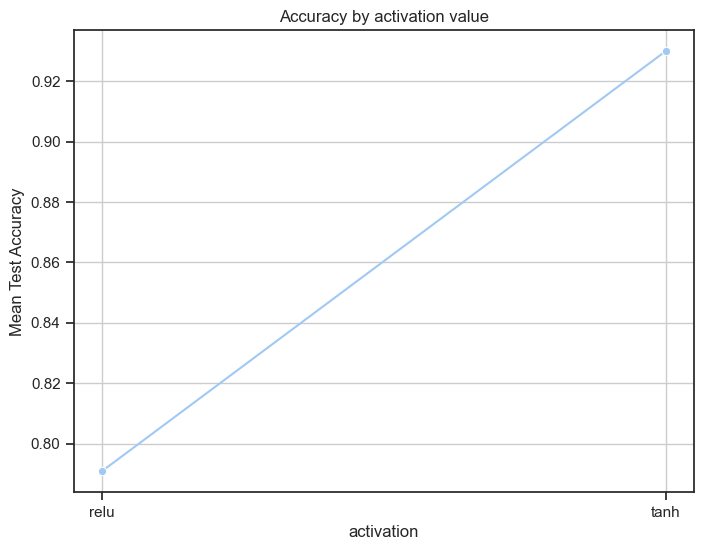

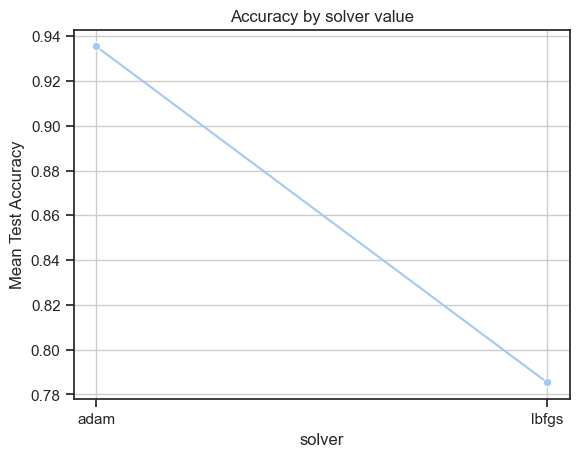

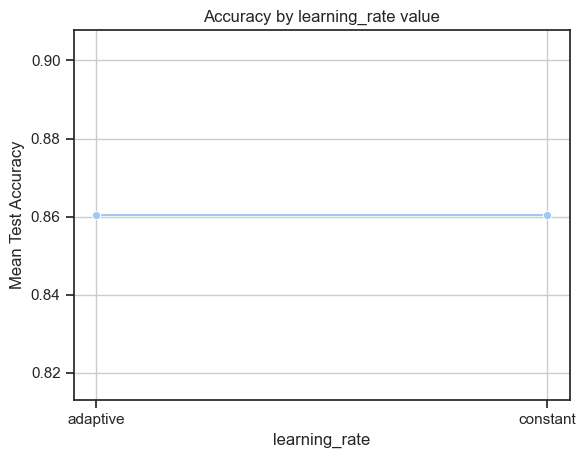

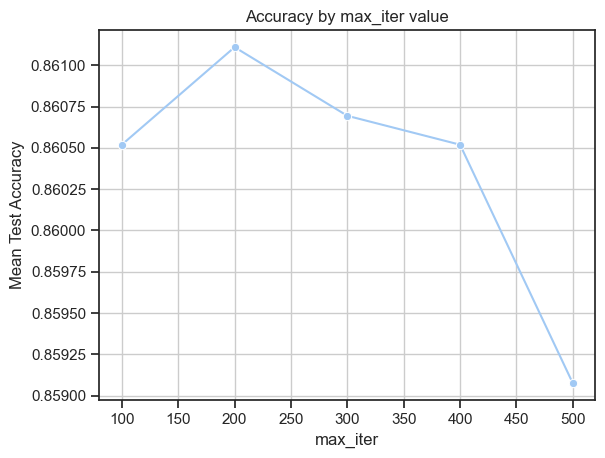

In [216]:
plt.figure(figsize=(8, 6))

for param in param_grid.keys():
    if param != 'hidden_layer_sizes':
        sns.lineplot(data=results.groupby('param_' + param, as_index=False).agg({'mean_test_score':'mean'}), 
                     x='param_' + param, y='mean_test_score', marker='o')
        plt.title('Accuracy by ' + param + ' value')
        plt.xlabel(param)
        plt.ylabel('Mean Test Accuracy')
        plt.grid(True)
        plt.show()

# Creating and examining the chosen model

In [223]:
simple_model = MLPClassifier(random_state=55, hidden_layer_sizes=(hidden_layer_size7, hidden_layer_size5, hidden_layer_size3), 
                             activation='tanh', solver='adam', learning_rate='constant', max_iter=200)
simple_model.fit(X_train_scaled, y_train)

C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='tanh', hidden_layer_sizes=(25, 15, 10),
              random_state=55)

## Evaluating the accuracy on the training data

In [224]:
predictions = simple_model.predict(X_train_scaled)
prediction_probs = simple_model.predict_proba(X_train_scaled)

print(f'Accuracy: {accuracy_score(y_train, predictions, normalize=True, sample_weight=None)}')
print(f'Avg CV accuracy: {np.mean(cross_val_score(simple_model, X_train_scaled, y_train, cv=5))}')

Accuracy: 0.9508225411270563


C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Avg CV accuracy: 0.9322726672295067


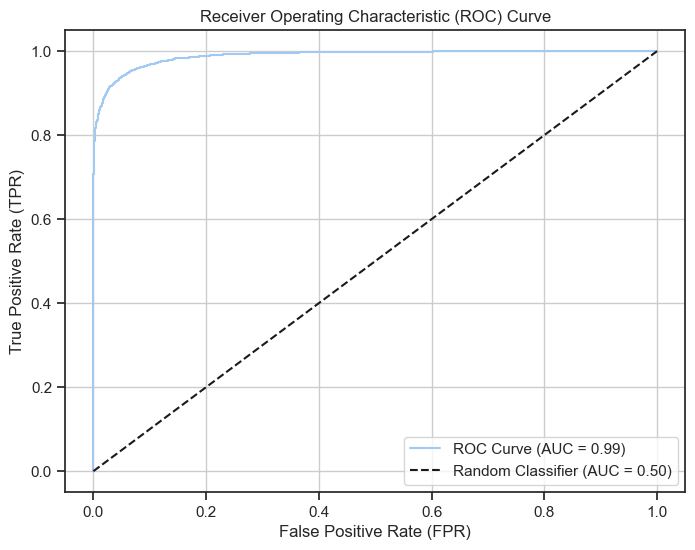

In [219]:
y_train_binary = [int(entry) for entry in np.where(y_train == 'M', 1, 0)]
prediction_probs_binary = [x[1] for x in prediction_probs]

fpr, tpr, thresholds = roc_curve(y_train_binary, prediction_probs_binary)

# 4. Calculate AUC Score
auc_score = roc_auc_score(y_train_binary, prediction_probs_binary)

# 5. Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

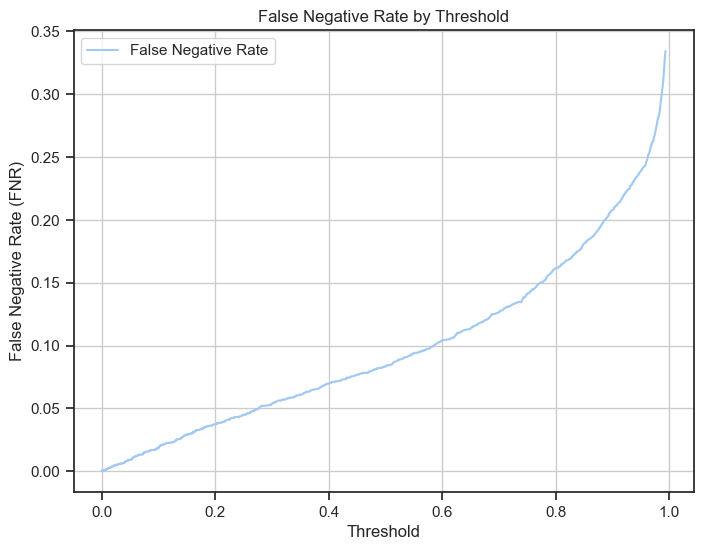

In [225]:
fpr, fnr, thresholds = det_curve(y_train_binary, prediction_probs_binary)
plt.figure(figsize=(8, 6))
plt.plot(thresholds, fnr, label='False Negative Rate')
plt.xlabel('Threshold')
plt.ylabel('False Negative Rate (FNR)')
plt.title('False Negative Rate by Threshold')
plt.grid(True)
plt.legend()
plt.show()

## Examing the false positives and false negatives

In [226]:
prediction_df = pd.DataFrame({'diagnosis': y_train, 
                              'prediction' : predictions,
                              'M_probability': [x[1] for x in prediction_probs],
                              'prediction_probability': [np.max([x[0], x[1]]) for x in prediction_probs]})

prediction_df['prediction_accuracy'] = 'TP'
prediction_df.loc[(prediction_df.diagnosis == 'B') & (prediction_df.prediction == 'B'), 'prediction_accuracy'] = 'TN'
prediction_df.loc[(prediction_df.diagnosis == 'B') & (prediction_df.prediction == 'M'), 'prediction_accuracy'] = 'FP'
prediction_df.loc[(prediction_df.diagnosis == 'M') & (prediction_df.prediction == 'B'), 'prediction_accuracy'] = 'FN'

grouped_by_accuracy = prediction_df.groupby('prediction_accuracy', as_index=False)
predictions_by_accuracy = grouped_by_accuracy['prediction_probability'].agg(['mean', 'std'])
predictions_by_accuracy['lower_bound'] = predictions_by_accuracy['mean'] - 1.96*predictions_by_accuracy['std']
predictions_by_accuracy['upper_bound'] = predictions_by_accuracy['mean'] + 1.96*predictions_by_accuracy['std']

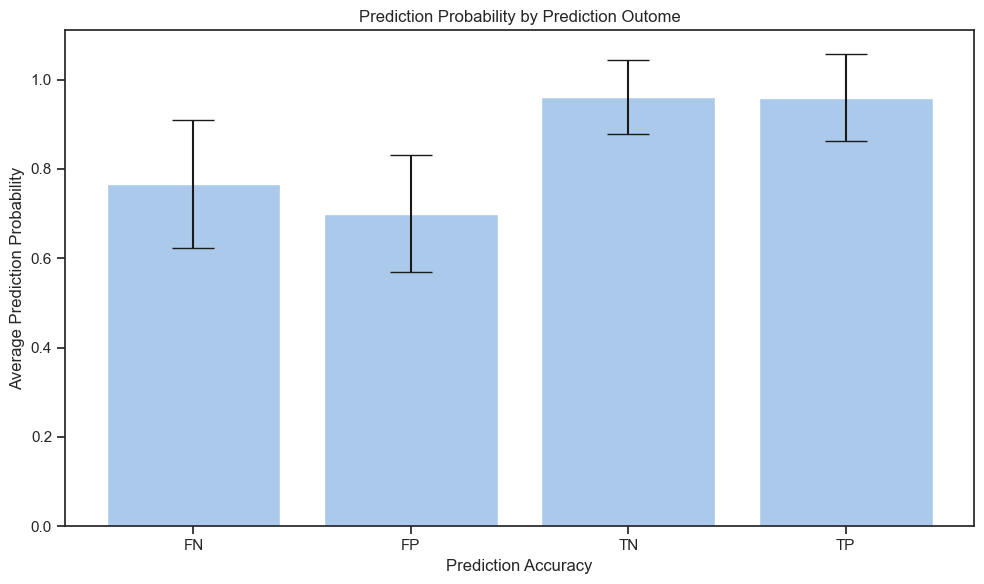

In [227]:
plt.figure(figsize=(10, 6))
sns.barplot(x='prediction_accuracy', y='mean', 
            data=predictions_by_accuracy)
plt.errorbar(x='prediction_accuracy', y='mean', yerr='std', fmt='none',
             data=predictions_by_accuracy, capsize=15, ecolor='k')
plt.title('Prediction Probability by Prediction Outome')
plt.xlabel('Prediction Accuracy')
plt.ylabel('Average Prediction Probability')
plt.tight_layout()
plt.show()

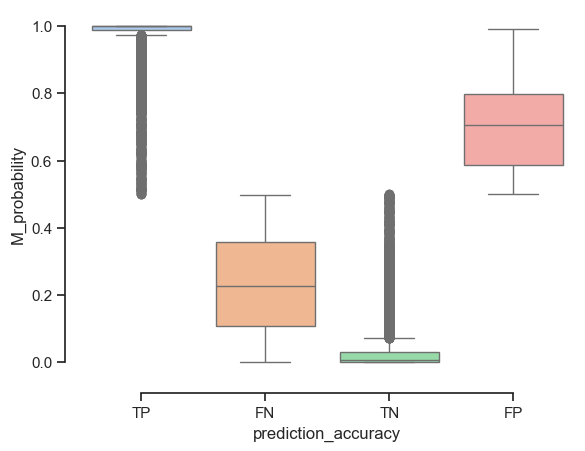

In [228]:
sns.boxplot(x="prediction_accuracy", y='M_probability',
            hue="prediction_accuracy",
            data=prediction_df)
sns.despine(offset=10, trim=True)
plt.show()

## Graphing feature importance

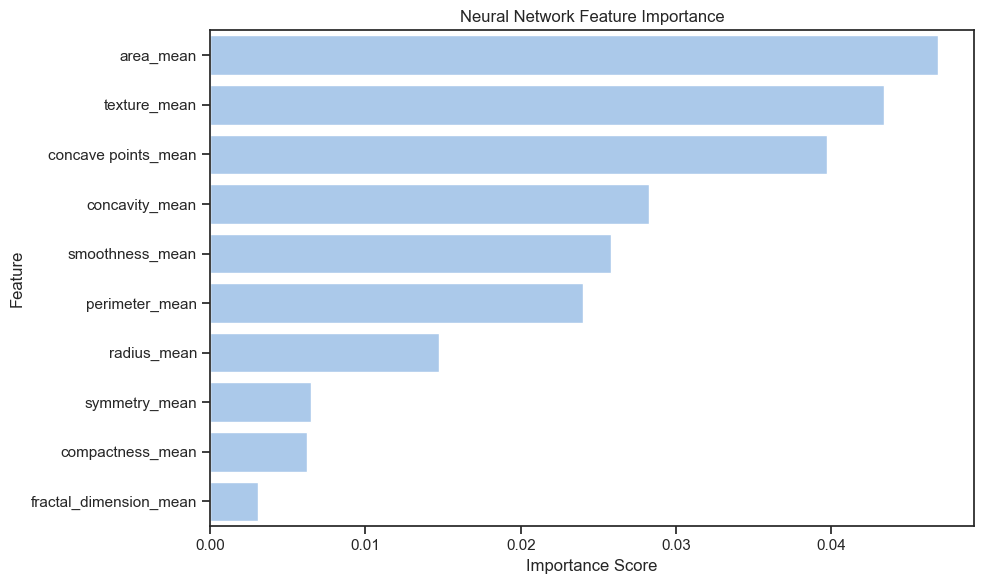

In [229]:
importances = permutation_importance(simple_model, X_train_scaled, y_train, 
                                     n_repeats=10, random_state=55, scoring='accuracy')
feature_importance_df = pd.DataFrame({'feature': columns_for_model, 'importance': importances.importances_mean})\
    .sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Neural Network Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Feature Engineering

In [230]:
predictions_wide = prediction_df.merge(X_train, left_index=True, right_index=True, how='inner')

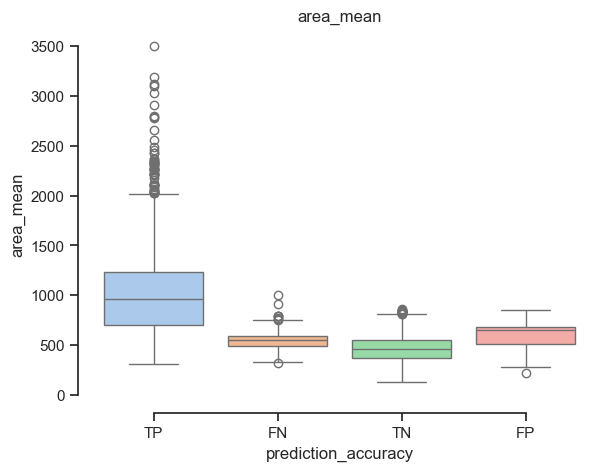

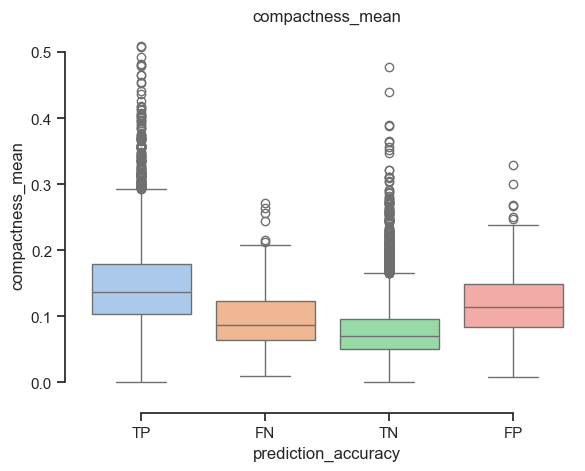

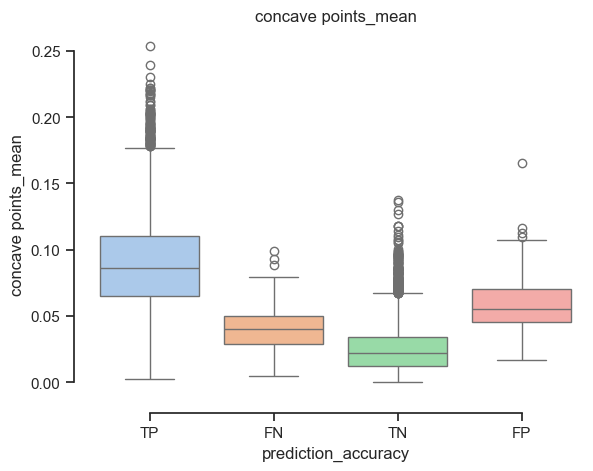

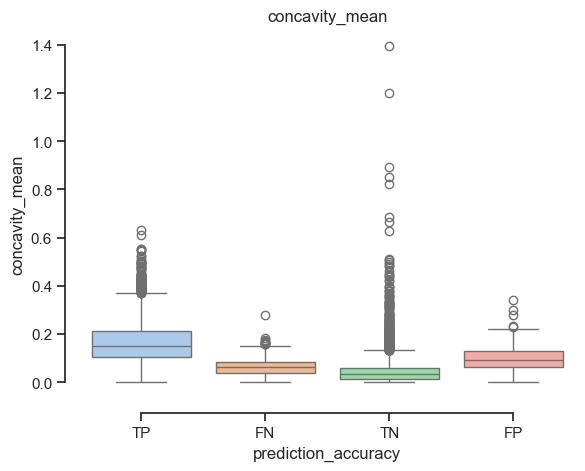

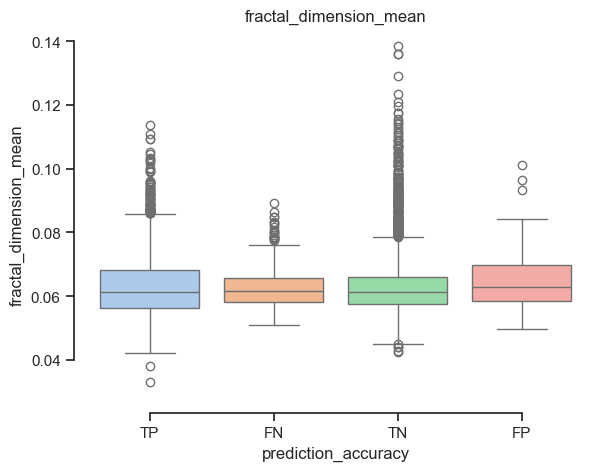

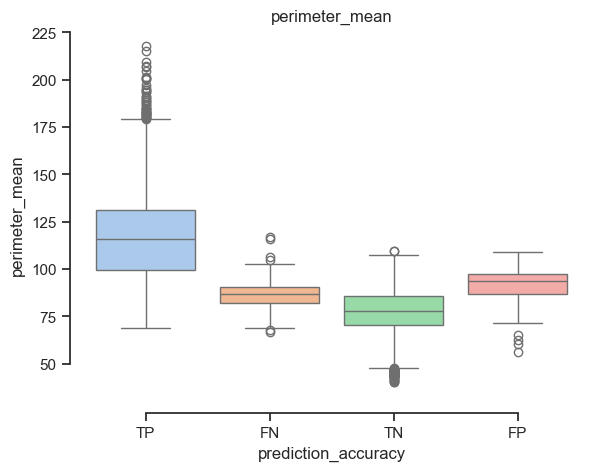

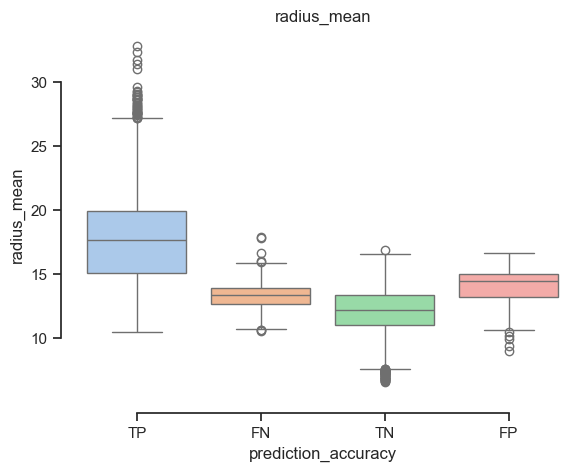

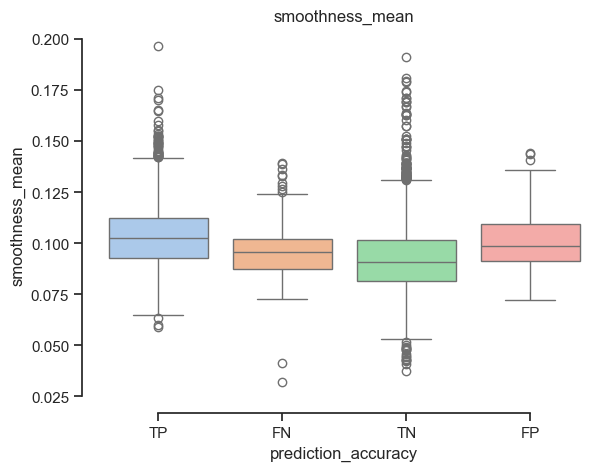

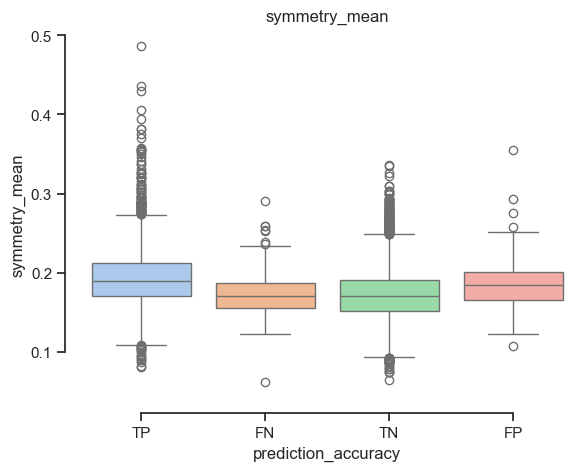

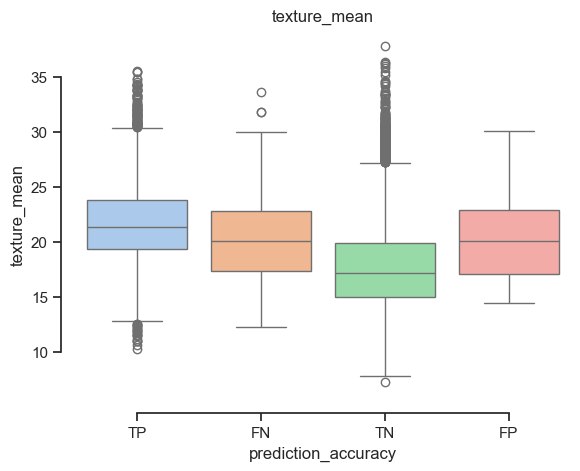

In [231]:
sns.set_theme(style="ticks", palette="pastel")
input_columns = predictions_wide.columns[5:].tolist()
input_columns.sort()

for col in input_columns:
# Draw a nested boxplot to show bills by day and time
    sns.boxplot(x='prediction_accuracy', y=col,
                hue='prediction_accuracy',
                data=predictions_wide)
    sns.despine(offset=10, trim=True)
    plt.title(f"{col}")
    plt.show()

 - area_mean, concave points_mean, perimeter_mean, radius_mean, texture_mean could all be squared

## Looking at feature correlation

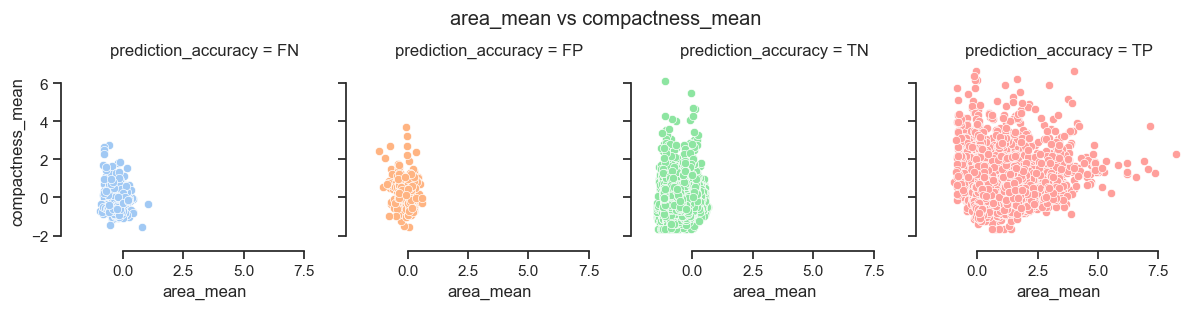

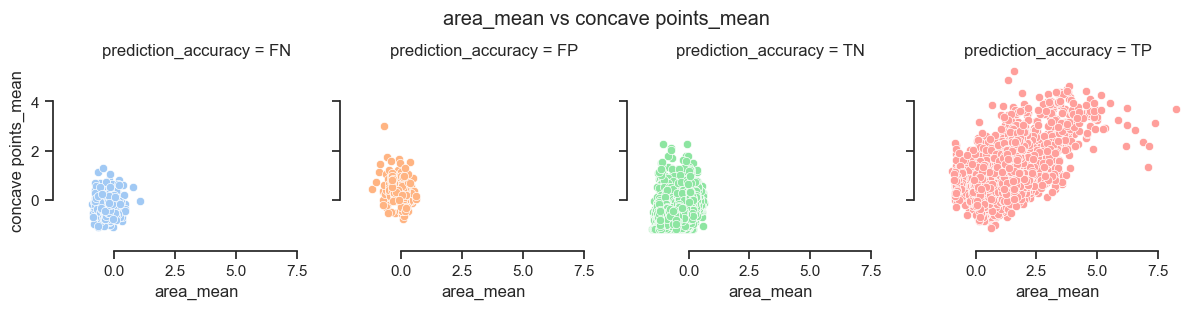

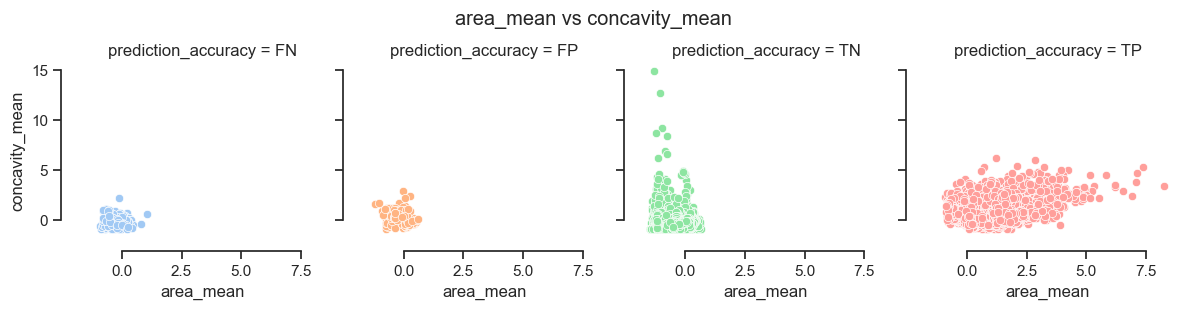

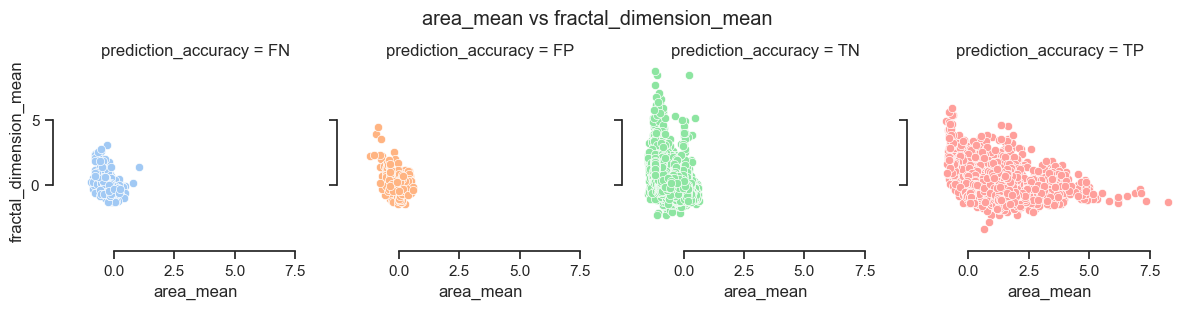

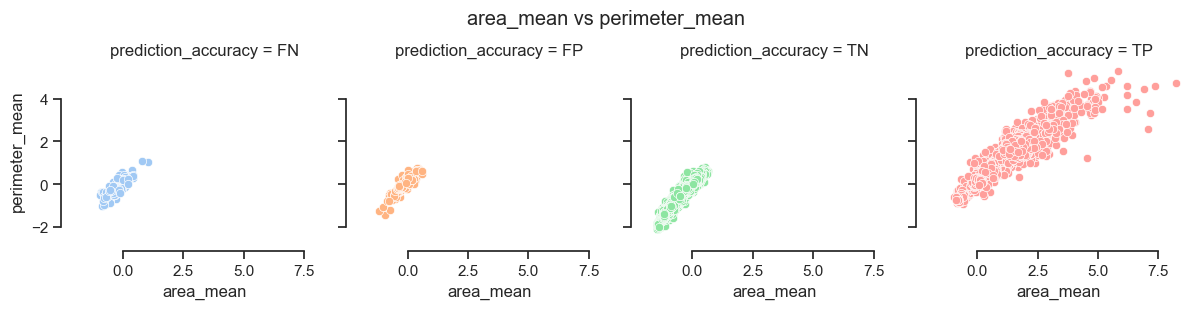

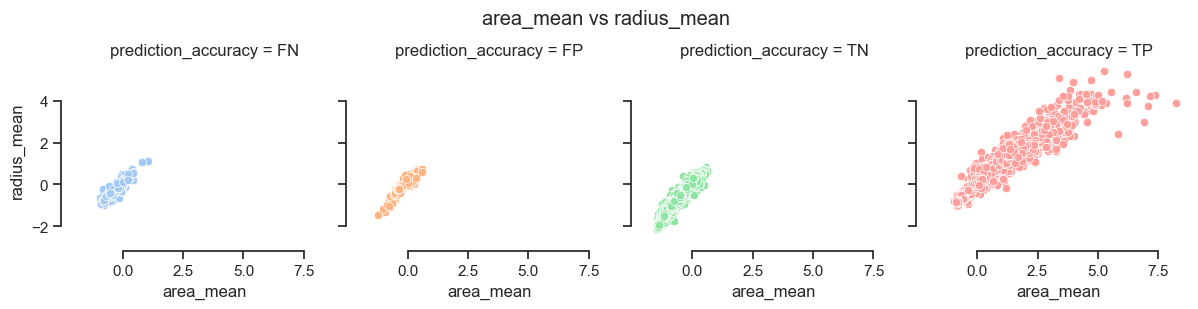

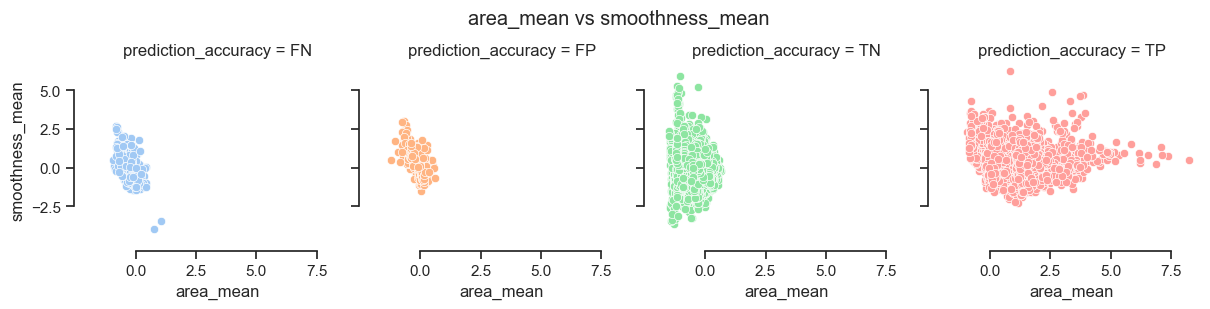

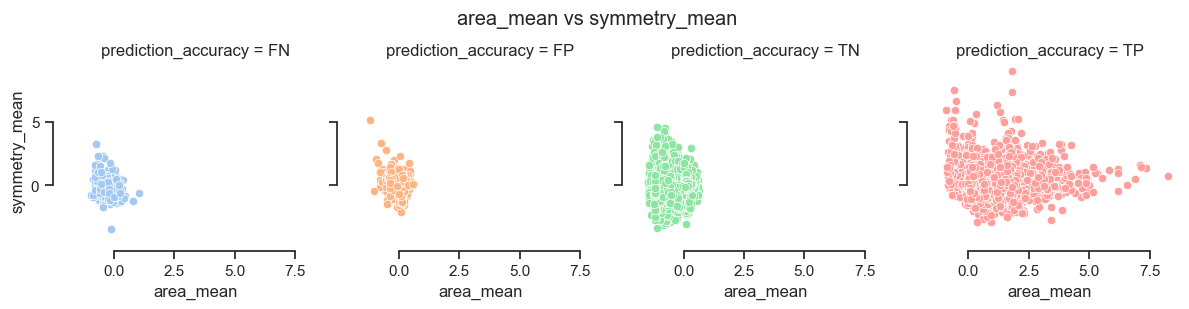

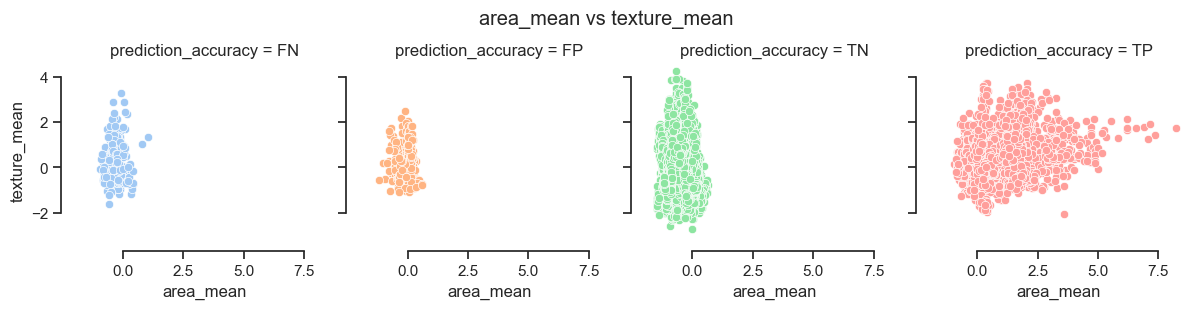

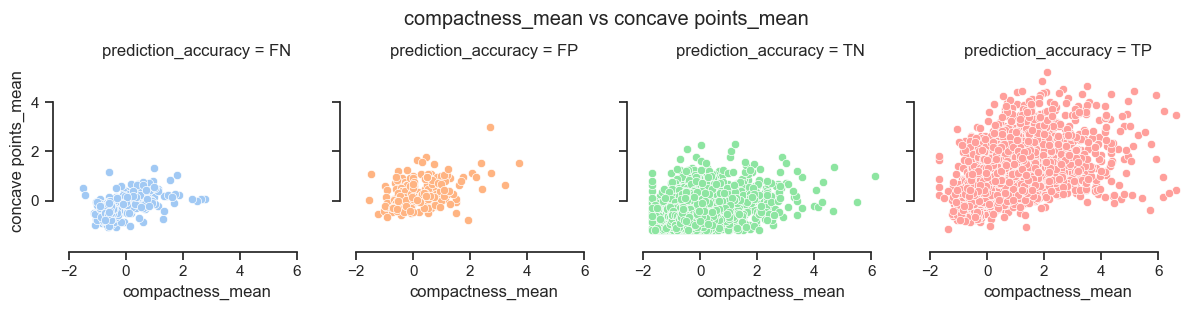

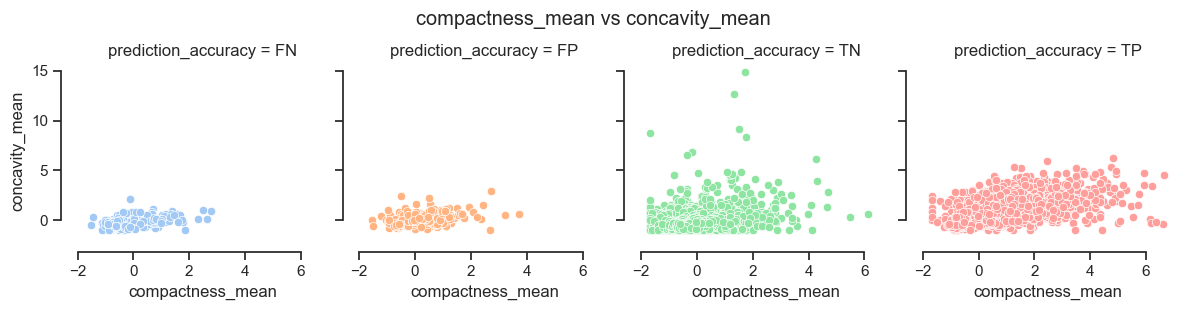

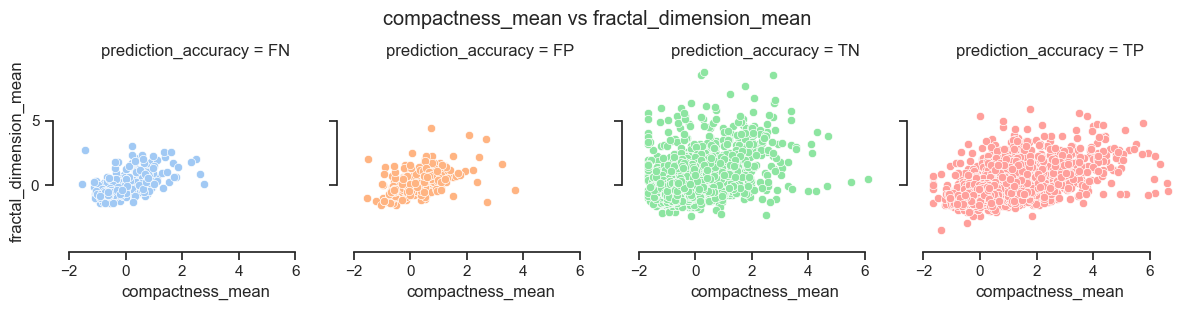

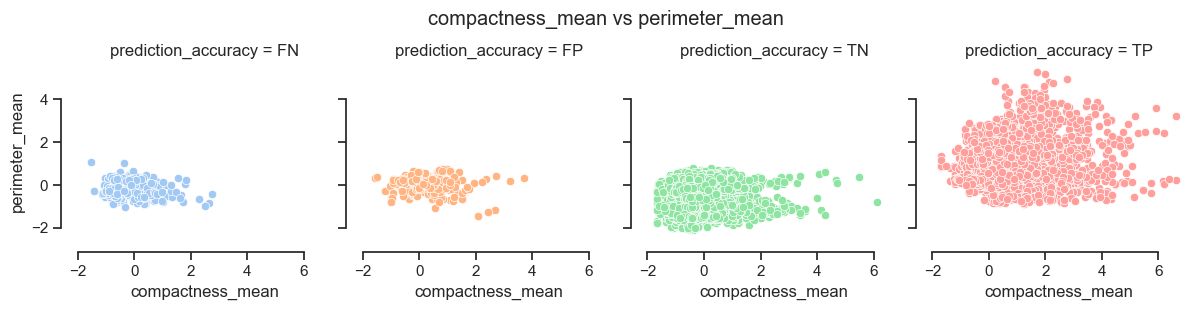

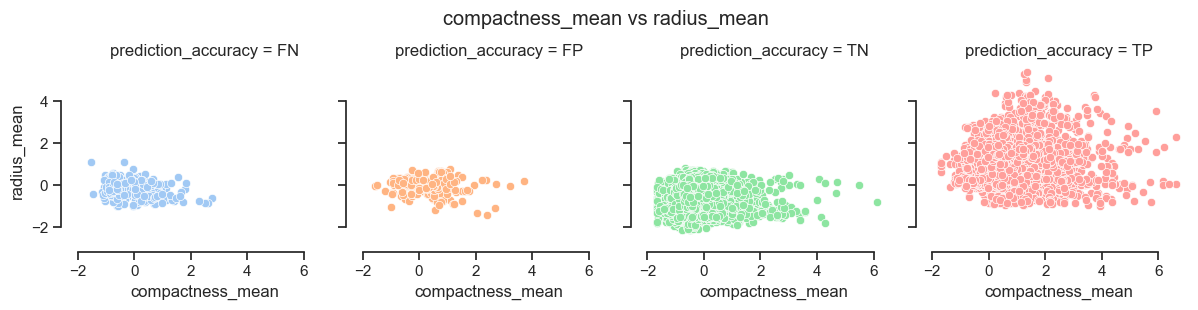

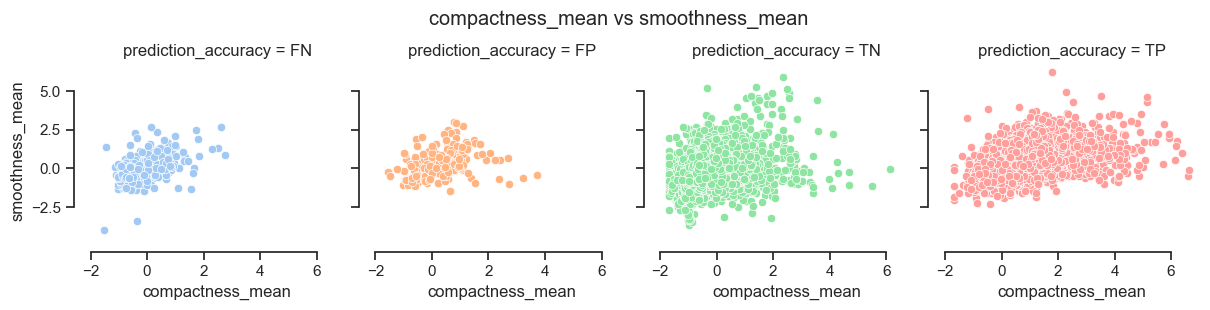

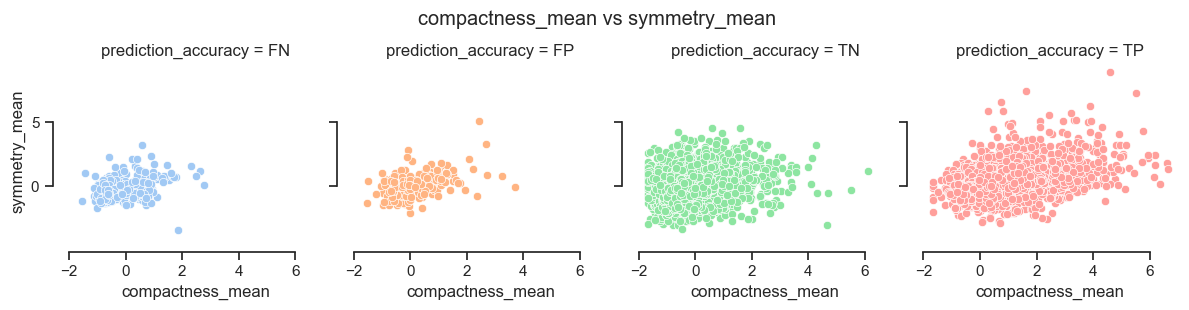

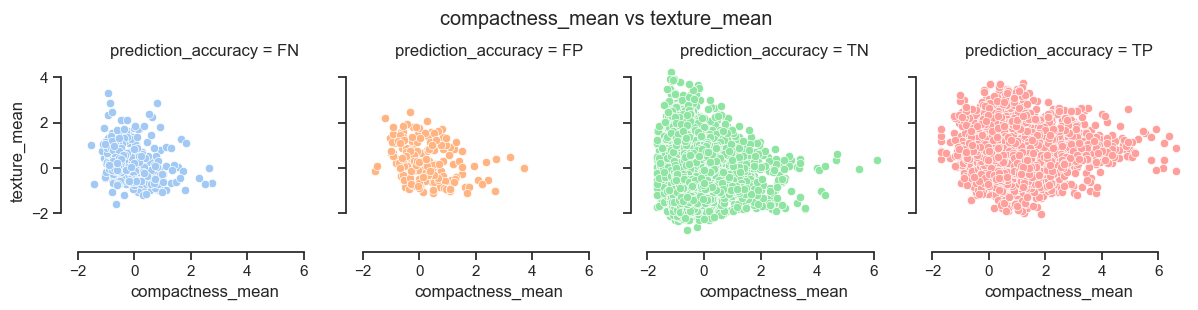

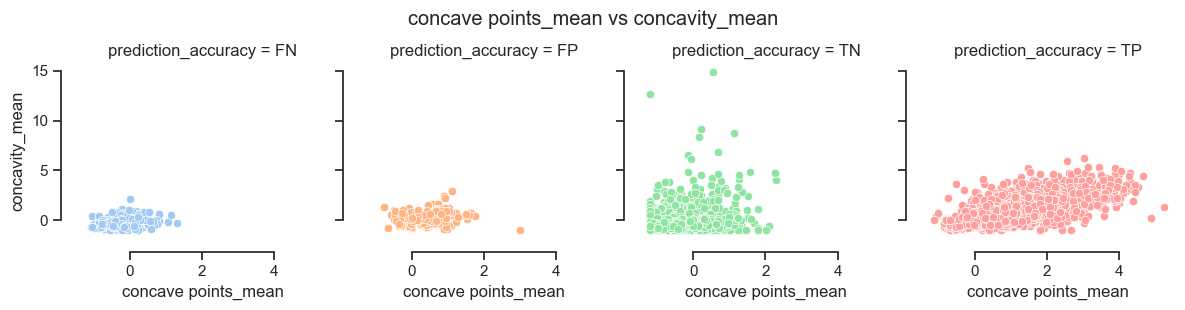

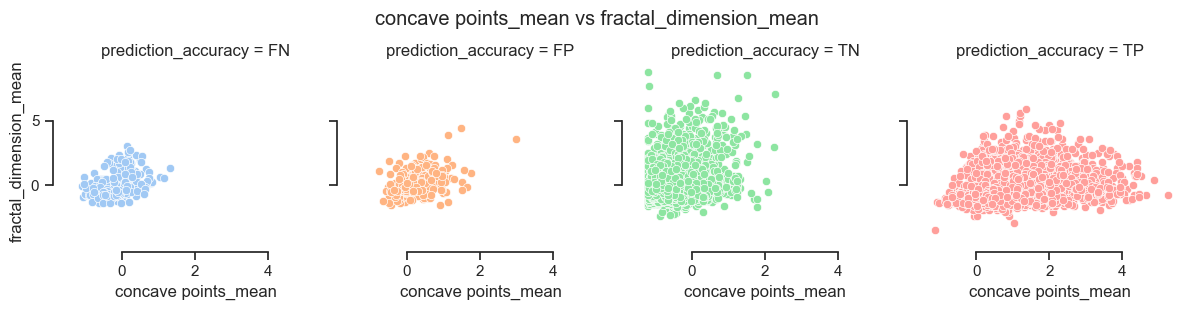

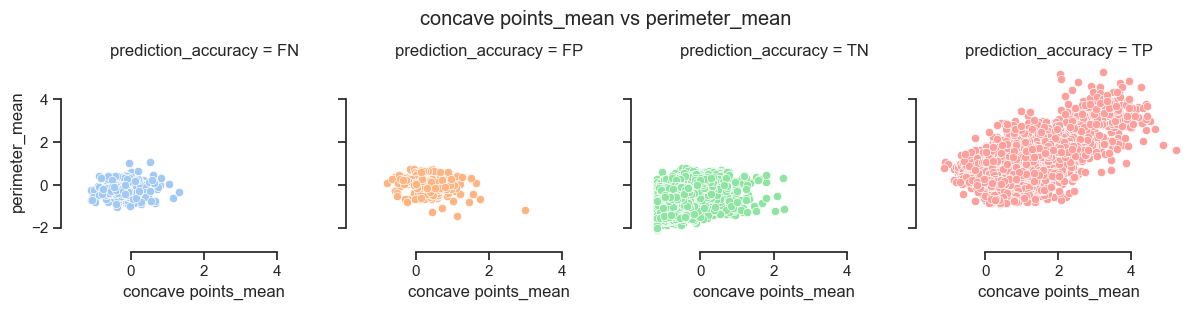

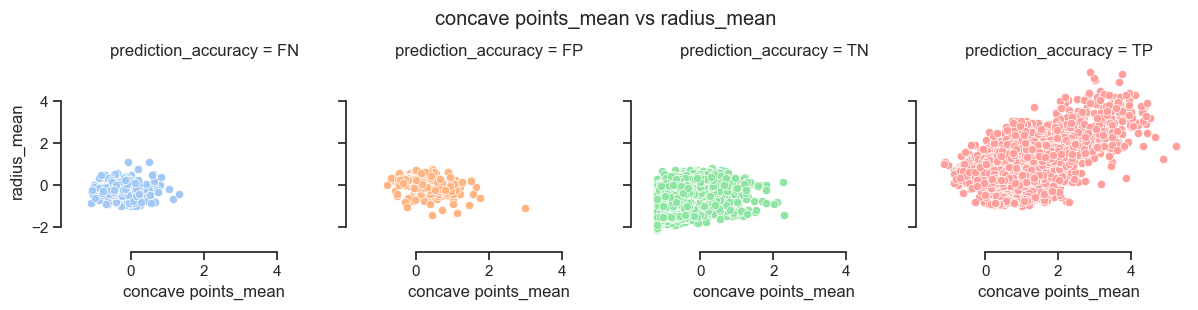

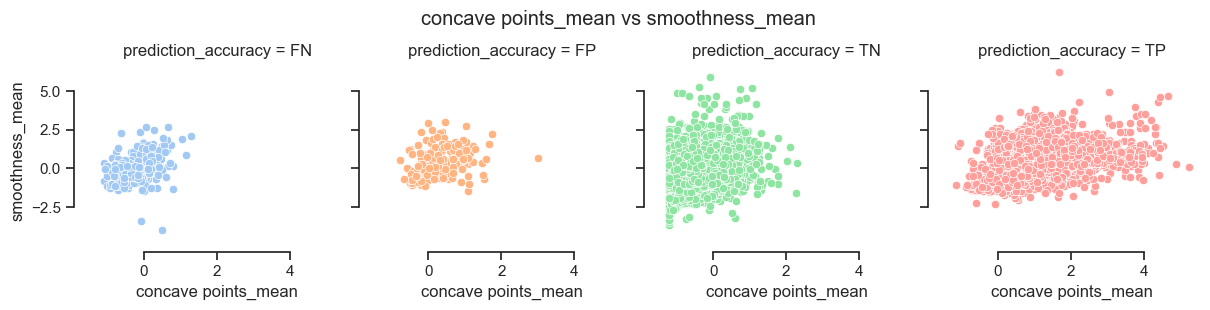

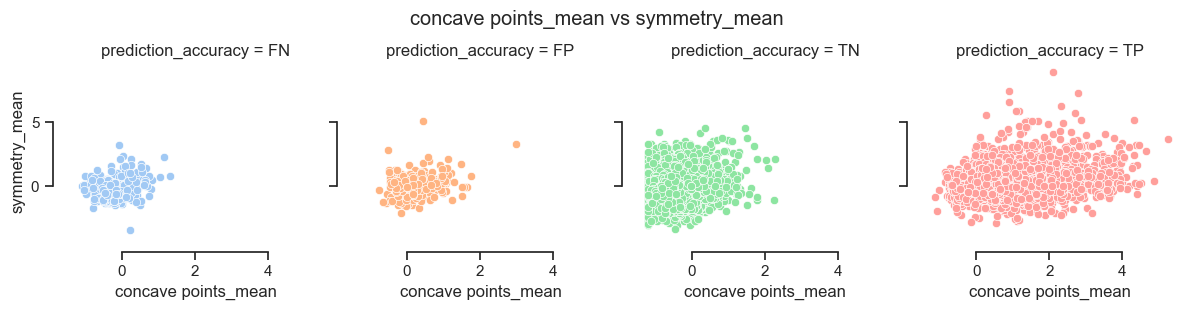

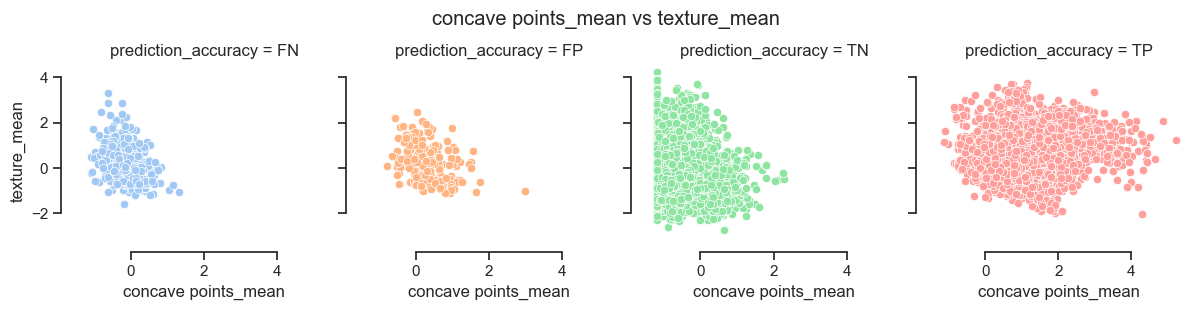

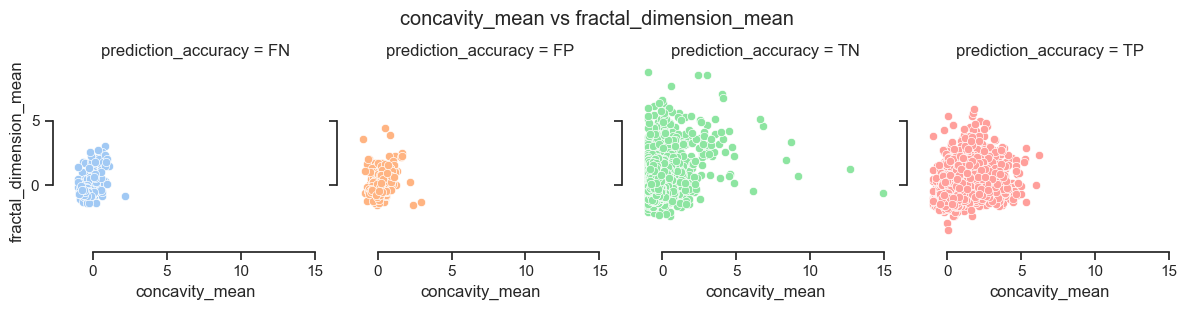

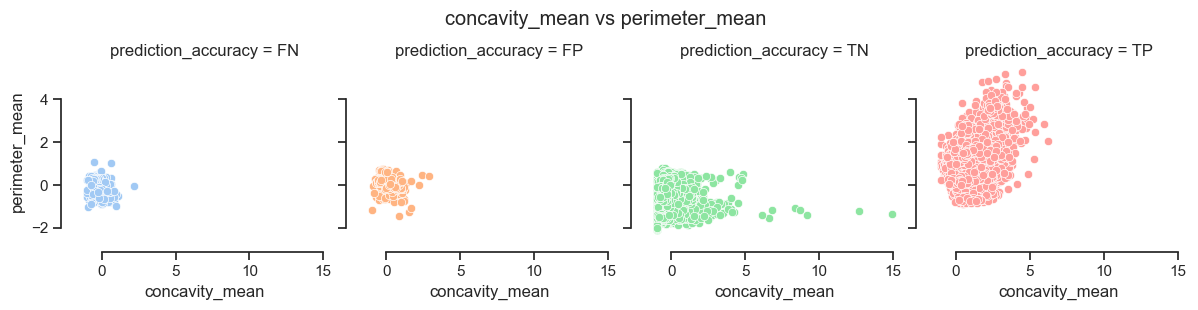

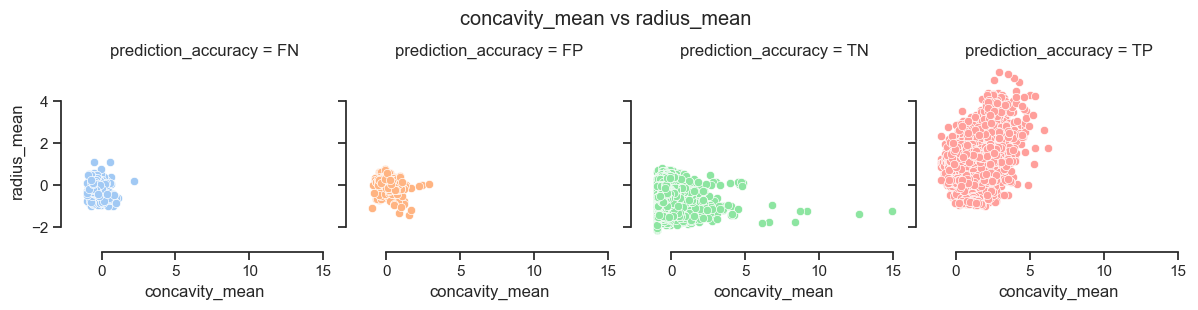

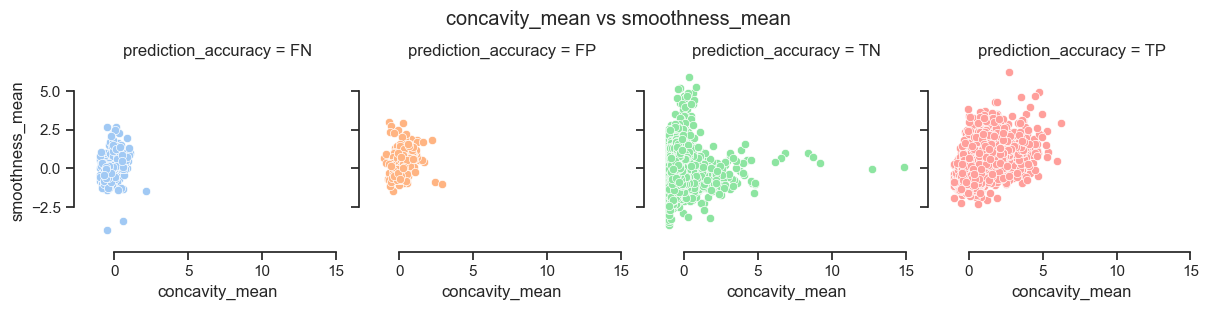

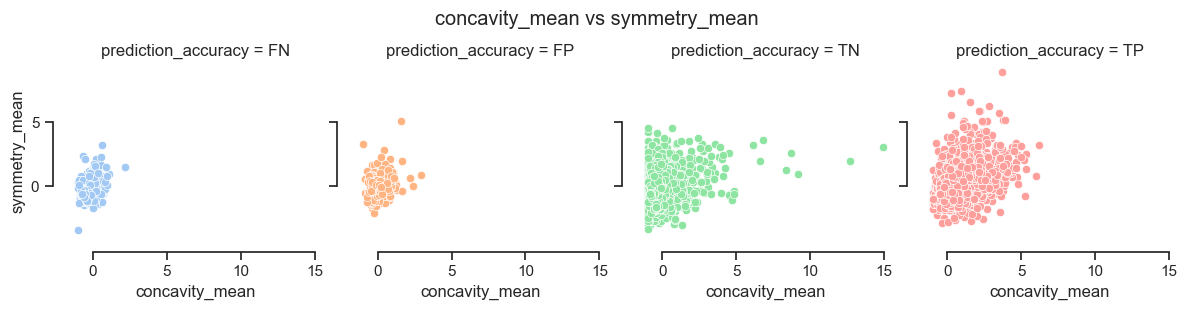

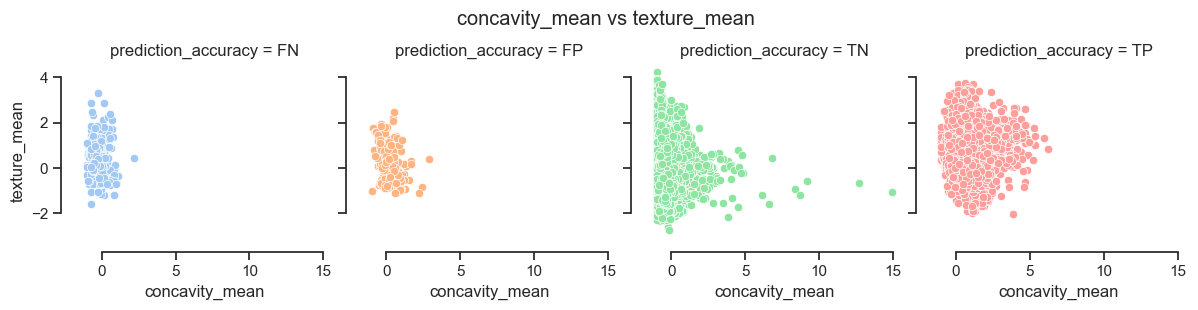

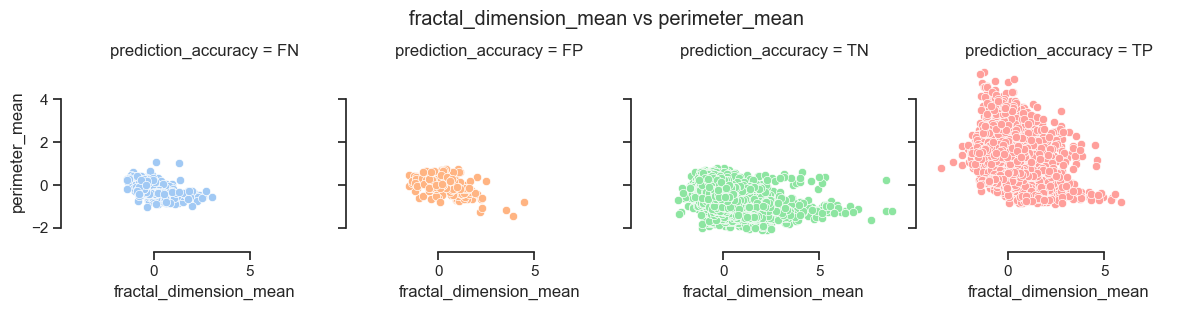

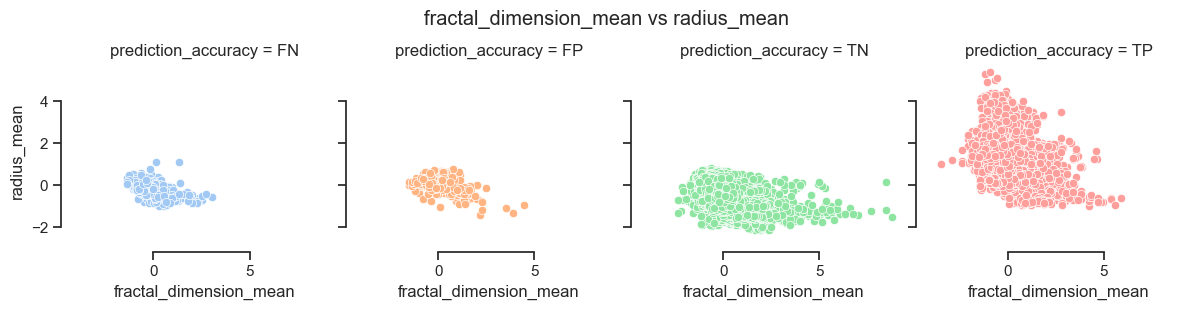

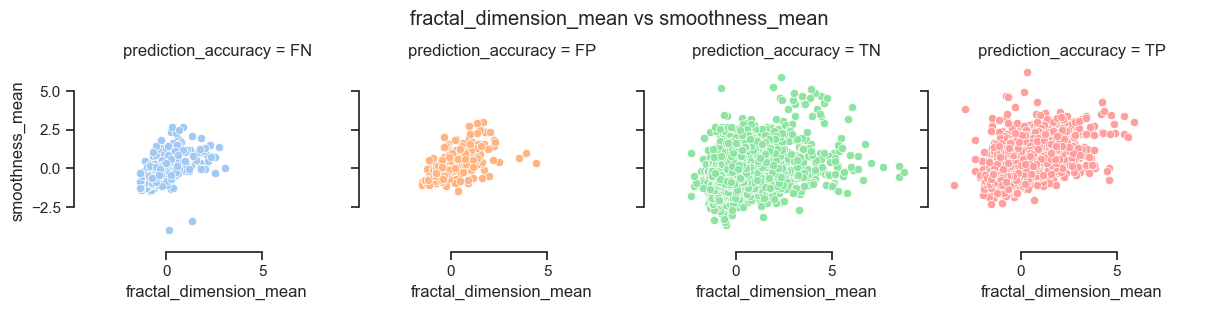

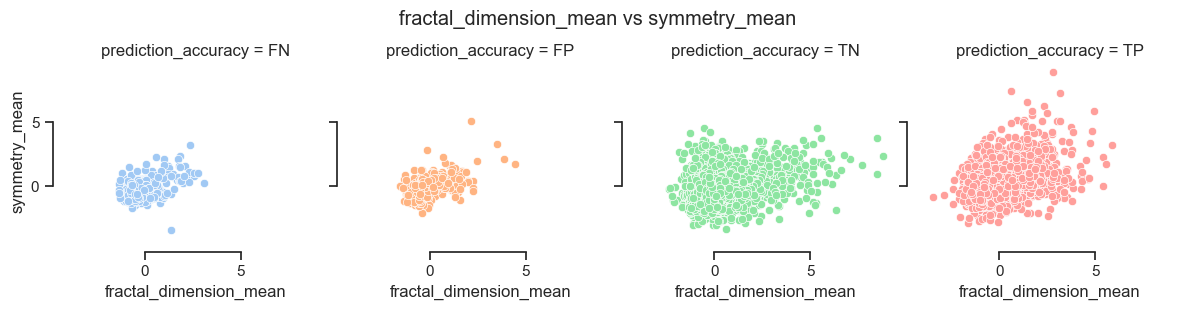

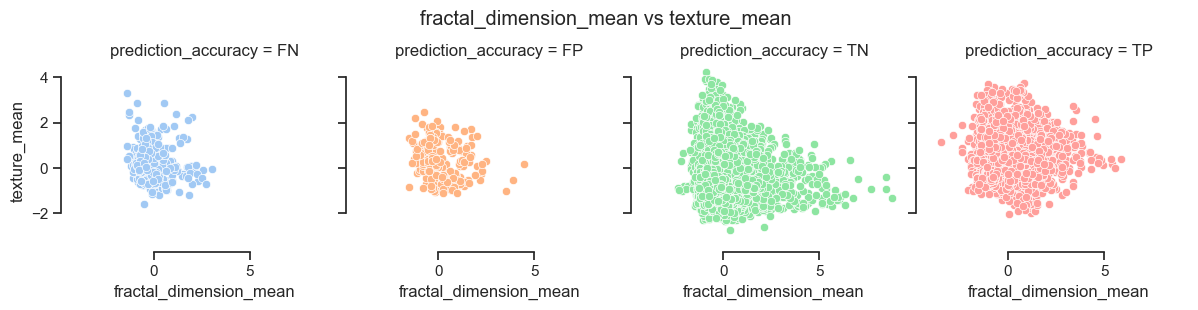

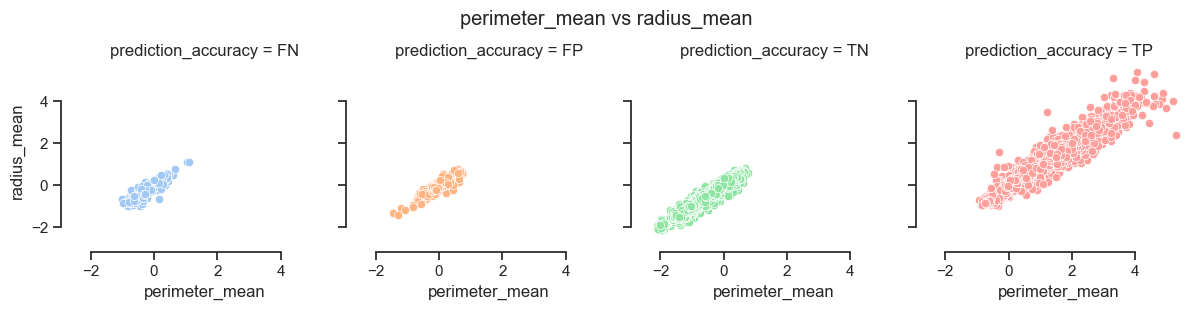

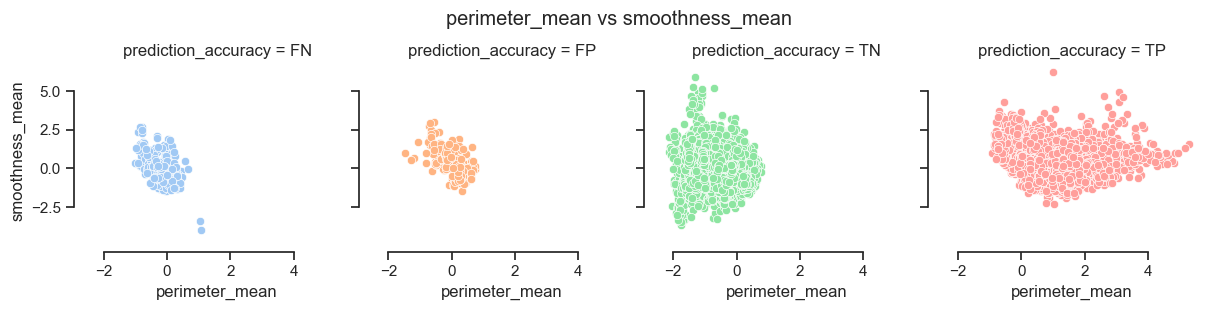

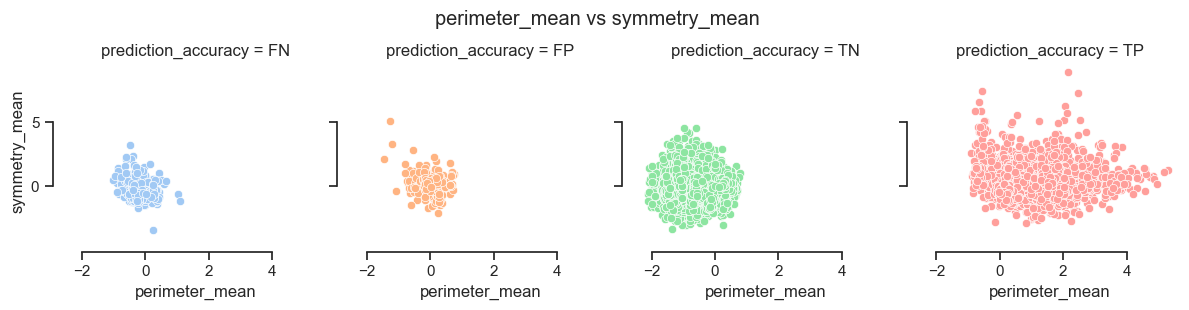

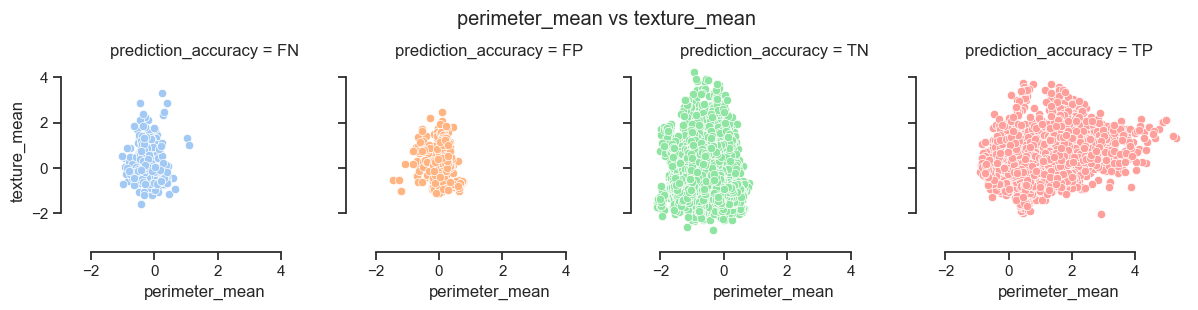

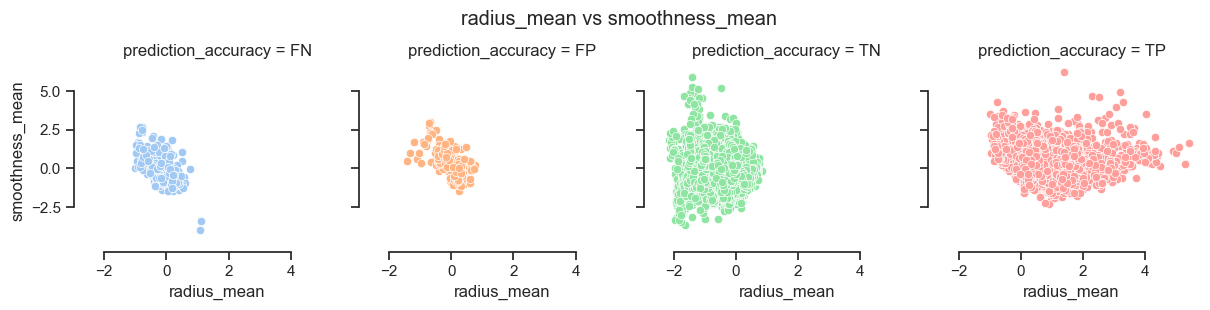

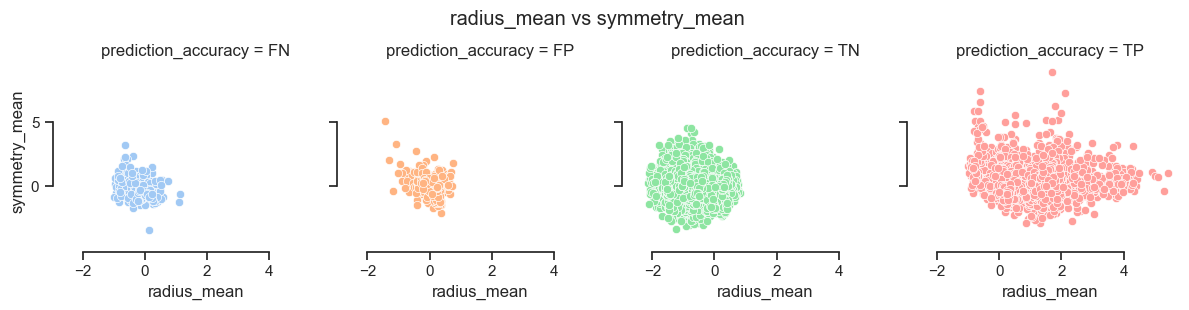

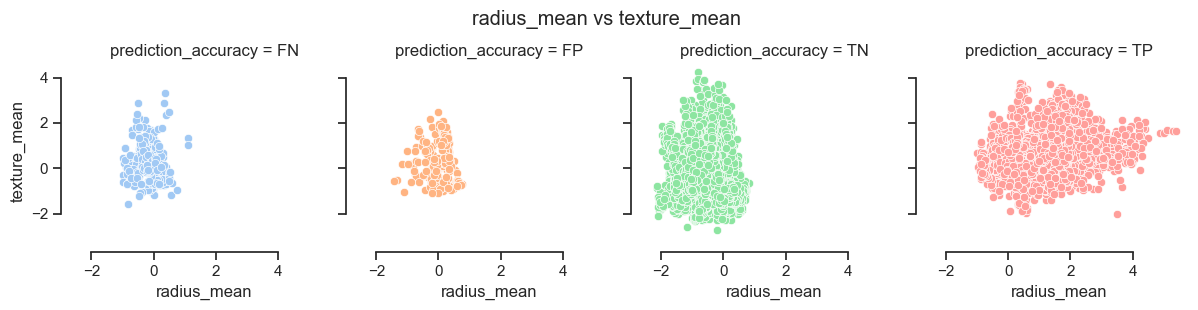

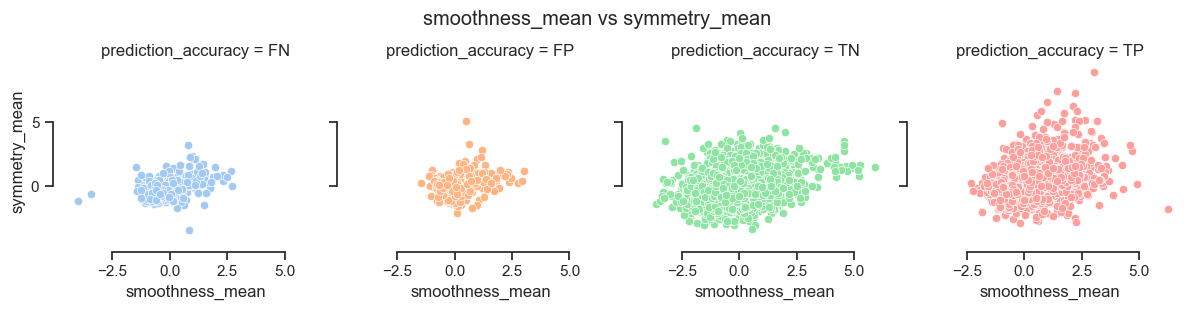

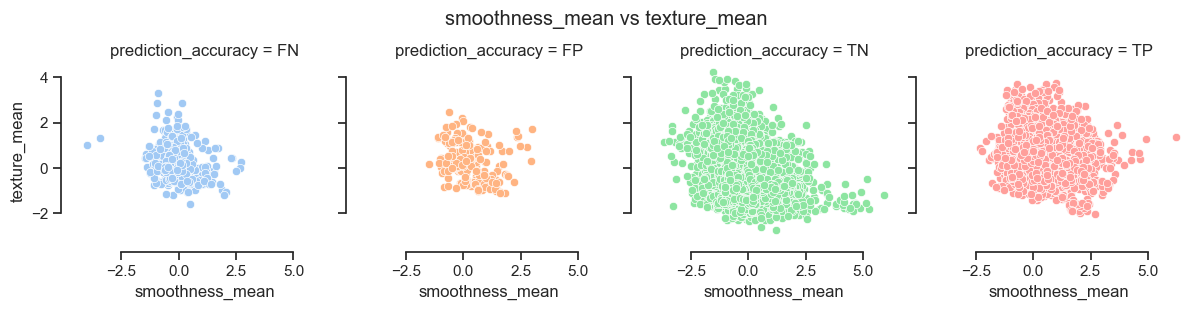

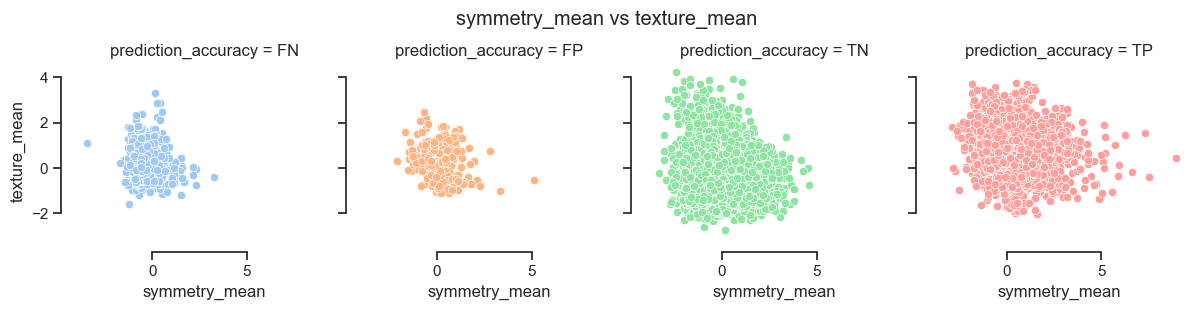

In [232]:
for i in range(len(input_columns)):
    for j in range(i+1, len(input_columns)):
        col1 = input_columns[i]
        col2 = input_columns[j]
        normalized = predictions_wide[['prediction_accuracy', col1, col2]].copy()\
            .sort_values('prediction_accuracy')
        normalized['col1'] = (normalized[col1] - normalized[col1].mean())/normalized[col1].std()
        normalized['col2'] = (normalized[col2] - normalized[col2].mean())/normalized[col2].std()
        g = sns.FacetGrid(normalized, col='prediction_accuracy', hue='prediction_accuracy')
        g.map(sns.scatterplot, "col1", "col2")
        g.fig.subplots_adjust(top=0.8)
        g.fig.suptitle(f"{col1} vs {col2}")
        g.set_xlabels(col1)
        g.set_ylabels(col2)
        sns.despine(offset=10, trim=True)
        plt.show()

 - area vs concavity - TN have more concavity vs area
 - area vs fractal - TN have more concavity vs area
 - area vs smoothness - TN have more concavity vs area
 - compactness vs concavity - TN have more concavity vs area
 - concave points vs concavity - TN have more concavity vs area
 - concavity vs fractal_dimension
 - concavity vs perimeter
 - concavity vs radius
 - concavity vs smoothness
 - concavity vs symmetry
 - concavity vs texture
 - fractal_dimension vs perimeter
 - fractal_dimension vs radius
 - fractal_dimension vs symmetry
 - fractal_dimension vs texture
 - smoothness vs symmetry
 - smoothness vs texture

## Creating new features

In [234]:
predictions_wide['area_mean_squared'] = predictions_wide.area_mean**2
predictions_wide['concave_points_mean_squared'] = predictions_wide['concave points_mean']**2
predictions_wide['perimeter_mean_squared'] = predictions_wide.perimeter_mean**2
predictions_wide['radius_mean_squared'] = predictions_wide.radius_mean**2
predictions_wide['texture_mean_squared'] = predictions_wide.texture_mean**2

predictions_wide['concavity_over_area'] = predictions_wide.concavity_mean/predictions_wide.area_mean
predictions_wide['fractal_dimension_over_area'] = predictions_wide.fractal_dimension_mean/predictions_wide.area_mean
predictions_wide['smoothness_over_area'] = predictions_wide.smoothness_mean/predictions_wide.area_mean

predictions_wide['compactness_over_concavity'] = predictions_wide.compactness_mean/(predictions_wide.concavity_mean + 0.01)
predictions_wide['concave points_over_concavity'] = predictions_wide['concave points_mean']/(
    predictions_wide.concavity_mean + 0.01)
predictions_wide['fractal_over_concavity'] = predictions_wide.fractal_dimension_mean/(predictions_wide.concavity_mean + 0.01)
predictions_wide['perimeter_over_concavity'] = predictions_wide.perimeter_mean/(predictions_wide.concavity_mean + 0.01)
predictions_wide['radius_over_concavity'] = predictions_wide.radius_mean/(predictions_wide.concavity_mean + 0.01)
predictions_wide['smoothness_over_concavity'] = predictions_wide.smoothness_mean/(predictions_wide.concavity_mean + 0.01)
predictions_wide['symmetry_over_concavity'] = predictions_wide.symmetry_mean/(predictions_wide.concavity_mean + 0.01)
predictions_wide['texture_over_concavity'] = predictions_wide.texture_mean/(predictions_wide.concavity_mean + 0.01)

predictions_wide['perimeter_over_fractal'] = predictions_wide.perimeter_mean/predictions_wide.fractal_dimension_mean
predictions_wide['radius_over_fractal'] = predictions_wide.radius_mean/predictions_wide.fractal_dimension_mean
predictions_wide['symmetry_over_fractal'] = predictions_wide.symmetry_mean/predictions_wide.fractal_dimension_mean
predictions_wide['texture_over_fractal'] = predictions_wide.texture_mean/predictions_wide.fractal_dimension_mean

predictions_wide['symmetry_over_smoothness'] = predictions_wide.symmetry_mean/predictions_wide.smoothness_mean
predictions_wide['texture_over_smoothness'] = predictions_wide.texture_mean/predictions_wide.smoothness_mean

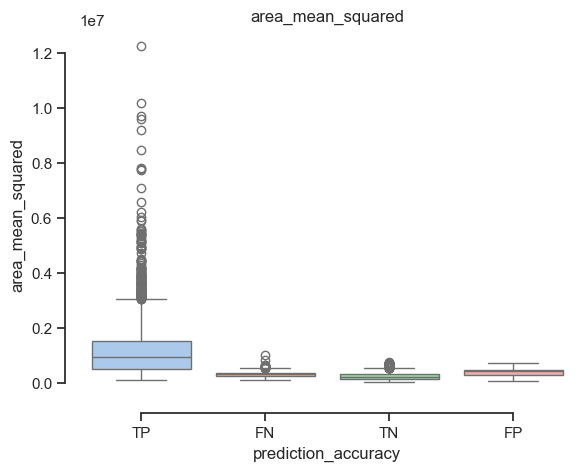

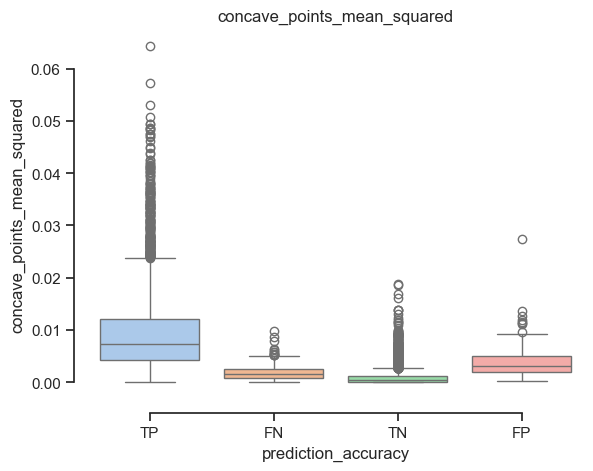

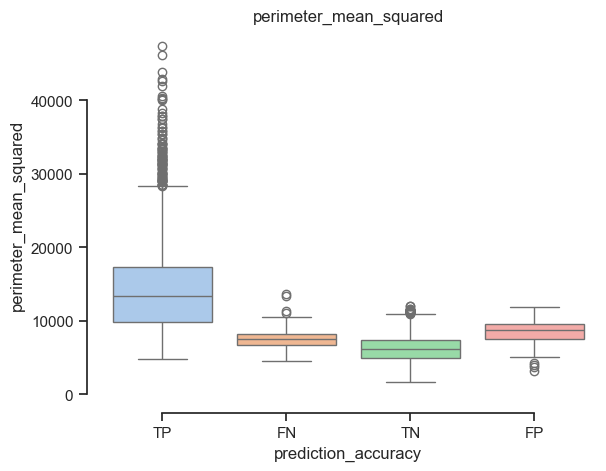

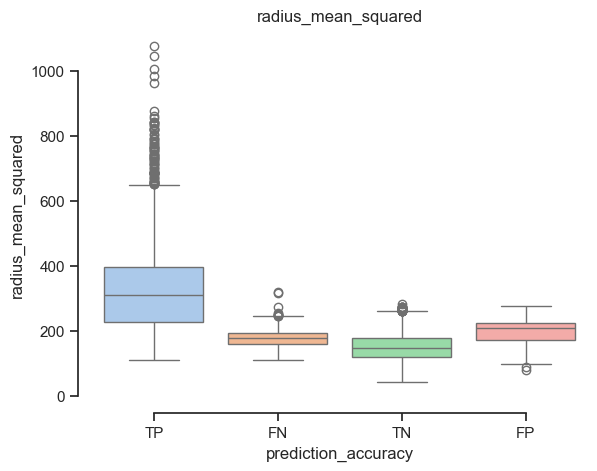

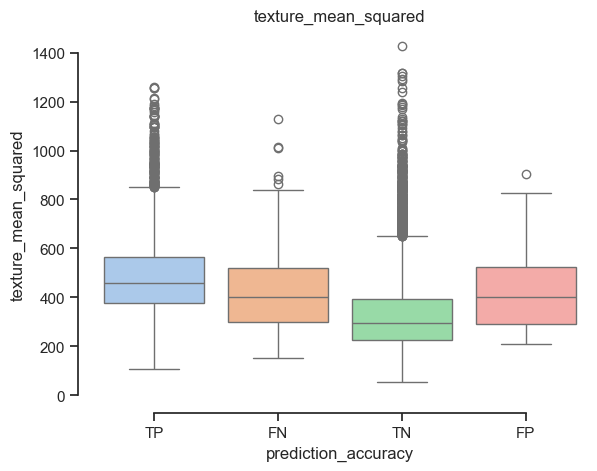

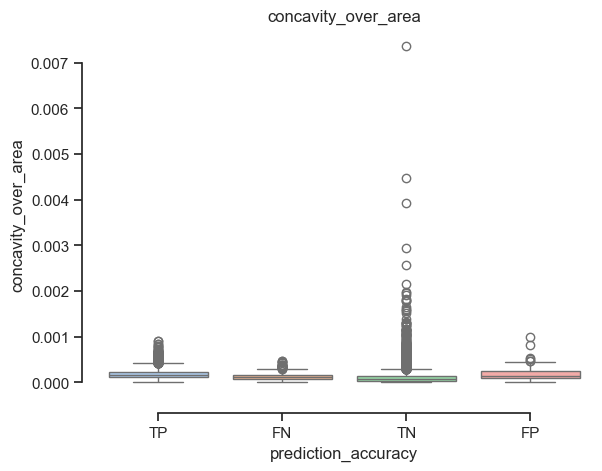

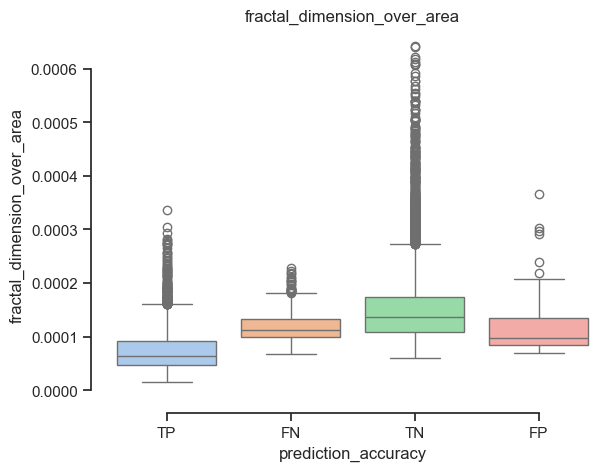

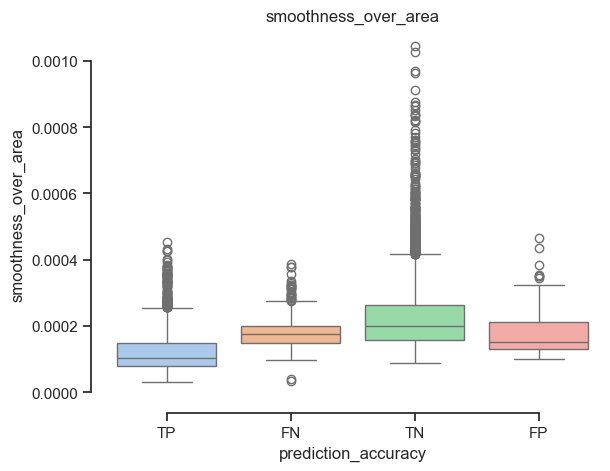

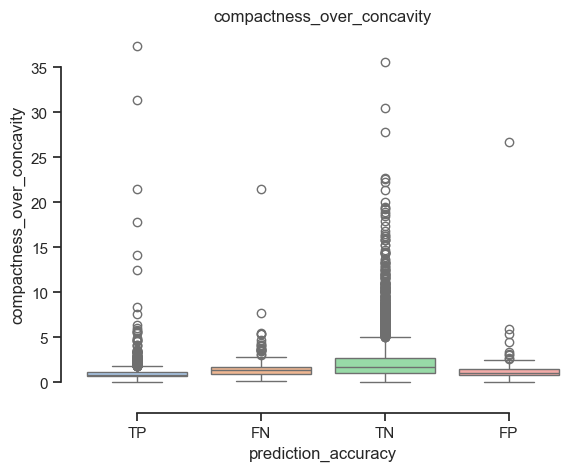

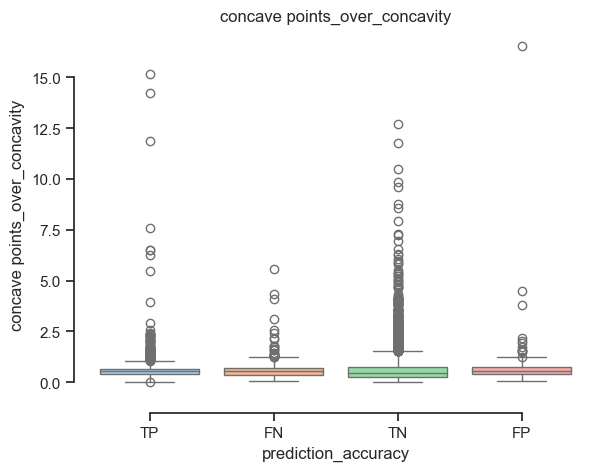

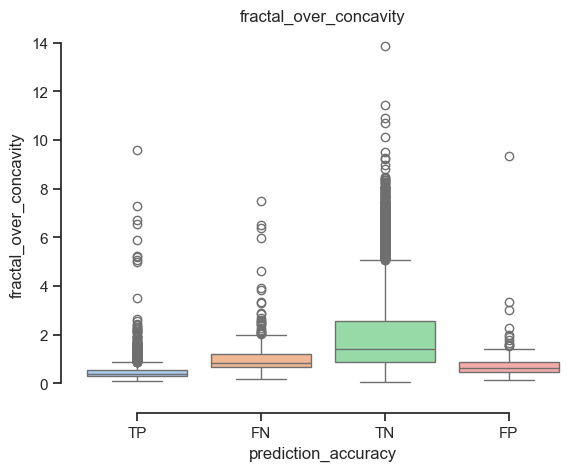

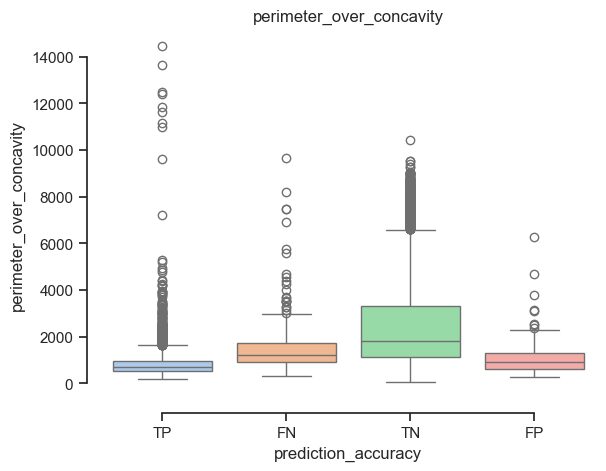

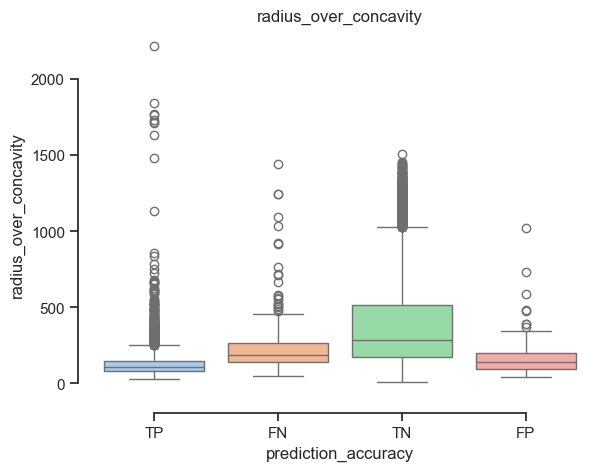

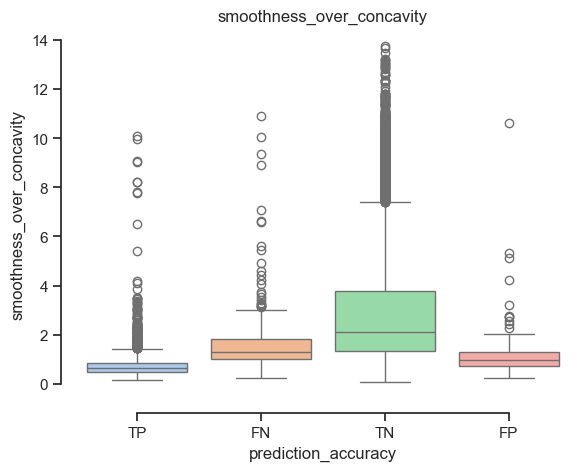

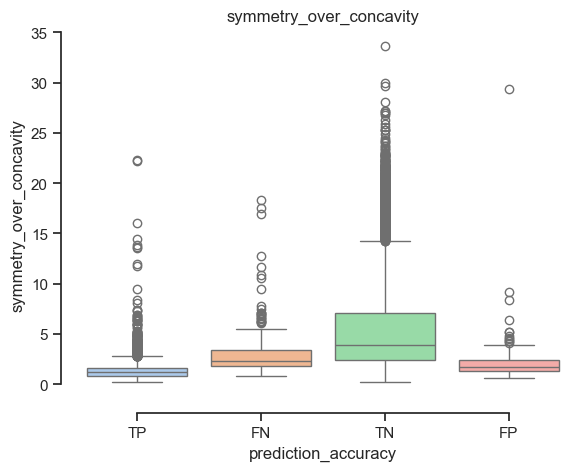

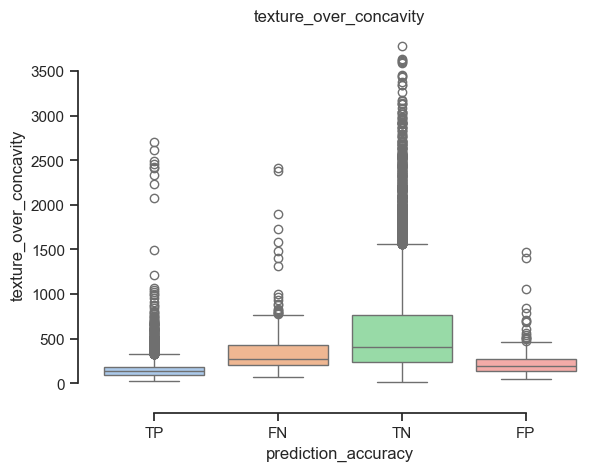

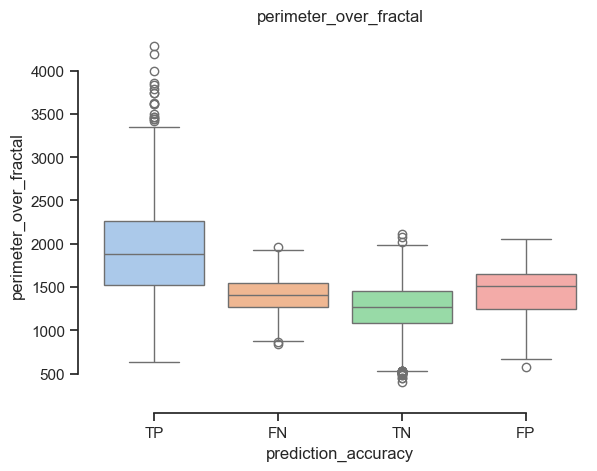

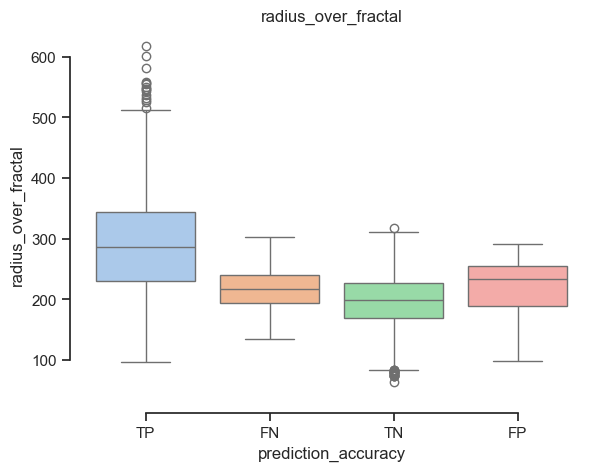

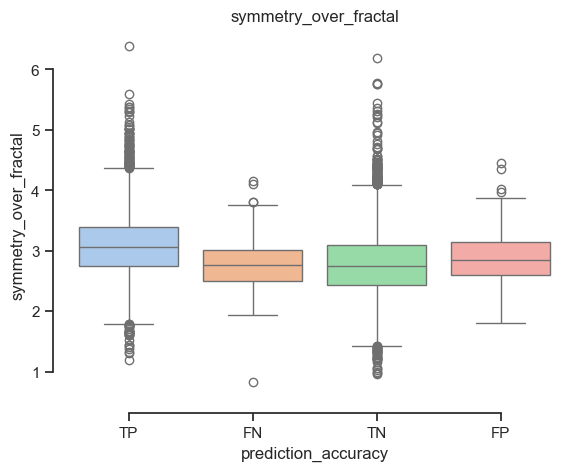

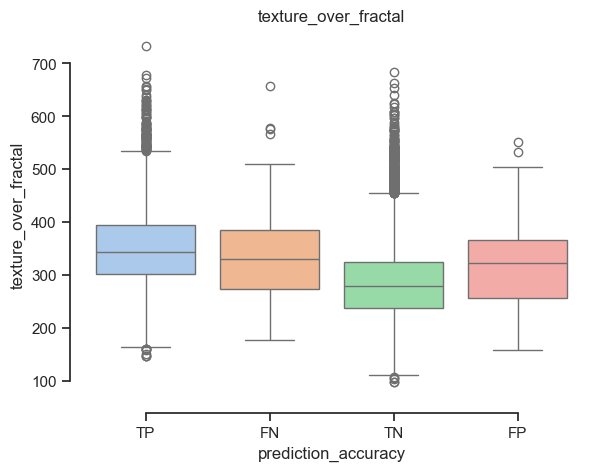

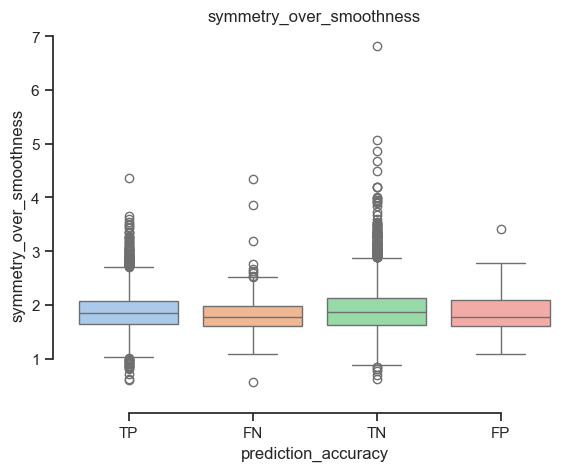

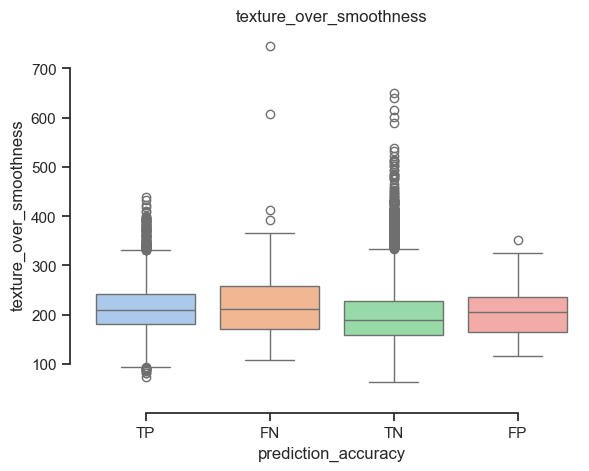

In [236]:
for new_col in predictions_wide.columns.tolist()[15:]:
    sns.boxplot(x='prediction_accuracy', y=new_col,
                hue='prediction_accuracy', data=predictions_wide)
    sns.despine(offset=10, trim=True)
    plt.title(new_col)
    plt.show()

# Creating and testing the new model

In [237]:
new_model_cols = predictions_wide.columns.tolist()[5:]

new_X_train_scaled = scaler.fit_transform(predictions_wide[new_model_cols])

new_model = MLPClassifier(random_state=55, hidden_layer_sizes=(hidden_layer_size7, hidden_layer_size5, hidden_layer_size3), 
                             activation='tanh', solver='adam', learning_rate='constant', max_iter=200)
new_model.fit(new_X_train_scaled, y_train)

new_predictions = new_model.predict(new_X_train_scaled)
new_prediction_probs = new_model.predict_proba(new_X_train_scaled)

print(f'Accuracy: {accuracy_score(y_train, new_predictions, normalize=True, sample_weight=None)}')
print(f'Avg CV accuracy: {np.mean(cross_val_score(new_model, new_X_train_scaled, y_train, cv=5))}')

Accuracy: 0.9515225761288064


C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Avg CV accuracy: 0.9362984659740288


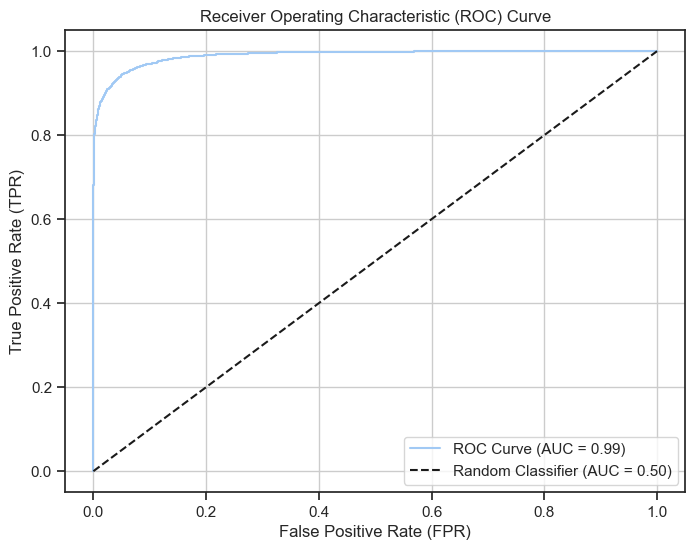

In [238]:
y_train_binary = [int(entry) for entry in np.where(y_train == 'M', 1, 0)]
new_prediction_probs_binary = [x[1] for x in new_prediction_probs]

fpr, tpr, thresholds = roc_curve(y_train_binary, new_prediction_probs_binary)

# 4. Calculate AUC Score
auc_score = roc_auc_score(y_train_binary, new_prediction_probs_binary)

# 5. Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

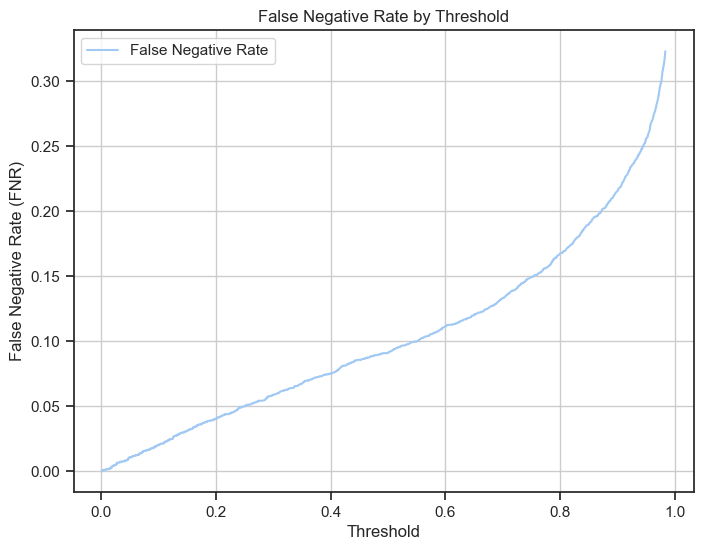

In [239]:
fpr, fnr, thresholds = det_curve(y_train_binary, new_prediction_probs_binary)
plt.figure(figsize=(8, 6))
plt.plot(thresholds, fnr, label='False Negative Rate')
plt.xlabel('Threshold')
plt.ylabel('False Negative Rate (FNR)')
plt.title('False Negative Rate by Threshold')
plt.grid(True)
plt.legend()
plt.show()

In [240]:
new_prediction_df = pd.DataFrame({'diagnosis': y_train, 
                              'prediction' : new_predictions,
                              'M_probability': [x[1] for x in new_prediction_probs],
                              'prediction_probability': [np.max([x[0], x[1]]) for x in new_prediction_probs]})

new_prediction_df['prediction_accuracy'] = 'TP'
new_prediction_df.loc[(new_prediction_df.diagnosis == 'B') & 
                      (new_prediction_df.prediction == 'B'), 'prediction_accuracy'] = 'TN'
new_prediction_df.loc[(new_prediction_df.diagnosis == 'B') & 
                      (new_prediction_df.prediction == 'M'), 'prediction_accuracy'] = 'FP'
new_prediction_df.loc[(new_prediction_df.diagnosis == 'M') & 
                      (new_prediction_df.prediction == 'B'), 'prediction_accuracy'] = 'FN'

new_predictions_wide = new_prediction_df.merge(predictions_wide[new_model_cols], 
                                               left_index=True, right_index=True, how='inner')

## Graphing feature importance

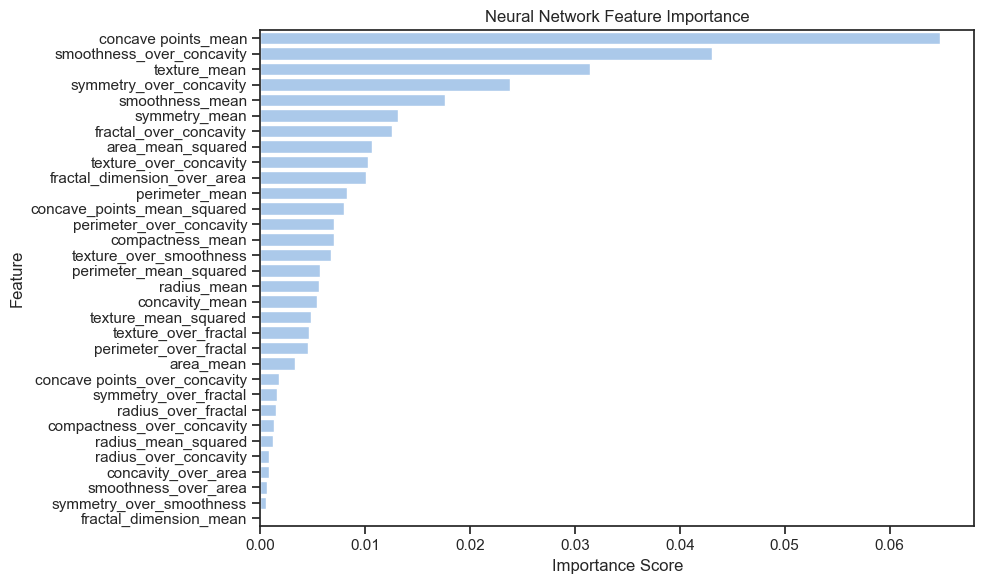

In [241]:
new_importances = permutation_importance(new_model, new_X_train_scaled, y_train, 
                                     n_repeats=10, random_state=55, scoring='accuracy')
new_feature_importance_df = pd.DataFrame({'feature': new_model_cols, 'importance': new_importances.importances_mean})\
    .sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=new_feature_importance_df)
plt.title('Neural Network Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Iterating over the model until we get best results

In [242]:
iterate_model_cols = new_feature_importance_df[
    (new_feature_importance_df.importance > 0.005) & 
#     ~(new_feature_importance_df.feature.str.contains('perimeter_')) & 
#     ~(new_feature_importance_df.feature.str.contains('radius_')) &
    ~(new_feature_importance_df.feature.isna())
].feature

iterate_X_train_scaled = scaler.fit_transform(predictions_wide[iterate_model_cols])
iterate_model = MLPClassifier(random_state=55, hidden_layer_sizes=(hidden_layer_size7, hidden_layer_size5, hidden_layer_size3), 
                             activation='tanh', solver='adam', learning_rate='constant', max_iter=200)
iterate_model.fit(iterate_X_train_scaled, y_train)

iterate_predictions = iterate_model.predict(iterate_X_train_scaled)
iterate_prediction_probs = iterate_model.predict_proba(iterate_X_train_scaled)

print(f'Accuracy: {accuracy_score(y_train, iterate_predictions, normalize=True, sample_weight=None)}')
print(f'Avg CV accuracy: {np.mean(cross_val_score(iterate_model, iterate_X_train_scaled, y_train, cv=5))}')

Accuracy: 0.9510850542527126


C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Avg CV accuracy: 0.9362112066407453


C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


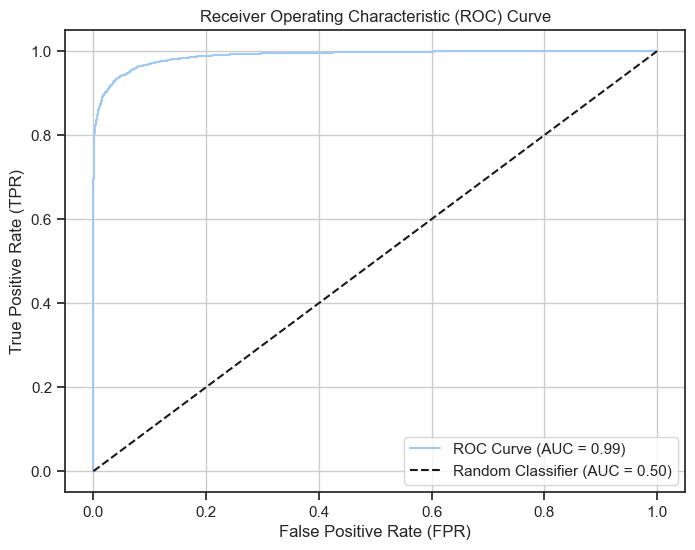

In [243]:
y_train_binary = [int(entry) for entry in np.where(y_train == 'M', 1, 0)]
iterate_prediction_probs_binary = [x[1] for x in iterate_prediction_probs]

fpr, tpr, thresholds = roc_curve(y_train_binary, iterate_prediction_probs_binary)

# 4. Calculate AUC Score
auc_score = roc_auc_score(y_train_binary, iterate_prediction_probs_binary)

# 5. Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

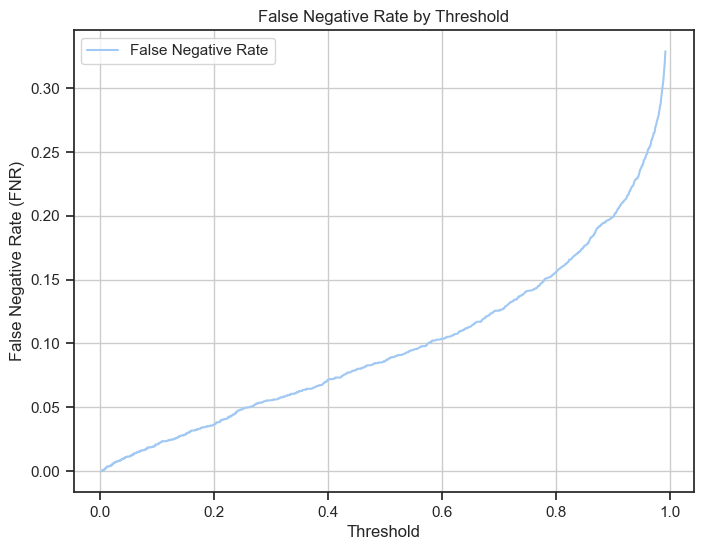

In [244]:
fpr, fnr, thresholds = det_curve(y_train_binary, iterate_prediction_probs_binary)
plt.figure(figsize=(8, 6))
plt.plot(thresholds, fnr, label='False Negative Rate')
plt.xlabel('Threshold')
plt.ylabel('False Negative Rate (FNR)')
plt.title('False Negative Rate by Threshold')
plt.grid(True)
plt.legend()
plt.show()

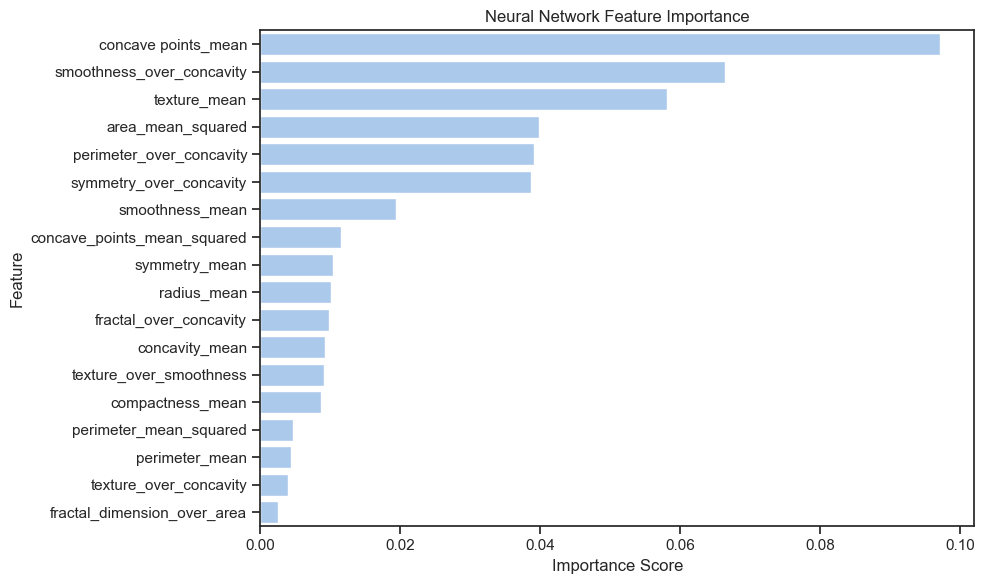

In [245]:
iterate_importances = permutation_importance(iterate_model, iterate_X_train_scaled, y_train, 
                                     n_repeats=10, random_state=55, scoring='accuracy')
iterate_feature_importance_df = pd.DataFrame({'feature': iterate_model_cols, 
                                              'importance': iterate_importances.importances_mean})\
    .sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=iterate_feature_importance_df)
plt.title('Neural Network Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## GridsearchCV again

In [267]:
base_model = MLPClassifier(random_state=55)

hidden_layer_size1 = round(len(iterate_model_cols)*2)
hidden_layer_size2 = round(len(iterate_model_cols)*1.75)
hidden_layer_size3 = round(len(iterate_model_cols)*1.5)
hidden_layer_size4 = round(len(iterate_model_cols)*1.2)
hidden_layer_size5 = round(len(iterate_model_cols)*3/4)
hidden_layer_size6 = round(len(iterate_model_cols)*2/3)
hidden_layer_size7 = round(len(iterate_model_cols)*0.5)

param_grid = {
    'hidden_layer_sizes': [(hidden_layer_size1, hidden_layer_size3),
                          (hidden_layer_size2, hidden_layer_size4),
                          (hidden_layer_size3, hidden_layer_size5),
                          (hidden_layer_size4, hidden_layer_size6),
                          (hidden_layer_size5, hidden_layer_size7)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'lbfgs'],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [100, 200, 300, 400, 500,]
}

grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(iterate_X_train_scaled, y_train)

C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=5, estimator=MLPClassifier(random_state=55), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'hidden_layer_sizes': [(36, 27), (32, 22), (27, 14),
                                                (22, 12), (14, 9)],
                         'learning_rate': ['constant', 'adaptive'],
                         'max_iter': [100, 200, 300, 400, 500],
                         'solver': ['adam', 'lbfgs']},
             scoring='accuracy')

In [268]:
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values('mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_fit_time', 'param_hidden_layer_sizes']]

mean_test_score  mean_fit_time param_hidden_layer_sizes
0           0.941374       3.701796                 (36, 27)
10          0.941374       5.295703                 (36, 27)
162         0.939448       7.965661                 (22, 12)
172         0.939448       6.024227                 (22, 12)
22          0.939186       6.339996                 (32, 22)
32          0.939186       6.092892                 (32, 22)
38          0.939099       6.779616                 (32, 22)
24          0.939099       6.878772                 (32, 22)
34          0.939099       8.312205                 (32, 22)
36          0.939099       7.434185                 (32, 22)
28          0.939099       6.698799                 (32, 22)
26          0.939099       6.398449                 (32, 22)
186         0.938311      11.567253                  (14, 9)
196         0.938311      10.489018                  (14, 9)
194         0.938311       9.788333                  (14, 9)
184         0.938311      10.883625                  (14, 9)
168         0.938311      11.380442                 (22, 12)
178         0.938311      13.572053                 (22, 12)
152         0.938223       6.741105                 (27, 14)
142         0.938223       6.869409                 (27, 14)
154         0.938136       9.290186                 (27, 14)
144         0.938136      10.013623                 (27, 14)
136         0.938049      11.816718                 (32, 22)
126         0.938049      12.828164                 (32, 22)
166         0.937961      11.572867                 (22, 12)
176         0.937961      12.145105                 (22, 12)
174         0.937961       9.276567                 (22, 12)
164         0.937961       9.412838                 (22, 12)
83          0.937873       1.747426                  (14, 9)
93          0.937873       2.033816                  (14, 9)
102         0.937436       7.936784                 (36, 27)
112         0.937436       7.799759                 (36, 27)
18          0.937349       7.185818                 (36, 27)
6           0.937349       7.407715                 (36, 27)
14          0.937349       6.358565                 (36, 27)
16          0.937349       5.889974                 (36, 27)
4           0.937349       7.869900                 (36, 27)
8           0.937349       7.626113                 (36, 27)
1           0.937349       2.787192                 (36, 27)
11          0.937349       4.523845                 (36, 27)
124         0.937087      11.305316                 (32, 22)
134         0.937087      10.081071                 (32, 22)
100         0.937086       3.582453                 (36, 27)
110         0.937086       3.982543                 (36, 27)
146         0.937086      12.840390                 (27, 14)
156         0.937086      10.855135                 (27, 14)
171         0.936736       2.619829                 (22, 12)
161         0.936736       3.484773                 (22, 12)
95          0.936735       2.659610                  (14, 9)
85          0.936735       2.567145                  (14, 9)
188         0.936561      13.947943                  (14, 9)
198         0.936561      10.261206                  (14, 9)
148         0.936474      12.327745                 (27, 14)
158         0.936474      13.482640                 (27, 14)
111         0.936387       6.641297                 (36, 27)
101         0.936387       4.490974                 (36, 27)
60          0.936386       3.232607                 (22, 12)
70          0.936386       3.657936                 (22, 12)
121         0.936298       6.657887                 (32, 22)
131         0.936298       6.208371                 (32, 22)
12          0.936211       6.629284                 (36, 27)
2           0.936211       5.935603                 (36, 27)
87          0.936210       3.712161                  (14, 9)
97          0.936210       3.667097                  (14, 9)
153         0.936036       4.698632     

In [269]:
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values('mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_fit_time', 'param_activation', 'param_hidden_layer_sizes', 
    'param_solver', 'param_learning_rate', 'param_max_iter']]

mean_test_score  mean_fit_time param_activation param_hidden_layer_sizes  \
0           0.941374       3.701796             relu                 (36, 27)   
10          0.941374       5.295703             relu                 (36, 27)   
162         0.939448       7.965661             tanh                 (22, 12)   
172         0.939448       6.024227             tanh                 (22, 12)   
22          0.939186       6.339996             relu                 (32, 22)   
32          0.939186       6.092892             relu                 (32, 22)   
38          0.939099       6.779616             relu                 (32, 22)   
24          0.939099       6.878772             relu                 (32, 22)   
34          0.939099       8.312205             relu                 (32, 22)   
36          0.939099       7.434185             relu                 (32, 22)   
28          0.939099       6.698799             relu                 (32, 22)   
26          0.939099       6.398449             relu                 (32, 22)   
186         0.938311      11.567253             tanh                  (14, 9)   
196         0.938311      10.489018             tanh                  (14, 9)   
194         0.938311       9.788333             tanh                  (14, 9)   
184         0.938311      10.883625             tanh                  (14, 9)   
168         0.938311      11.380442             tanh                 (22, 12)   
178         0.938311      13.572053             tanh                 (22, 12)   
152         0.938223       6.741105             tanh                 (27, 14)   
142         0.938223       6.869409             tanh                 (27, 14)   
154         0.938136       9.290186             tanh                 (27, 14)   
144         0.938136      10.013623             tanh                 (27, 14)   
136         0.938049      11.816718             tanh                 (32, 22)   
126         0.938049      12.828164             tanh                 (32, 22)   
166         0.937961      11.572867             tanh                 (22, 12)   
176         0.937961      12.145105             tanh                 (22, 12)   
174         0.937961       9.276567             tanh                 (22, 12)   
164         0.937961       9.412838             tanh                 (22, 12)   
83          0.937873       1.747426             relu                  (14, 9)   
93          0.937873       2.033816             relu                  (14, 9)   
102         0.937436       7.936784             tanh                 (36, 27)   
112         0.937436       7.799759             tanh                 (36, 27)   
18          0.937349       7.185818             relu                 (36, 27)   
6           0.937349       7.407715             relu                 (36, 27)   
14          0.937349       6.358565             relu                 (36, 27)   
16          0.937349       5.889974             relu                 (36, 27)   
4           0.937349       7.869900             relu                 (36, 27)   
8           0.937349       7.626113             relu                 (36, 27)   
1           0.937349       2.787192             relu                 (36, 27)   
11          0.937349       4.523845             relu                 (36, 27)   
124         0.937087      11.305316             tanh                 (32, 22)   
134         0.937087      10.081071             tanh                 (32, 22)   
100         0.937086       3.582453             tanh                 (36, 27)   
110         0.937086       3.982543             tanh                 (36, 27)   
146         0.937086      12.840390             tanh                 (27, 14)   
156         0.937086      10.855135             tanh                 (27, 14)   
171         0.936736       2.619829             tanh                 (22, 12)   
161         0.936736       3.484773             tanh                 (22, 12)   
95          0.936735       2.659610 

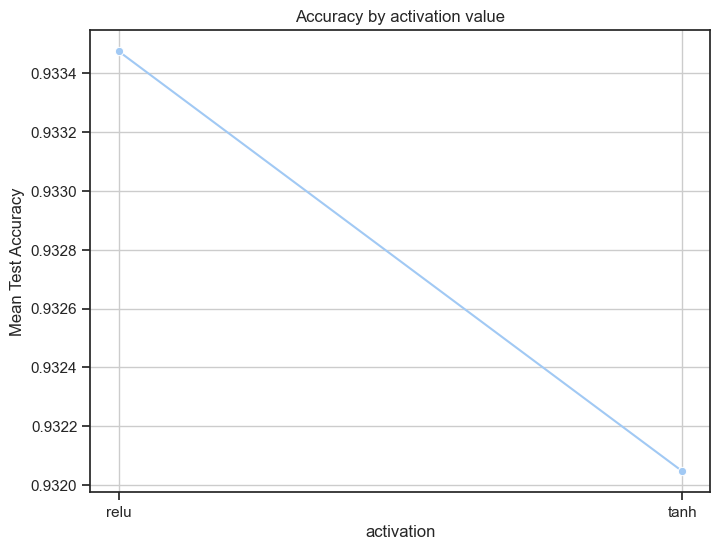

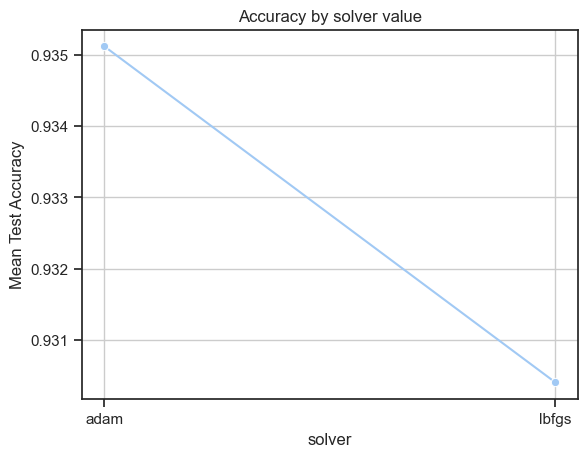

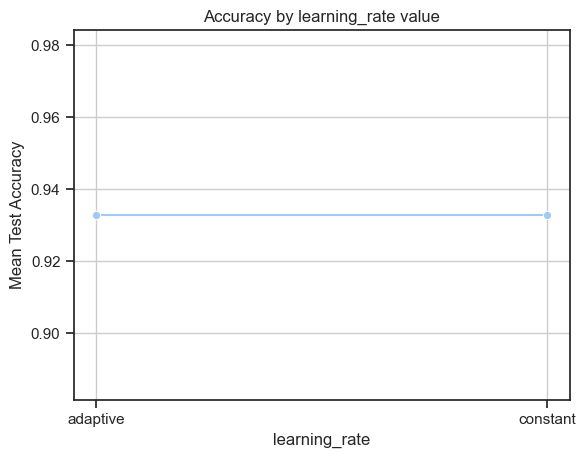

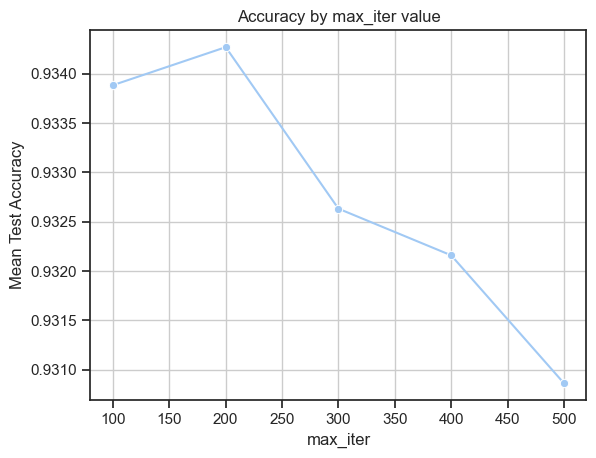

In [270]:
plt.figure(figsize=(8, 6))

for param in param_grid.keys():
    if param != 'hidden_layer_sizes':
        sns.lineplot(data=results.groupby('param_' + param, as_index=False).agg({'mean_test_score':'mean'}), 
                     x='param_' + param, y='mean_test_score', marker='o')
        plt.title('Accuracy by ' + param + ' value')
        plt.xlabel(param)
        plt.ylabel('Mean Test Accuracy')
        plt.grid(True)
        plt.show()

## Fiddling with hidden layer sizes

In [271]:
base_model = MLPClassifier(random_state=55, activation='tanh', solver='adam', learning_rate='constant', max_iter=200)

hidden_layer_size1 = round(len(iterate_model_cols)*2/3)
hidden_layer_size2 = round(len(iterate_model_cols)*3/4)
hidden_layer_size3 = round(len(iterate_model_cols))
hidden_layer_size4 = round(len(iterate_model_cols)*1.2)
hidden_layer_size5 = round(len(iterate_model_cols)*1.5)
hidden_layer_size6 = round(len(iterate_model_cols)*2)
hidden_layer_size7 = round(len(iterate_model_cols)*2.5)
hidden_layer_size8 = round(len(iterate_model_cols)*5)
hidden_layer_size9 = round(len(iterate_model_cols)*10)

param_grid = {
    'hidden_layer_sizes': [
        (hidden_layer_size1),
        (hidden_layer_size2),
        (hidden_layer_size3),
        (hidden_layer_size4),
        (hidden_layer_size5),
        (hidden_layer_size6),
        (hidden_layer_size7),
        (hidden_layer_size8),
        (hidden_layer_size9),
    ],
}

grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(activation='tanh', random_state=55),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [12, 14, 18, 22, 27, 36, 45, 90,
                                                180]},
             scoring='accuracy')

In [272]:
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values('mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_fit_time', 'param_hidden_layer_sizes']]

mean_test_score  mean_fit_time  param_hidden_layer_sizes
5         0.921508       2.018135                        36
3         0.920896       2.751414                        22
1         0.920809       2.437061                        14
4         0.920809       2.171063                        27
8         0.920720       3.847612                       180
2         0.920371       2.384657                        18
0         0.920109       2.967543                        12
7         0.919758       3.557159                        90
6         0.919058       2.003167                        45

In [273]:
base_model = MLPClassifier(random_state=55, activation='relu', solver='adam', learning_rate='constant', max_iter=200)

hidden_layer_size1 = round(len(iterate_model_cols)*2/3)
hidden_layer_size2 = round(len(iterate_model_cols)*3/4)
hidden_layer_size3 = round(len(iterate_model_cols))
hidden_layer_size4 = round(len(iterate_model_cols)*1.2)
hidden_layer_size5 = round(len(iterate_model_cols)*1.5)
hidden_layer_size6 = round(len(iterate_model_cols)*2)
hidden_layer_size7 = round(len(iterate_model_cols)*2.5)
hidden_layer_size8 = round(len(iterate_model_cols)*5)
hidden_layer_size9 = round(len(iterate_model_cols)*10)

param_grid = {
    'hidden_layer_sizes': [
        (hidden_layer_size3, hidden_layer_size1),
        (hidden_layer_size4, hidden_layer_size2),
        (hidden_layer_size5, hidden_layer_size3),
        (hidden_layer_size6, hidden_layer_size4),
        (hidden_layer_size7, hidden_layer_size5),
        (hidden_layer_size8, hidden_layer_size7),
        (hidden_layer_size9, hidden_layer_size8),
    ],
}

grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(random_state=55), n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(18, 12), (22, 14), (27, 18),
                                                (36, 22), (45, 27), (90, 45),
                                                (180, 90)]},
             scoring='accuracy')

In [274]:
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values('mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_fit_time', 'param_hidden_layer_sizes']]

mean_test_score  mean_fit_time param_hidden_layer_sizes
1         0.937174       4.710695                 (22, 14)
2         0.936649       5.751042                 (27, 18)
0         0.935072       6.603312                 (18, 12)
4         0.933586       7.269306                 (45, 27)
3         0.932885       5.669079                 (36, 22)
5         0.930698      10.448056                 (90, 45)
6         0.928860      25.909723                (180, 90)

In [275]:
base_model = MLPClassifier(random_state=55, activation='relu', solver='adam', learning_rate='constant', max_iter=200)

hidden_layer_size1 = round(len(iterate_model_cols)*2/3)
hidden_layer_size2 = round(len(iterate_model_cols)*3/4)
hidden_layer_size3 = round(len(iterate_model_cols))
hidden_layer_size4 = round(len(iterate_model_cols)*1.2)
hidden_layer_size5 = round(len(iterate_model_cols)*1.5)
hidden_layer_size6 = round(len(iterate_model_cols)*2)
hidden_layer_size7 = round(len(iterate_model_cols)*2.5)
hidden_layer_size8 = round(len(iterate_model_cols)*5)
hidden_layer_size9 = round(len(iterate_model_cols)*10)

param_grid = {
    'hidden_layer_sizes': [
        (hidden_layer_size5, hidden_layer_size3, hidden_layer_size1),
        (hidden_layer_size6, hidden_layer_size4, hidden_layer_size2),
        (hidden_layer_size7, hidden_layer_size5, hidden_layer_size3),
        (hidden_layer_size7, hidden_layer_size6, hidden_layer_size4),
        (hidden_layer_size8, hidden_layer_size7, hidden_layer_size5),
        (hidden_layer_size9, hidden_layer_size8, hidden_layer_size7),
    ],
}

grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(random_state=55), n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(27, 18, 12), (36, 22, 14),
                                                (45, 27, 18), (45, 36, 22),
                                                (90, 45, 27), (180, 90, 45)]},
             scoring='accuracy')

In [276]:
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values('mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_fit_time', 'param_hidden_layer_sizes']]

mean_test_score  mean_fit_time param_hidden_layer_sizes
0         0.935686       6.564874             (27, 18, 12)
1         0.933847       5.411261             (36, 22, 14)
4         0.933674      14.376805             (90, 45, 27)
3         0.932799       8.573861             (45, 36, 22)
2         0.930261       7.758469             (45, 27, 18)
5         0.915645      28.301243            (180, 90, 45)

In [277]:
base_model = MLPClassifier(random_state=55, activation='relu', solver='adam', learning_rate='constant', max_iter=200)

hidden_layer_size1 = round(len(iterate_model_cols)*2/3)
hidden_layer_size2 = round(len(iterate_model_cols)*3/4)
hidden_layer_size3 = round(len(iterate_model_cols))
hidden_layer_size4 = round(len(iterate_model_cols)*1.2)
hidden_layer_size5 = round(len(iterate_model_cols)*1.5)
hidden_layer_size6 = round(len(iterate_model_cols)*2)
hidden_layer_size7 = round(len(iterate_model_cols)*2.5)
hidden_layer_size8 = round(len(iterate_model_cols)*5)
hidden_layer_size9 = round(len(iterate_model_cols)*10)

param_grid = {
    'hidden_layer_sizes': [
        (hidden_layer_size7, hidden_layer_size5, hidden_layer_size3, hidden_layer_size1),
        (hidden_layer_size8, hidden_layer_size6, hidden_layer_size4, hidden_layer_size2),
        (hidden_layer_size8, hidden_layer_size7, hidden_layer_size5, hidden_layer_size3),
        (hidden_layer_size9, hidden_layer_size7, hidden_layer_size6, hidden_layer_size4),
    ],
}

grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(random_state=55), n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(45, 27, 18, 12),
                                                (90, 36, 22, 14),
                                                (90, 45, 27, 18),
                                                (180, 45, 36, 22)]},
             scoring='accuracy')

In [278]:
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values('mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_fit_time', 'param_hidden_layer_sizes']]

mean_test_score  mean_fit_time param_hidden_layer_sizes
1         0.934025      13.347277         (90, 36, 22, 14)
0         0.931660       8.102180         (45, 27, 18, 12)
2         0.923523      15.783052         (90, 45, 27, 18)
3         0.920634      20.671951        (180, 45, 36, 22)

In [279]:
hidden_layer_size1 = round(len(iterate_model_cols)*2/3)
hidden_layer_size2 = round(len(iterate_model_cols)*3/4)
hidden_layer_size3 = round(len(iterate_model_cols))
hidden_layer_size4 = round(len(iterate_model_cols)*1.2)
hidden_layer_size5 = round(len(iterate_model_cols)*1.5)
hidden_layer_size6 = round(len(iterate_model_cols)*2)
hidden_layer_size7 = round(len(iterate_model_cols)*2.5)
hidden_layer_size8 = round(len(iterate_model_cols)*5)
hidden_layer_size9 = round(len(iterate_model_cols)*10)

base_model = MLPClassifier(random_state=55, 
                           hidden_layer_sizes=(hidden_layer_size4, hidden_layer_size2, hidden_layer_size3))

param_grid = {
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'lbfgs'],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [100, 200, 300, 400, 500,]
}

grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=MLPClassifier(hidden_layer_sizes=(22, 14, 18),
                                     random_state=55),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'learning_rate': ['constant', 'adaptive'],
                         'max_iter': [100, 200, 300, 400, 500],
                         'solver': ['adam', 'lbfgs']},
             scoring='accuracy')

In [281]:
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values('mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_fit_time', 'param_activation', 
    'param_solver', 'param_learning_rate', 'param_max_iter']]

mean_test_score  mean_fit_time param_activation param_solver  \
2          0.938749       7.234505             relu         adam   
12         0.938749       6.571159             relu         adam   
6          0.938136       7.550644             relu         adam   
4          0.938136       7.396489             relu         adam   
16         0.938136       9.169749             relu         adam   
14         0.938136       7.832233             relu         adam   
8          0.938136       7.623101             relu         adam   
18         0.938136       9.687522             relu         adam   
0          0.937085       4.522561             relu         adam   
10         0.937085       4.693599             relu         adam   
34         0.935249      17.708310             tanh         adam   
24         0.935249      16.397345             tanh         adam   
22         0.934373      10.226172             tanh         adam   
32         0.934373      11.559400             tanh         adam   
33         0.933235       8.430953             tanh        lbfgs   
23         0.933235       8.554122             tanh        lbfgs   
25         0.932448      14.028839             tanh        lbfgs   
35         0.932448      12.345714             tanh        lbfgs   
36         0.931923      20.737595             tanh         adam   
26         0.931923      21.764291             tanh         adam   
29         0.931573      22.558704             tanh        lbfgs   
39         0.931573      19.514415             tanh        lbfgs   
37         0.931311      17.325635             tanh        lbfgs   
27         0.931311      16.449435             tanh        lbfgs   
30         0.930437       5.916215             tanh         adam   
20         0.930437       6.252007             tanh         adam   
38         0.929473      28.286783             tanh         adam   
28         0.929473      26.687339             tanh         adam   
21         0.928597       5.427066             tanh        lbfgs   
31         0.928597       5.202082             tanh        lbfgs   
11         0.927985       3.267817             relu        lbfgs   
1          0.927985       2.239222             relu        lbfgs   
7          0.923784      11.281322             relu        lbfgs   
17         0.923784      12.359034             relu        lbfgs   
15         0.923259       9.155878             relu        lbfgs   
5          0.923259       8.764212             relu        lbfgs   
19         0.923172      17.919741             relu        lbfgs   
9          0.923172      14.906111             relu        lbfgs   
3          0.919759       4.553802             relu        lbfgs   
13         0.919759       4.956016             relu        lbfgs   

   param_learning_rate  param_max_iter  
2             constant             200  
12            adaptive             200  
6             constant             400  
4             constant             300  
16            adaptive             400  
14            adaptive             300  
8             constant             500  
18            adaptive             500  
0             constant             100  
10            adaptive             100  
34            adaptive             300  
24            constant             300  
22            constant             200  
32            adaptive             200  
33            adaptive             200  
23            constant             200  
25            constant             300  
35            adaptive             300  
36            adaptive             400  
26            constant             400  
29            constant             500  
39            adaptive             500  
37            adaptive             400  
27            constant             400  
30            adaptive             100  
20            constant             100  
38            adaptive             500  
28            constant             500  
21            constant    

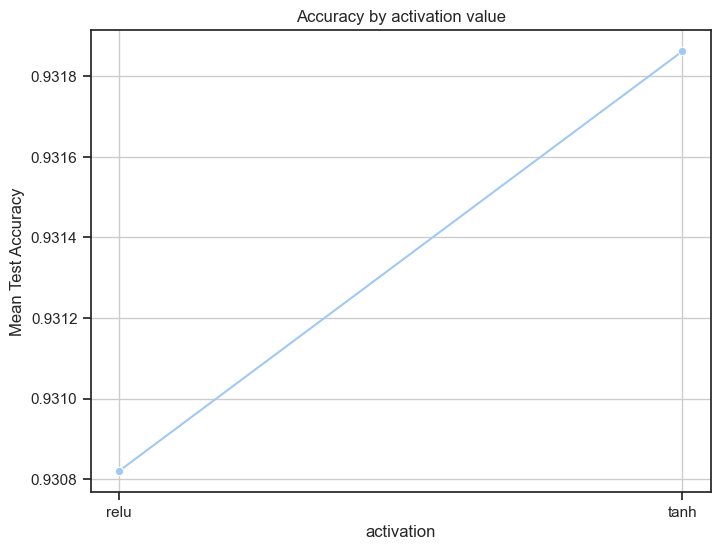

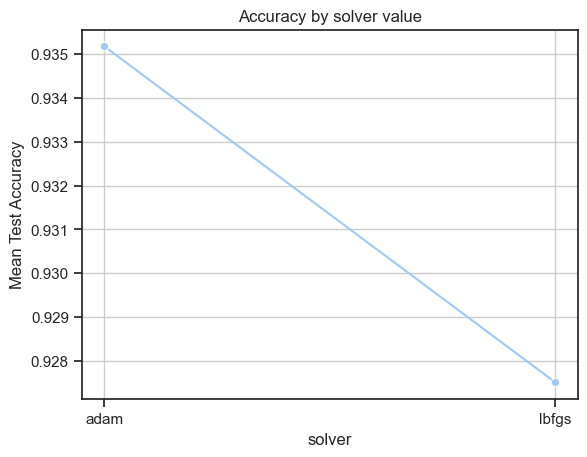

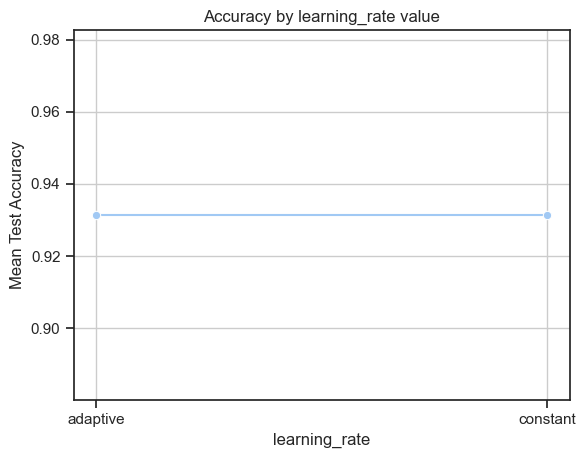

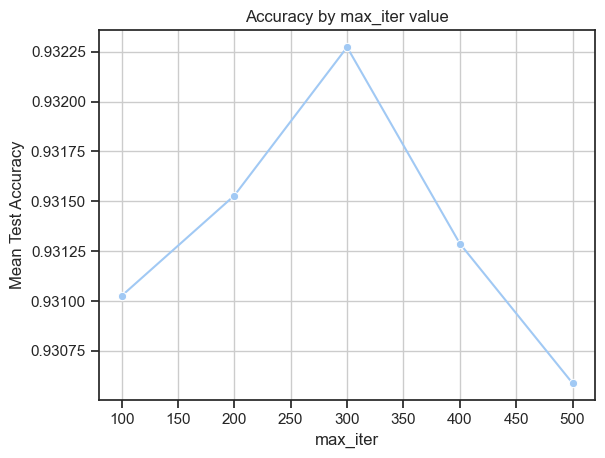

In [282]:
plt.figure(figsize=(8, 6))

for param in param_grid.keys():
    if param != 'hidden_layer_sizes':
        sns.lineplot(data=results.groupby('param_' + param, as_index=False).agg({'mean_test_score':'mean'}), 
                     x='param_' + param, y='mean_test_score', marker='o')
        plt.title('Accuracy by ' + param + ' value')
        plt.xlabel(param)
        plt.ylabel('Mean Test Accuracy')
        plt.grid(True)
        plt.show()

# Settling on the final model and testing

In [283]:
X_test['area_mean_squared'] = X_test.area_mean**2
X_test['concave_points_mean_squared'] = X_test['concave points_mean']**2
X_test['perimeter_mean_squared'] = X_test.perimeter_mean**2
X_test['radius_mean_squared'] = X_test.radius_mean**2
X_test['texture_mean_squared'] = X_test.texture_mean**2

X_test['concavity_over_area'] = X_test.concavity_mean/X_test.area_mean
X_test['fractal_dimension_over_area'] = X_test.fractal_dimension_mean/X_test.area_mean
X_test['smoothness_over_area'] = X_test.smoothness_mean/X_test.area_mean

X_test['compactness_over_concavity'] = X_test.compactness_mean/(X_test.concavity_mean + 0.01)
X_test['concave points_over_concavity'] = X_test['concave points_mean']/(
    X_test.concavity_mean + 0.01)
X_test['fractal_over_concavity'] = X_test.fractal_dimension_mean/(X_test.concavity_mean + 0.01)
X_test['perimeter_over_concavity'] = X_test.perimeter_mean/(X_test.concavity_mean + 0.01)
X_test['radius_over_concavity'] = X_test.radius_mean/(X_test.concavity_mean + 0.01)
X_test['smoothness_over_concavity'] = X_test.smoothness_mean/(X_test.concavity_mean + 0.01)
X_test['symmetry_over_concavity'] = X_test.symmetry_mean/(X_test.concavity_mean + 0.01)
X_test['texture_over_concavity'] = X_test.texture_mean/(X_test.concavity_mean + 0.01)

X_test['perimeter_over_fractal'] = X_test.perimeter_mean/X_test.fractal_dimension_mean
X_test['radius_over_fractal'] = X_test.radius_mean/X_test.fractal_dimension_mean
X_test['symmetry_over_fractal'] = X_test.symmetry_mean/X_test.fractal_dimension_mean
X_test['texture_over_fractal'] = X_test.texture_mean/X_test.fractal_dimension_mean

X_test['symmetry_over_smoothness'] = X_test.symmetry_mean/X_test.smoothness_mean
X_test['texture_over_smoothness'] = X_test.texture_mean/X_test.smoothness_mean

In [284]:
final_model_cols = iterate_model_cols

final_X_train_scaled = scaler.fit_transform(predictions_wide[final_model_cols])
final_X_test_scaled = scaler.fit_transform(X_test[final_model_cols])

final_model = MLPClassifier(random_state=55, hidden_layer_sizes=(hidden_layer_size4, hidden_layer_size2), 
                            activation='relu', solver='adam', learning_rate='constant', max_iter=300)
final_model.fit(final_X_train_scaled, y_train)

final_predictions = final_model.predict(final_X_train_scaled)
final_prediction_probs = final_model.predict_proba(final_X_train_scaled)

print(f'Accuracy: {accuracy_score(y_train, final_predictions, normalize=True, sample_weight=None)}')
print(f'Avg CV accuracy: {np.mean(cross_val_score(final_model, final_X_train_scaled, y_train, cv=5))}')

Accuracy: 0.9503850192509625
Avg CV accuracy: 0.9366480776336218


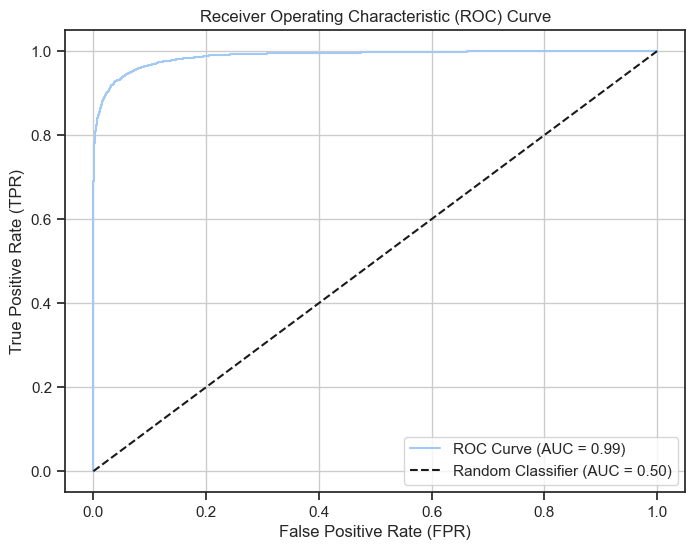

In [285]:
y_train_binary = [int(entry) for entry in np.where(y_train == 'M', 1, 0)]
final_prediction_probs_binary = [x[1] for x in final_prediction_probs]

fpr, tpr, thresholds = roc_curve(y_train_binary, final_prediction_probs_binary)

# 4. Calculate AUC Score
auc_score = roc_auc_score(y_train_binary, final_prediction_probs_binary)

# 5. Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

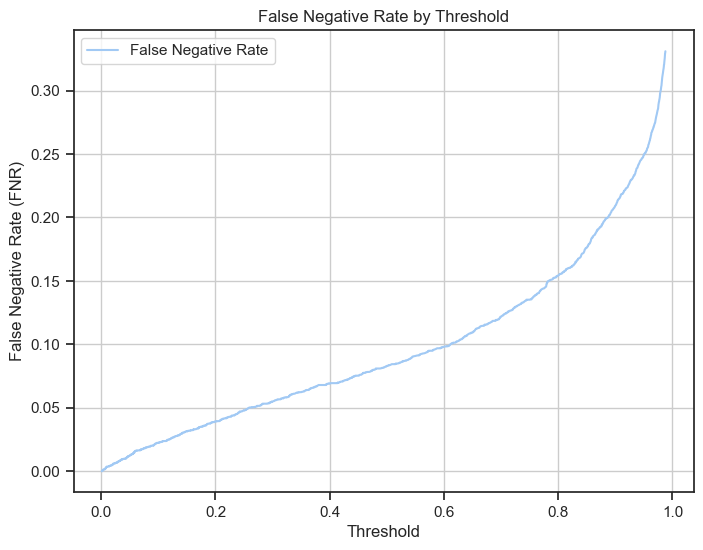

In [286]:
fpr, fnr, thresholds = det_curve(y_train_binary, final_prediction_probs_binary)
plt.figure(figsize=(8, 6))
plt.plot(thresholds, fnr, label='False Negative Rate')
plt.xlabel('Threshold')
plt.ylabel('False Negative Rate (FNR)')
plt.title('False Negative Rate by Threshold')
plt.grid(True)
plt.legend()
plt.show()

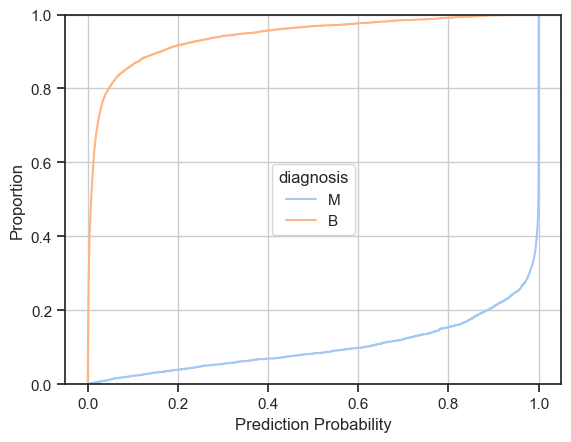

In [287]:
final_prediction_df = pd.DataFrame({'diagnosis': y_train, 
                                    'prediction' : final_predictions,
                                    'M_probability': [x[1] for x in final_prediction_probs],
                                    'prediction_probability': [np.max([x[0], x[1]]) for x in final_prediction_probs]})

sns.ecdfplot(data=final_prediction_df,
             x='M_probability', hue='diagnosis')
plt.xlabel('Prediction Probability')
plt.grid(True)
plt.show()

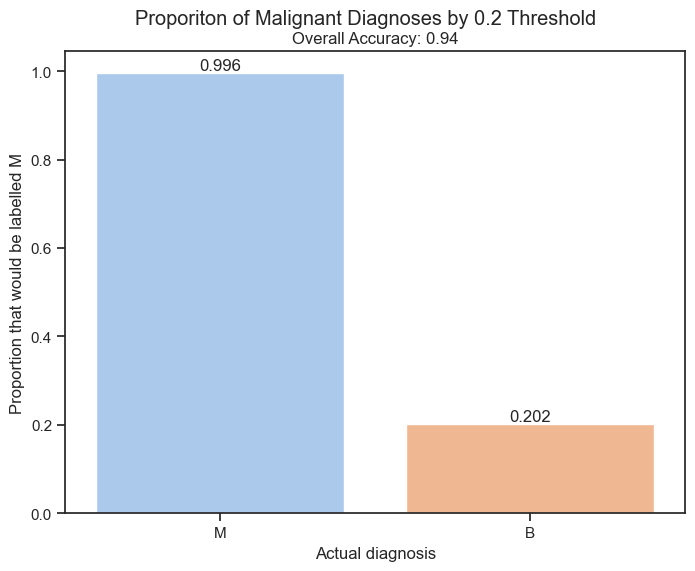

In [288]:
final_test_predictions = final_model.predict(final_X_test_scaled)
final_test_prediction_probs = final_model.predict_proba(final_X_test_scaled)

final_test_prediction_df = pd.DataFrame({'diagnosis': y_test, 
                                    'prediction' : final_test_predictions,
                                    'M_probability': [x[1] for x in final_test_prediction_probs],
                                    'prediction_probability': [np.max([x[0], x[1]]) for x in final_test_prediction_probs],
                                    'is_above_20_percent': [x[1] > 0.05 for x in final_test_prediction_probs]})

fig, ax = plt.subplots(figsize=(8, 6))
bars = sns.barplot(data=final_test_prediction_df, x='diagnosis', 
                   y='is_above_20_percent', hue='diagnosis', ax=ax, errorbar=None)
ax.bar_label(bars.containers[0], fmt='%.3f') # fmt can format the number, e.g., '%.2f' for two decimal places
ax.bar_label(bars.containers[1], fmt='%.3f') # fmt can format the number, e.g., '%.2f' for two decimal places
plt.xlabel('Actual diagnosis')
plt.ylabel('Proportion that would be labelled M')
plt.suptitle('Proporiton of Malignant Diagnoses by 0.2 Threshold', y=0.95)
plt.title(f'Overall Accuracy: \
{round(accuracy_score(y_test, final_test_predictions, normalize=True, sample_weight=None), 2)}')
plt.show()

# Recreating these results with the original dataset

In [289]:
cancer_dataset = pd.read_csv('Breast_cancer_dataset.csv')\
    .drop('Unnamed: 32', axis=1)
cancer_dataset

id diagnosis  radius_mean  texture_mean  perimeter_mean  \
0       842302         M       17.990         10.38          122.80   
1       842517         M       20.570         17.77          132.90   
2     84300903         M       19.690         21.25          130.00   
3     84348301         M       11.420         20.38           77.58   
4     84358402         M       20.290         14.34          135.10   
5       843786         M       12.450         15.70           82.57   
6       844359         M       18.250         19.98          119.60   
7     84458202         M       13.710         20.83           90.20   
8       844981         M       13.000         21.82           87.50   
9     84501001         M       12.460         24.04           83.97   
10      845636         M       16.020         23.24          102.70   
11    84610002         M       15.780         17.89          103.60   
12      846226         M       19.170         24.80          132.40   
13      846381         M       15.850         23.95          103.70   
14    84667401         M       13.730         22.61           93.60   
15    84799002         M       14.540         27.54           96.73   
16      848406         M       14.680         20.13           94.74   
17    84862001         M       16.130         20.68          108.10   
18      849014         M       19.810         22.15          130.00   
19     8510426         B       13.540         14.36           87.46   
20     8510653         B       13.080         15.71           85.63   
21     8510824         B        9.504         12.44           60.34   
22     8511133         M       15.340         14.26          102.50   
23      851509         M       21.160         23.04          137.20   
24      852552         M       16.650         21.38          110.00   
25      852631         M       17.140         16.40          116.00   
26      852763         M       14.580         21.53           97.41   
27      852781         M       18.610         20.25          122.10   
28      852973         M       15.300         25.27          102.40   
29      853201         M       17.570         15.05          115.00   
30      853401         M       18.630         25.11          124.80   
31      853612         M       11.840         18.70           77.93   
32    85382601         M       17.020         23.98          112.80   
33      854002         M       19.270         26.47          127.90   
34      854039         M       16.130         17.88          107.00   
35      854253         M       16.740         21.59          110.10   
36      854268         M       14.250         21.72           93.63   
37      854941         B       13.030         18.42           82.61   
38      855133         M       14.990         25.20           95.54   
39      855138         M       13.480         20.82           88.40   
40      855167         M       13.440         21.58           86.18   
41      855563         M       10.950         21.35           71.90   
42      855625         M       19.070         24.81          128.30   
43      856106         M       13.280         20.28           87.32   
44    85638502         M       13.170         21.81           85.42   
45      857010         M       18.650         17.60          123.70   
46    85713702         B        8.196         16.84           51.71   
47       85715         M       13.170         18.66           85.98   
48      857155         B       12.050         14.63           78.04   
49      857156         B       13.490         22.30           86.91   
50      857343         B       11.760         21.60           74.72   
51      857373         B       13.640         16.34           87.21   
52      857374         B       11.940         18.24           75.71   
53      857392         M       18.220         18.70          120.30   
54      857438         M       15.100         22.02           97.26   
55    85759902         B       11.52

In [290]:
cancer_dataset['area_mean_squared'] = cancer_dataset.area_mean**2
cancer_dataset['concave_points_mean_squared'] = cancer_dataset['concave points_mean']**2
cancer_dataset['perimeter_mean_squared'] = cancer_dataset.perimeter_mean**2
cancer_dataset['radius_mean_squared'] = cancer_dataset.radius_mean**2
cancer_dataset['texture_mean_squared'] = cancer_dataset.texture_mean**2

cancer_dataset['concavity_over_area'] = cancer_dataset.concavity_mean/cancer_dataset.area_mean
cancer_dataset['fractal_dimension_over_area'] = cancer_dataset.fractal_dimension_mean/cancer_dataset.area_mean
cancer_dataset['smoothness_over_area'] = cancer_dataset.smoothness_mean/cancer_dataset.area_mean

cancer_dataset['compactness_over_concavity'] = cancer_dataset.compactness_mean/(cancer_dataset.concavity_mean + 0.01)
cancer_dataset['concave points_over_concavity'] = cancer_dataset['concave points_mean']/(
    cancer_dataset.concavity_mean + 0.01)
cancer_dataset['fractal_over_concavity'] = cancer_dataset.fractal_dimension_mean/(cancer_dataset.concavity_mean + 0.01)
cancer_dataset['perimeter_over_concavity'] = cancer_dataset.perimeter_mean/(cancer_dataset.concavity_mean + 0.01)
cancer_dataset['radius_over_concavity'] = cancer_dataset.radius_mean/(cancer_dataset.concavity_mean + 0.01)
cancer_dataset['smoothness_over_concavity'] = cancer_dataset.smoothness_mean/(cancer_dataset.concavity_mean + 0.01)
cancer_dataset['symmetry_over_concavity'] = cancer_dataset.symmetry_mean/(cancer_dataset.concavity_mean + 0.01)
cancer_dataset['texture_over_concavity'] = cancer_dataset.texture_mean/(cancer_dataset.concavity_mean + 0.01)

cancer_dataset['perimeter_over_fractal'] = cancer_dataset.perimeter_mean/cancer_dataset.fractal_dimension_mean
cancer_dataset['radius_over_fractal'] = cancer_dataset.radius_mean/cancer_dataset.fractal_dimension_mean
cancer_dataset['symmetry_over_fractal'] = cancer_dataset.symmetry_mean/cancer_dataset.fractal_dimension_mean
cancer_dataset['texture_over_fractal'] = cancer_dataset.texture_mean/cancer_dataset.fractal_dimension_mean

cancer_dataset['symmetry_over_smoothness'] = cancer_dataset.symmetry_mean/cancer_dataset.smoothness_mean
cancer_dataset['texture_over_smoothness'] = cancer_dataset.texture_mean/cancer_dataset.smoothness_mean

In [291]:
cancer_dataset['area_worst_squared'] = cancer_dataset.area_worst**2
cancer_dataset['concave_points_worst_squared'] = cancer_dataset['concave points_worst']**2
cancer_dataset['perimeter_worst_squared'] = cancer_dataset.perimeter_worst**2
cancer_dataset['radius_worst_squared'] = cancer_dataset.radius_worst**2
cancer_dataset['texture_worst_squared'] = cancer_dataset.texture_worst**2

cancer_dataset['concavity_over_area_worst'] = cancer_dataset.concavity_worst/cancer_dataset.area_worst
cancer_dataset['fractal_dimension_over_area_worst'] = cancer_dataset.fractal_dimension_worst/cancer_dataset.area_worst
cancer_dataset['smoothness_over_area_worst'] = cancer_dataset.smoothness_worst/cancer_dataset.area_worst

cancer_dataset['compactness_over_concavity_worst'] = cancer_dataset.compactness_worst/(cancer_dataset.concavity_worst + 0.01)
cancer_dataset['concave points_over_concavity_worst'] = cancer_dataset['concave points_worst']/(
    cancer_dataset.concavity_worst + 0.01)
cancer_dataset['fractal_over_concavity_worst'] = cancer_dataset.fractal_dimension_worst/(cancer_dataset.concavity_worst + 0.01)
cancer_dataset['perimeter_over_concavity_worst'] = cancer_dataset.perimeter_worst/(cancer_dataset.concavity_worst + 0.01)
cancer_dataset['radius_over_concavity_worst'] = cancer_dataset.radius_worst/(cancer_dataset.concavity_worst + 0.01)
cancer_dataset['smoothness_over_concavity_worst'] = cancer_dataset.smoothness_worst/(cancer_dataset.concavity_worst + 0.01)
cancer_dataset['symmetry_over_concavity_worst'] = cancer_dataset.symmetry_worst/(cancer_dataset.concavity_worst + 0.01)
cancer_dataset['texture_over_concavity_worst'] = cancer_dataset.texture_worst/(cancer_dataset.concavity_worst + 0.01)

cancer_dataset['perimeter_over_fractal_worst'] = cancer_dataset.perimeter_worst/cancer_dataset.fractal_dimension_worst
cancer_dataset['radius_over_fractal_worst'] = cancer_dataset.radius_worst/cancer_dataset.fractal_dimension_worst
cancer_dataset['symmetry_over_fractal_worst'] = cancer_dataset.symmetry_worst/cancer_dataset.fractal_dimension_worst
cancer_dataset['texture_over_fractal_worst'] = cancer_dataset.texture_worst/cancer_dataset.fractal_dimension_worst

cancer_dataset['symmetry_over_smoothness_worst'] = cancer_dataset.symmetry_worst/cancer_dataset.smoothness_worst
cancer_dataset['texture_over_smoothness_worst'] = cancer_dataset.texture_worst/cancer_dataset.smoothness_worst

In [292]:
cancer_dataset['area_se_squared'] = cancer_dataset.area_se**2
cancer_dataset['concave_points_se_squared'] = cancer_dataset['concave points_se']**2
cancer_dataset['perimeter_se_squared'] = cancer_dataset.perimeter_se**2
cancer_dataset['radius_se_squared'] = cancer_dataset.radius_se**2
cancer_dataset['texture_se_squared'] = cancer_dataset.texture_se**2

cancer_dataset['concavity_over_area_se'] = cancer_dataset.concavity_se/cancer_dataset.area_se
cancer_dataset['fractal_dimension_over_area_se'] = cancer_dataset.fractal_dimension_se/cancer_dataset.area_se
cancer_dataset['smoothness_over_area_se'] = cancer_dataset.smoothness_se/cancer_dataset.area_se

cancer_dataset['compactness_over_concavity_se'] = cancer_dataset.compactness_se/(cancer_dataset.concavity_se + 0.01)
cancer_dataset['concave points_over_concavity_se'] = cancer_dataset['concave points_se']/(
    cancer_dataset.concavity_se + 0.01)
cancer_dataset['fractal_over_concavity_se'] = cancer_dataset.fractal_dimension_se/(cancer_dataset.concavity_se + 0.01)
cancer_dataset['perimeter_over_concavity_se'] = cancer_dataset.perimeter_se/(cancer_dataset.concavity_se + 0.01)
cancer_dataset['radius_over_concavity_se'] = cancer_dataset.radius_se/(cancer_dataset.concavity_se + 0.01)
cancer_dataset['smoothness_over_concavity_se'] = cancer_dataset.smoothness_se/(cancer_dataset.concavity_se + 0.01)
cancer_dataset['symmetry_over_concavity_se'] = cancer_dataset.symmetry_se/(cancer_dataset.concavity_se + 0.01)
cancer_dataset['texture_over_concavity_se'] = cancer_dataset.texture_se/(cancer_dataset.concavity_se + 0.01)

cancer_dataset['perimeter_over_fractal_se'] = cancer_dataset.perimeter_se/cancer_dataset.fractal_dimension_se
cancer_dataset['radius_over_fractal_se'] = cancer_dataset.radius_se/cancer_dataset.fractal_dimension_se
cancer_dataset['symmetry_over_fractal_se'] = cancer_dataset.symmetry_se/cancer_dataset.fractal_dimension_se
cancer_dataset['texture_over_fractal_se'] = cancer_dataset.texture_se/cancer_dataset.fractal_dimension_se

cancer_dataset['symmetry_over_smoothness_se'] = cancer_dataset.symmetry_se/cancer_dataset.smoothness_se
cancer_dataset['texture_over_smoothness_se'] = cancer_dataset.texture_se/cancer_dataset.smoothness_se

In [294]:
expanded_model_cols = cancer_dataset.columns.tolist()[2:]

expanded_X_train = cancer_dataset[cancer_dataset.id.isin(df[df.test_group == 'train'].id.values.tolist())][expanded_model_cols]
expanded_X_test = cancer_dataset[cancer_dataset.id.isin(df[df.test_group == 'train'].id.values.tolist())][expanded_model_cols]
expanded_y_train = cancer_dataset[cancer_dataset.id.isin(df[df.test_group == 'train'].id.values.tolist())].diagnosis
expanded_y_test = cancer_dataset[cancer_dataset.id.isin(df[df.test_group == 'train'].id.values.tolist())].diagnosis

expanded_X_train_scaled = scaler.fit_transform(expanded_X_train)
expanded_X_test_scaled = scaler.fit_transform(expanded_X_test)

In [295]:
expanded_model = MLPClassifier(random_state=55)

hidden_layer_size1 = round(len(expanded_model_cols)*2/3)
hidden_layer_size2 = round(len(expanded_model_cols)*3/4)
hidden_layer_size3 = round(len(expanded_model_cols))
hidden_layer_size4 = round(len(expanded_model_cols)*1.2)
hidden_layer_size5 = round(len(expanded_model_cols)*1.5)
hidden_layer_size6 = round(len(expanded_model_cols)*2)
hidden_layer_size7 = round(len(expanded_model_cols)*2.5)
hidden_layer_size8 = round(len(expanded_model_cols)*5)
hidden_layer_size9 = round(len(expanded_model_cols)*10)

param_grid = {
    'activation': ['relu', 'tanh'],
    'hidden_layer_sizes': [
        (hidden_layer_size8, hidden_layer_size6),
        (hidden_layer_size6, hidden_layer_size4),
        (hidden_layer_size4, hidden_layer_size2)
    ],
    'solver': ['adam', 'lbfgs'],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [100, 200, 300, 400, 500,]
}

grid_search = GridSearchCV(estimator=expanded_model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(expanded_X_train_scaled, expanded_y_train)

C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=5, estimator=MLPClassifier(random_state=55), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'hidden_layer_sizes': [(480, 192), (192, 115),
                                                (115, 72)],
                         'learning_rate': ['constant', 'adaptive'],
                         'max_iter': [100, 200, 300, 400, 500],
                         'solver': ['adam', 'lbfgs']},
             scoring='accuracy')

In [302]:
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values('mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_fit_time', 'param_activation', 'param_hidden_layer_sizes',
    'param_solver', 'param_learning_rate', 'param_max_iter']]

mean_test_score  mean_fit_time param_activation param_hidden_layer_sizes  \
90          0.980220       1.724498             tanh               (192, 115)   
102         0.980220       2.203121             tanh                (115, 72)   
112         0.980220       2.020092             tanh                (115, 72)   
80          0.980220       2.001532             tanh               (192, 115)   
0           0.978022       6.989135             relu               (480, 192)   
10          0.978022       6.206351             relu               (480, 192)   
20          0.978022       1.820938             relu               (192, 115)   
30          0.978022       1.776893             relu               (192, 115)   
40          0.978022       0.772326             relu                (115, 72)   
50          0.978022       0.713563             relu                (115, 72)   
110         0.978022       0.813619             tanh                (115, 72)   
100         0.978022       0.998346             tanh                (115, 72)   
18          0.975824      13.023681             relu               (480, 192)   
14          0.975824      13.155776             relu               (480, 192)   
104         0.975824       2.802351             tanh                (115, 72)   
94          0.975824       4.339389             tanh               (192, 115)   
84          0.975824       5.411861             tanh               (192, 115)   
114         0.975824       2.380750             tanh                (115, 72)   
6           0.975824      13.427003             relu               (480, 192)   
16          0.975824      13.298634             relu               (480, 192)   
8           0.975824      11.769277             relu               (480, 192)   
4           0.975824      12.463422             relu               (480, 192)   
54          0.975824       2.210022             relu                (115, 72)   
44          0.975824       2.237649             relu                (115, 72)   
106         0.973626       2.979005             tanh                (115, 72)   
108         0.973626       2.660350             tanh                (115, 72)   
118         0.973626       2.694925             tanh                (115, 72)   
116         0.973626       2.709247             tanh                (115, 72)   
82          0.973626       3.472131             tanh               (192, 115)   
86          0.973626       4.455176             tanh               (192, 115)   
22          0.973626       2.804633             relu               (192, 115)   
2           0.973626      12.174722             relu               (480, 192)   
32          0.973626       3.712522             relu               (192, 115)   
12          0.973626      12.177166             relu               (480, 192)   
92          0.973626       3.293878             tanh               (192, 115)   
88          0.973626       4.890040             tanh               (192, 115)   
98          0.973626       6.102082             tanh               (192, 115)   
96          0.973626       5.499912             tanh               (192, 115)   
58          0.973626       3.064021             relu                (115, 72)   
56          0.973626       2.183617             relu                (115, 72)   
70          0.973626       6.744886             tanh               (480, 192)   
60          0.973626       7.392399             tanh               (480, 192)   
48          0.973626       2.191455             relu                (115, 72)   
52          0.973626       1.349101             relu                (115, 72)   
46          0.973626       2.282735             relu                (115, 72)   
42          0.973626       1.478190             relu                (115, 72)   
24          0.971429       4.670562             relu               (192, 115)   
28          0.971429       5.182605             relu               (192, 115)   
36          0.971429       4.948629 

In [300]:
results.groupby('param_hidden_layer_sizes').agg({'mean_test_score': 'mean', 'mean_fit_time': 'mean'})

mean_test_score  mean_fit_time
param_hidden_layer_sizes                                
(115, 72)                        0.970220       1.337038
(192, 115)                       0.966264       2.695875
(480, 192)                       0.964396       8.348919

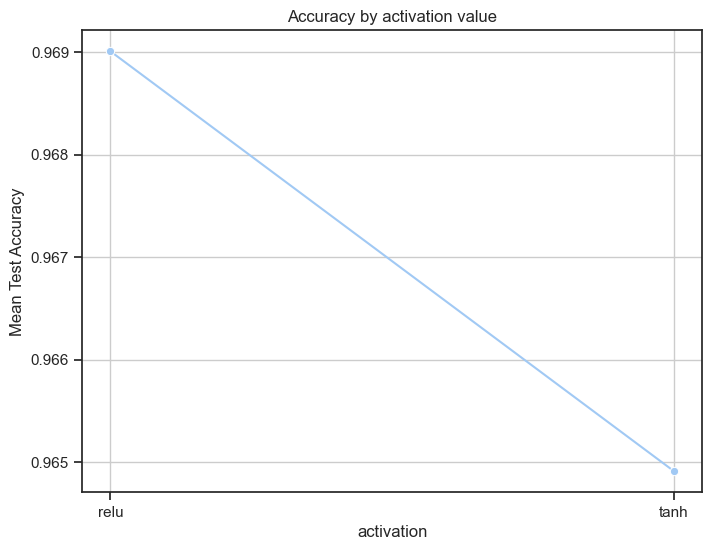

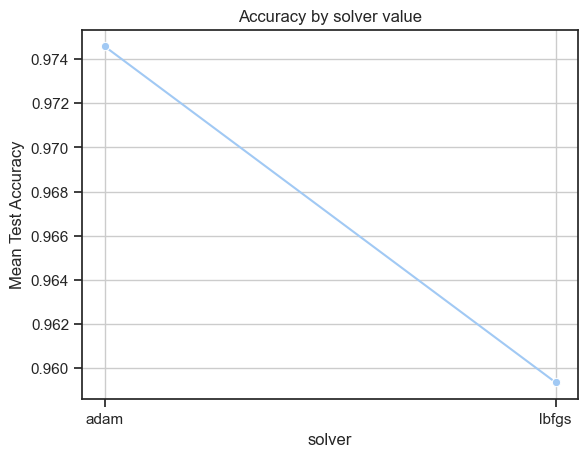

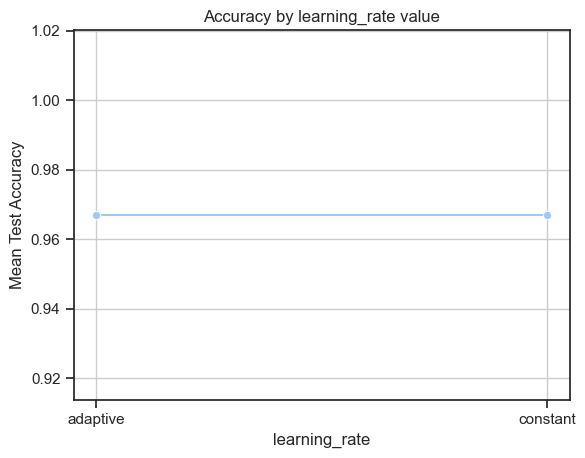

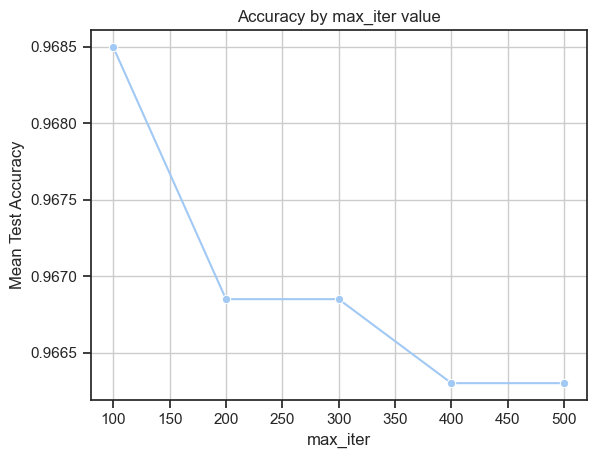

In [301]:
plt.figure(figsize=(8, 6))

for param in param_grid.keys():
    if param != 'hidden_layer_sizes':
        sns.lineplot(data=results.groupby('param_' + param, as_index=False).agg({'mean_test_score':'mean'}), 
                     x='param_' + param, y='mean_test_score', marker='o')
        plt.title('Accuracy by ' + param + ' value')
        plt.xlabel(param)
        plt.ylabel('Mean Test Accuracy')
        plt.grid(True)
        plt.show()

In [310]:
expanded_model = MLPClassifier(random_state=55, activation='tanh', solver='adam', learning_rate='constant', max_iter=200)

param_grid = {
    'hidden_layer_sizes': [
        (hidden_layer_size1),
        (hidden_layer_size2),
        (hidden_layer_size3),
        (hidden_layer_size4),
        (hidden_layer_size5),
        (hidden_layer_size6),
        (hidden_layer_size7),
        (hidden_layer_size8),
        (hidden_layer_size9),
    ],
}

grid_search = GridSearchCV(estimator=expanded_model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(expanded_X_train_scaled, expanded_y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(activation='tanh', random_state=55),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [64, 72, 96, 115, 144, 192, 240,
                                                480, 960]},
             scoring='accuracy')

In [311]:
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values('mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_fit_time', 'param_hidden_layer_sizes']]

mean_test_score  mean_fit_time  param_hidden_layer_sizes
8         0.980220       5.561481                       960
7         0.978022       3.599034                       480
3         0.975824       0.619337                       115
6         0.975824       1.737137                       240
5         0.973626       1.252502                       192
0         0.971429       0.328801                        64
2         0.971429       0.452307                        96
4         0.971429       0.879603                       144
1         0.969231       0.369803                        72

In [304]:
expanded_model = MLPClassifier(random_state=55, activation='tanh', solver='adam', learning_rate='constant', max_iter=200)

param_grid = {
    'hidden_layer_sizes': [
        (hidden_layer_size3, hidden_layer_size1),
        (hidden_layer_size4, hidden_layer_size2),
        (hidden_layer_size5, hidden_layer_size3),
        (hidden_layer_size6, hidden_layer_size4),
        (hidden_layer_size7, hidden_layer_size5),
        (hidden_layer_size8, hidden_layer_size7),
        (hidden_layer_size9, hidden_layer_size8),
    ],
}

grid_search = GridSearchCV(estimator=expanded_model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(expanded_X_train_scaled, expanded_y_train)

C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=5, estimator=MLPClassifier(activation='tanh', random_state=55),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(96, 64), (115, 72), (144, 96),
                                                (192, 115), (240, 144),
                                                (480, 240), (960, 480)]},
             scoring='accuracy')

In [305]:
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values('mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_fit_time', 'param_hidden_layer_sizes']]

mean_test_score  mean_fit_time param_hidden_layer_sizes
1         0.980220       1.094843                (115, 72)
0         0.978022       0.798940                 (96, 64)
4         0.978022       3.815675               (240, 144)
6         0.975824      18.807033               (960, 480)
3         0.973626       2.341645               (192, 115)
2         0.971429       1.473694                (144, 96)
5         0.971429      11.396347               (480, 240)

In [306]:
expanded_model = MLPClassifier(random_state=55, activation='tanh', solver='adam', learning_rate='constant', max_iter=200)

param_grid = {
    'hidden_layer_sizes': [
        (hidden_layer_size5, hidden_layer_size3, hidden_layer_size1),
        (hidden_layer_size6, hidden_layer_size4, hidden_layer_size2),
        (hidden_layer_size7, hidden_layer_size5, hidden_layer_size3),
        (hidden_layer_size7, hidden_layer_size6, hidden_layer_size4),
        (hidden_layer_size8, hidden_layer_size7, hidden_layer_size5),
        (hidden_layer_size9, hidden_layer_size8, hidden_layer_size7),
    ],
}

grid_search = GridSearchCV(estimator=expanded_model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(expanded_X_train_scaled, expanded_y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(activation='tanh', random_state=55),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(144, 96, 64), (192, 115, 72),
                                                (240, 144, 96), (240, 192, 115),
                                                (480, 240, 144),
                                                (960, 480, 240)]},
             scoring='accuracy')

In [307]:
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values('mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_fit_time', 'param_hidden_layer_sizes']]

mean_test_score  mean_fit_time param_hidden_layer_sizes
1         0.973626       2.184852           (192, 115, 72)
4         0.973626       7.197660          (480, 240, 144)
0         0.971429       1.599094            (144, 96, 64)
5         0.969231      13.173510          (960, 480, 240)
2         0.967033       3.050355           (240, 144, 96)
3         0.964835       4.458641          (240, 192, 115)

In [308]:
expanded_model = MLPClassifier(random_state=55, activation='tanh', solver='adam', learning_rate='constant', max_iter=200)

param_grid = {
    'hidden_layer_sizes': [
        (hidden_layer_size7, hidden_layer_size5, hidden_layer_size3, hidden_layer_size1),
        (hidden_layer_size8, hidden_layer_size6, hidden_layer_size4, hidden_layer_size2),
        (hidden_layer_size8, hidden_layer_size7, hidden_layer_size5, hidden_layer_size3),
        (hidden_layer_size9, hidden_layer_size7, hidden_layer_size6, hidden_layer_size4),
    ],
}

grid_search = GridSearchCV(estimator=expanded_model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(expanded_X_train_scaled, expanded_y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(activation='tanh', random_state=55),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(240, 144, 96, 64),
                                                (480, 192, 115, 72),
                                                (480, 240, 144, 96),
                                                (960, 240, 192, 115)]},
             scoring='accuracy')

In [309]:
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values('mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_fit_time', 'param_hidden_layer_sizes']]

mean_test_score  mean_fit_time param_hidden_layer_sizes
2         0.973626       7.286580      (480, 240, 144, 96)
0         0.969231       2.338164       (240, 144, 96, 64)
1         0.967033       5.712712      (480, 192, 115, 72)
3         0.947253      10.815384     (960, 240, 192, 115)

In [312]:
expanded_model = MLPClassifier(random_state=55, hidden_layer_sizes=(hidden_layer_size4, hidden_layer_size2), 
                             activation='tanh', solver='adam', learning_rate='constant', max_iter=200)
expanded_model.fit(expanded_X_train_scaled, expanded_y_train)

expanded_predictions = expanded_model.predict(expanded_X_train_scaled)
expanded_prediction_probs = expanded_model.predict_proba(expanded_X_train_scaled)

print(f'Accuracy: {accuracy_score(expanded_y_train, expanded_predictions, normalize=True, sample_weight=None)}')
print(f'Avg CV accuracy: {np.mean(cross_val_score(expanded_model, expanded_X_train_scaled, expanded_y_train, cv=5))}')

C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.989010989010989


C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Avg CV accuracy: 0.9802197802197803


C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


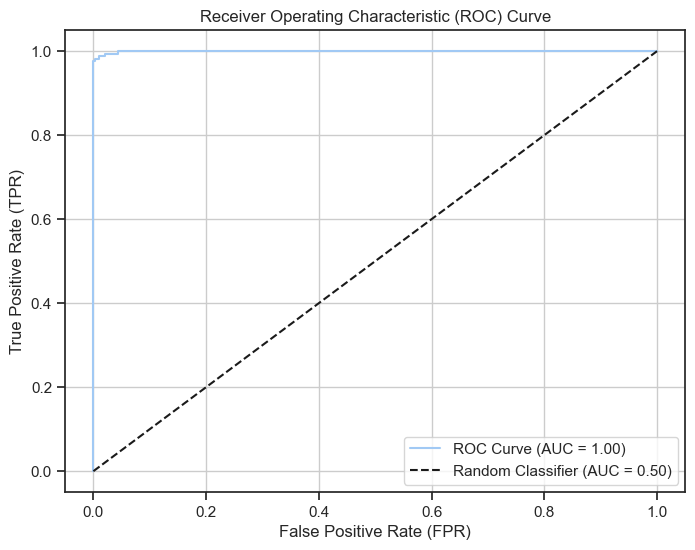

In [314]:
expanded_y_train_binary = [int(entry) for entry in np.where(expanded_y_train == 'M', 1, 0)]
expanded_prediction_probs_binary = [x[1] for x in expanded_prediction_probs]

fpr, tpr, thresholds = roc_curve(expanded_y_train_binary, expanded_prediction_probs_binary)

# 4. Calculate AUC Score
auc_score = roc_auc_score(expanded_y_train_binary, expanded_prediction_probs_binary)

# 5. Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

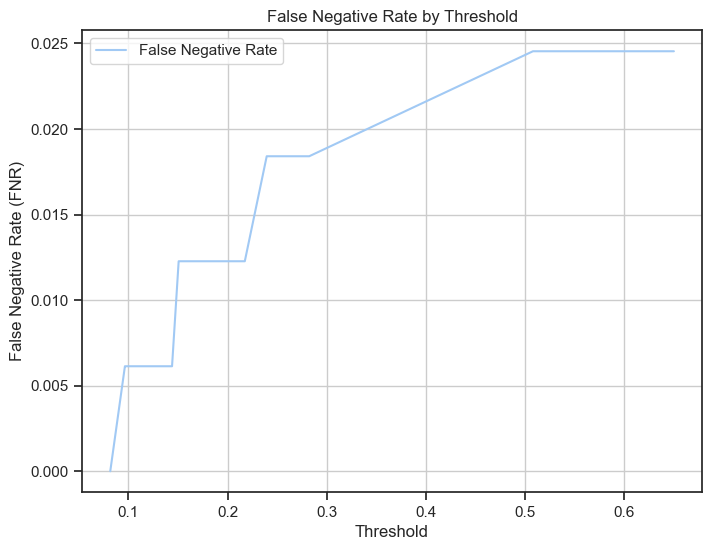

In [315]:
fpr, fnr, thresholds = det_curve(expanded_y_train_binary, expanded_prediction_probs_binary)
plt.figure(figsize=(8, 6))
plt.plot(thresholds, fnr, label='False Negative Rate')
plt.xlabel('Threshold')
plt.ylabel('False Negative Rate (FNR)')
plt.title('False Negative Rate by Threshold')
plt.grid(True)
plt.legend()
plt.show()

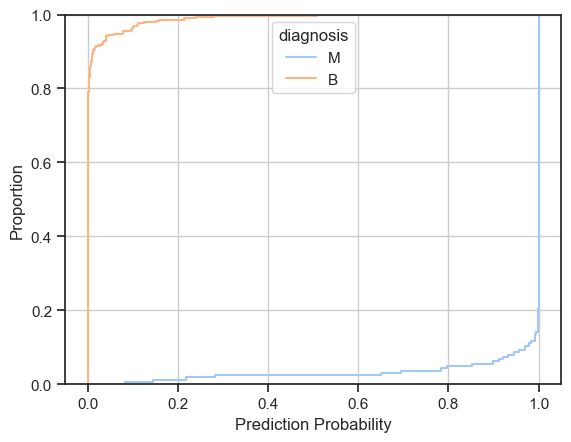

In [318]:
expanded_prediction_df = pd.DataFrame({'diagnosis': expanded_y_train, 
                                    'prediction' : expanded_predictions,
                                    'M_probability': [x[1] for x in expanded_prediction_probs],
                                    'prediction_probability': [np.max([x[0], x[1]]) for x in expanded_prediction_probs]})

sns.ecdfplot(data=expanded_prediction_df,
             x='M_probability', hue='diagnosis')
plt.xlabel('Prediction Probability')
plt.grid(True)
plt.show()

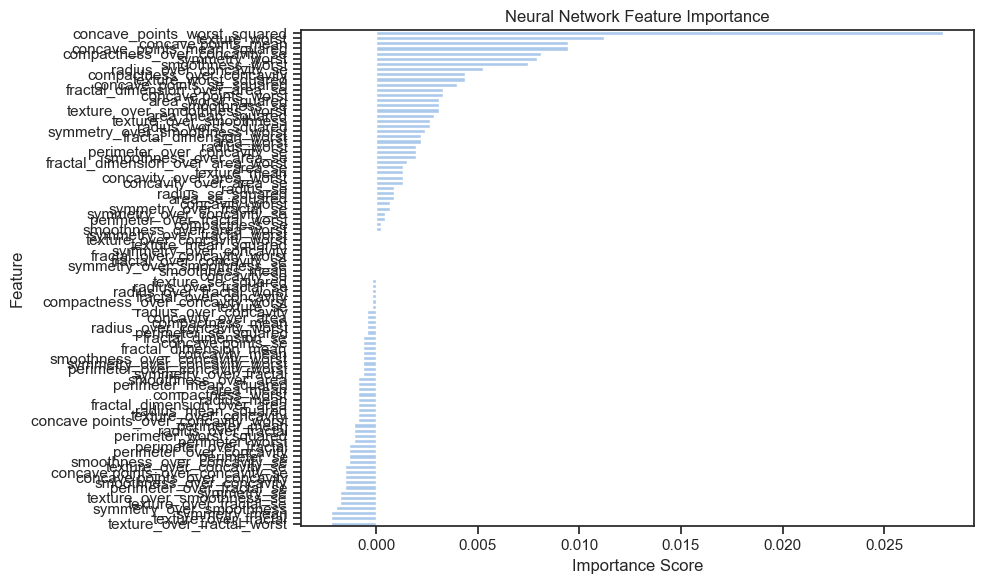

In [316]:
expanded_importances = permutation_importance(expanded_model, expanded_X_train_scaled, expanded_y_train, 
                                     n_repeats=10, random_state=55, scoring='accuracy')
expanded_feature_importance_df = pd.DataFrame({'feature': expanded_model_cols, 'importance': 
                                               expanded_importances.importances_mean})\
    .sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=expanded_feature_importance_df)
plt.title('Neural Network Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [319]:
expanded_iterate_model_cols = expanded_feature_importance_df[
    (expanded_feature_importance_df.importance > 0) & 
#     ~(new_feature_importance_df.feature.str.contains('perimeter_')) & 
#     ~(new_feature_importance_df.feature.str.contains('radius_')) &
    ~(expanded_feature_importance_df.feature.isna())
].feature

hidden_layer_size1 = round(len(expanded_model_cols)*2/3)
hidden_layer_size2 = round(len(expanded_model_cols)*3/4)
hidden_layer_size3 = round(len(expanded_model_cols))
hidden_layer_size4 = round(len(expanded_model_cols)*1.2)
hidden_layer_size5 = round(len(expanded_model_cols)*1.5)
hidden_layer_size6 = round(len(expanded_model_cols)*2)
hidden_layer_size7 = round(len(expanded_model_cols)*2.5)
hidden_layer_size8 = round(len(expanded_model_cols)*5)
hidden_layer_size9 = round(len(expanded_model_cols)*10)

expanded_iterate_X_train_scaled = scaler.fit_transform(expanded_X_train[expanded_iterate_model_cols])
expanded_iterate_model = MLPClassifier(random_state=55, hidden_layer_sizes=(hidden_layer_size4, hidden_layer_size2), 
                             activation='tanh', solver='adam', learning_rate='constant', max_iter=200)
expanded_iterate_model.fit(expanded_iterate_X_train_scaled, expanded_y_train)

expanded_iterate_predictions = expanded_iterate_model.predict(expanded_iterate_X_train_scaled)
expanded_iterate_prediction_probs = expanded_iterate_model.predict_proba(expanded_iterate_X_train_scaled)

print(f'Accuracy: {accuracy_score(expanded_y_train, expanded_iterate_predictions, normalize=True, sample_weight=None)}')
print(f'Avg CV accuracy: {np.mean(cross_val_score(expanded_iterate_model, expanded_iterate_X_train_scaled, expanded_y_train, cv=5))}')

Accuracy: 0.9912087912087912


C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Avg CV accuracy: 0.9758241758241759


C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


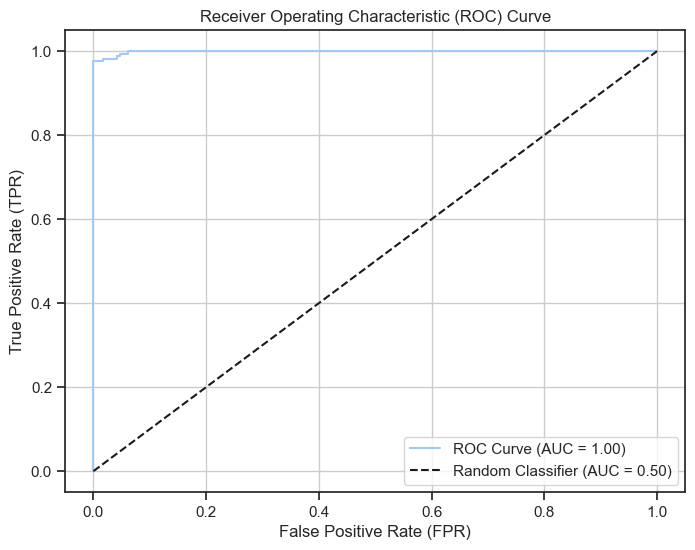

In [322]:
expanded_y_train_binary = [int(entry) for entry in np.where(expanded_y_train == 'M', 1, 0)]
expanded_iterate_prediction_probs_binary = [x[1] for x in expanded_iterate_prediction_probs]

fpr, tpr, thresholds = roc_curve(expanded_y_train_binary, expanded_iterate_prediction_probs_binary)

# 4. Calculate AUC Score
auc_score = roc_auc_score(expanded_y_train_binary, expanded_iterate_prediction_probs_binary)

# 5. Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

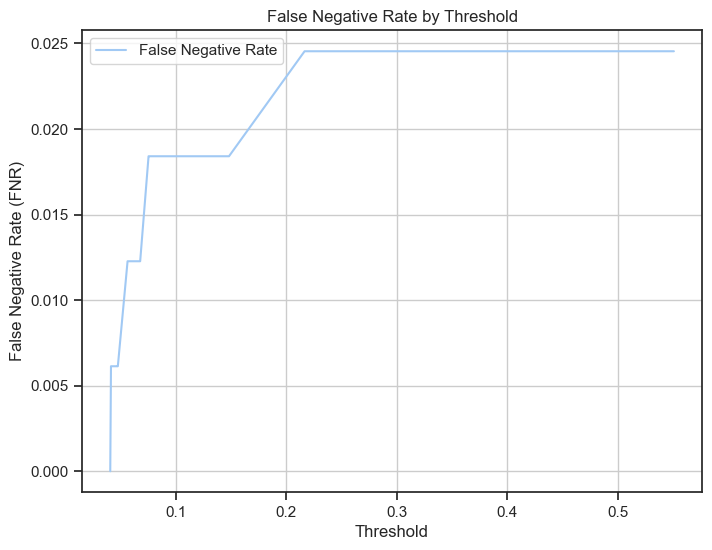

In [323]:
fpr, fnr, thresholds = det_curve(expanded_y_train_binary, expanded_iterate_prediction_probs_binary)
plt.figure(figsize=(8, 6))
plt.plot(thresholds, fnr, label='False Negative Rate')
plt.xlabel('Threshold')
plt.ylabel('False Negative Rate (FNR)')
plt.title('False Negative Rate by Threshold')
plt.grid(True)
plt.legend()
plt.show()

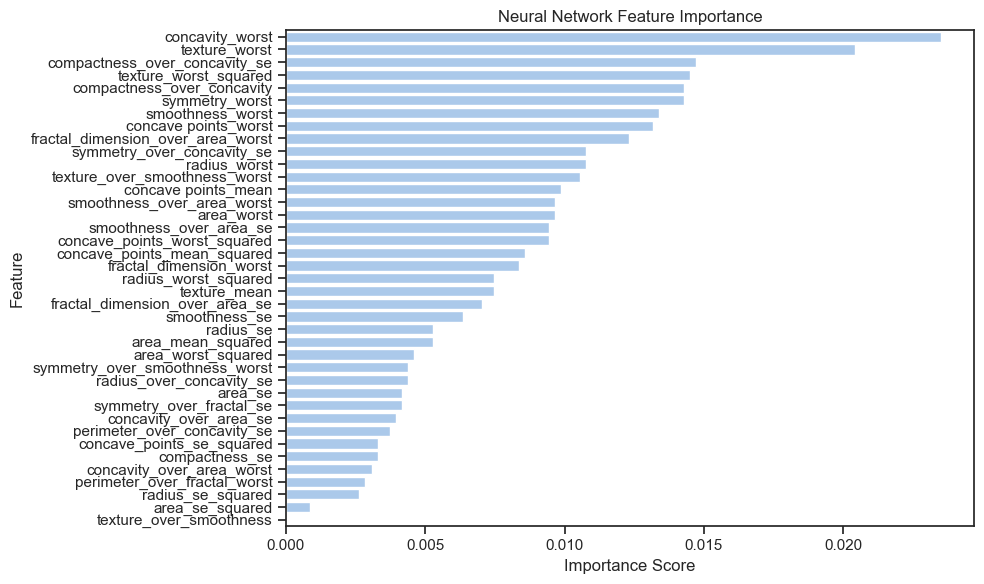

In [324]:
expanded_iterate_importances = permutation_importance(expanded_iterate_model, expanded_iterate_X_train_scaled, 
                                                      expanded_y_train, n_repeats=10, random_state=55, scoring='accuracy')
expanded_iterate_feature_importance_df = pd.DataFrame({'feature': expanded_iterate_model_cols, 
                                              'importance': expanded_iterate_importances.importances_mean})\
    .sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=expanded_iterate_feature_importance_df)
plt.title('Neural Network Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [325]:
expanded_model = MLPClassifier(random_state=55)

hidden_layer_size1 = round(len(expanded_model_cols)*2/3)
hidden_layer_size2 = round(len(expanded_model_cols)*3/4)
hidden_layer_size3 = round(len(expanded_model_cols))
hidden_layer_size4 = round(len(expanded_model_cols)*1.2)
hidden_layer_size5 = round(len(expanded_model_cols)*1.5)
hidden_layer_size6 = round(len(expanded_model_cols)*2)
hidden_layer_size7 = round(len(expanded_model_cols)*2.5)
hidden_layer_size8 = round(len(expanded_model_cols)*5)
hidden_layer_size9 = round(len(expanded_model_cols)*10)

param_grid = {
    'activation': ['relu', 'tanh'],
    'hidden_layer_sizes': [
        (hidden_layer_size8, hidden_layer_size6),
        (hidden_layer_size6, hidden_layer_size4),
        (hidden_layer_size4, hidden_layer_size2)
    ],
    'solver': ['adam', 'lbfgs'],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [100, 200, 300, 400, 500,]
}

grid_search = GridSearchCV(estimator=expanded_model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(expanded_iterate_X_train_scaled, expanded_y_train)

C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=5, estimator=MLPClassifier(random_state=55), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'hidden_layer_sizes': [(480, 192), (192, 115),
                                                (115, 72)],
                         'learning_rate': ['constant', 'adaptive'],
                         'max_iter': [100, 200, 300, 400, 500],
                         'solver': ['adam', 'lbfgs']},
             scoring='accuracy')

In [328]:
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values('mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_fit_time', 'param_activation', 'param_hidden_layer_sizes',
    'param_solver', 'param_learning_rate', 'param_max_iter']]

mean_test_score  mean_fit_time param_activation param_hidden_layer_sizes  \
40          0.980220       0.457662             relu                (115, 72)   
42          0.980220       0.804062             relu                (115, 72)   
52          0.980220       0.726866             relu                (115, 72)   
50          0.980220       0.343772             relu                (115, 72)   
0           0.978022       3.875055             relu               (480, 192)   
10          0.978022       3.694569             relu               (480, 192)   
46          0.978022       1.294054             relu                (115, 72)   
44          0.978022       1.080857             relu                (115, 72)   
48          0.978022       1.347468             relu                (115, 72)   
54          0.978022       1.129545             relu                (115, 72)   
94          0.978022       2.507375             tanh               (192, 115)   
96          0.978022       2.466201             tanh               (192, 115)   
98          0.978022       2.346454             tanh               (192, 115)   
100         0.978022       0.519393             tanh                (115, 72)   
110         0.978022       0.420035             tanh                (115, 72)   
104         0.978022       1.258593             tanh                (115, 72)   
114         0.978022       1.222265             tanh                (115, 72)   
84          0.978022       2.454925             tanh               (192, 115)   
82          0.978022       2.039602             tanh               (192, 115)   
86          0.978022       2.356453             tanh               (192, 115)   
70          0.978022       4.037966             tanh               (480, 192)   
60          0.978022       4.007185             tanh               (480, 192)   
58          0.978022       1.538386             relu                (115, 72)   
56          0.978022       1.303486             relu                (115, 72)   
88          0.978022       2.562007             tanh               (192, 115)   
92          0.978022       2.222782             tanh               (192, 115)   
6           0.975824       9.605299             relu               (480, 192)   
4           0.975824       9.500370             relu               (480, 192)   
16          0.975824       9.709030             relu               (480, 192)   
34          0.975824       2.694597             relu               (192, 115)   
32          0.975824       1.798533             relu               (192, 115)   
24          0.975824       2.673826             relu               (192, 115)   
22          0.975824       1.994166             relu               (192, 115)   
14          0.975824       9.316862             relu               (480, 192)   
8           0.975824       9.634662             relu               (480, 192)   
18          0.975824       8.679129             relu               (480, 192)   
102         0.975824       0.865352             tanh                (115, 72)   
106         0.975824       1.565747             tanh                (115, 72)   
116         0.975824       1.521274             tanh                (115, 72)   
112         0.975824       0.863437             tanh                (115, 72)   
30          0.975824       0.889436             relu               (192, 115)   
20          0.975824       1.084594             relu               (192, 115)   
28          0.973626       3.122523             relu               (192, 115)   
26          0.973626       3.237661             relu               (192, 115)   
36          0.973626       3.194951             relu               (192, 115)   
38          0.973626       3.340300             relu               (192, 115)   
2           0.973626       7.501522             relu               (480, 192)   
12          0.973626       7.311171             relu               (480, 192)   
108         0.973626       1.706805 

In [326]:
results.groupby('param_hidden_layer_sizes').agg({'mean_test_score': 'mean', 'mean_fit_time': 'mean'})

mean_test_score  mean_fit_time
param_hidden_layer_sizes                                
(115, 72)                        0.966264       0.686066
(192, 115)                       0.968791       1.520610
(480, 192)                       0.964505       5.209239

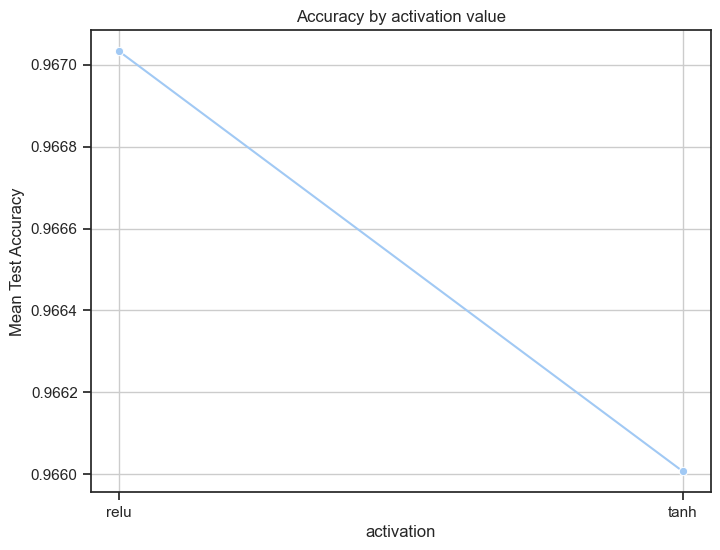

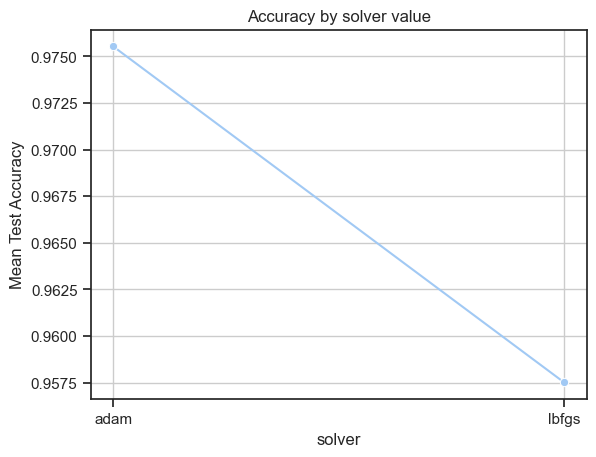

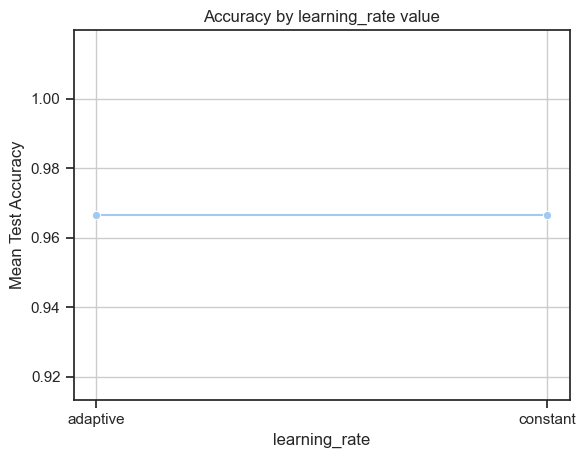

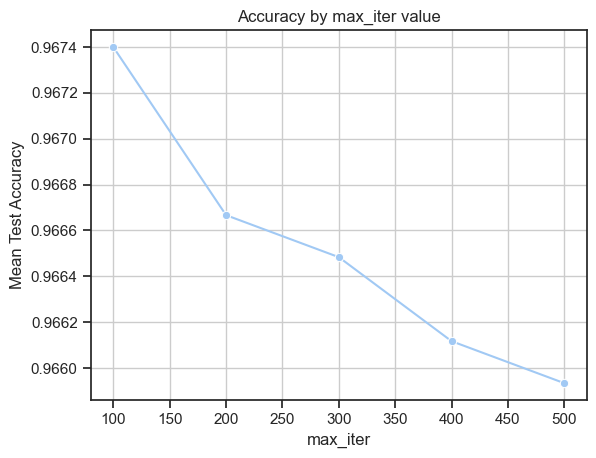

In [327]:
plt.figure(figsize=(8, 6))

for param in param_grid.keys():
    if param != 'hidden_layer_sizes':
        sns.lineplot(data=results.groupby('param_' + param, as_index=False).agg({'mean_test_score':'mean'}), 
                     x='param_' + param, y='mean_test_score', marker='o')
        plt.title('Accuracy by ' + param + ' value')
        plt.xlabel(param)
        plt.ylabel('Mean Test Accuracy')
        plt.grid(True)
        plt.show()

In [329]:
expanded_model = MLPClassifier(random_state=55, activation='relu', solver='adam', learning_rate='constant', max_iter=100)

param_grid = {
    'hidden_layer_sizes': [
        (hidden_layer_size1),
        (hidden_layer_size2),
        (hidden_layer_size3),
        (hidden_layer_size4),
        (hidden_layer_size5),
        (hidden_layer_size6),
        (hidden_layer_size7),
        (hidden_layer_size8),
        (hidden_layer_size9),
    ],
}

grid_search = GridSearchCV(estimator=expanded_model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(expanded_iterate_X_train_scaled, expanded_y_train)

C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=100, random_state=55),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [64, 72, 96, 115, 144, 192, 240,
                                                480, 960]},
             scoring='accuracy')

In [330]:
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values('mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_fit_time', 'param_hidden_layer_sizes']]

mean_test_score  mean_fit_time  param_hidden_layer_sizes
7         0.978022       0.880997                       480
6         0.978022       0.385956                       240
8         0.978022       1.613584                       960
3         0.973626       0.165268                       115
4         0.973626       0.198759                       144
5         0.971429       0.278603                       192
2         0.969231       0.130875                        96
0         0.958242       0.110331                        64
1         0.956044       0.118316                        72

In [ ]:
expanded_model = MLPClassifier(random_state=55, activation='relu', solver='adam', learning_rate='constant', max_iter=100)

param_grid = {
    'hidden_layer_sizes': [
        (hidden_layer_size3, hidden_layer_size1),
        (hidden_layer_size4, hidden_layer_size2),
        (hidden_layer_size5, hidden_layer_size3),
        (hidden_layer_size6, hidden_layer_size4),
        (hidden_layer_size7, hidden_layer_size5),
        (hidden_layer_size8, hidden_layer_size7),
        (hidden_layer_size9, hidden_layer_size8),
    ],
}

grid_search = GridSearchCV(estimator=expanded_model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(expanded_iterate_X_train_scaled, expanded_y_train)

In [333]:
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values('mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_fit_time', 'param_hidden_layer_sizes']]

C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


mean_test_score  mean_fit_time param_hidden_layer_sizes
2         0.984615       0.606992                (144, 96)
0         0.980220       0.345004                 (96, 64)
1         0.980220       0.413618                (115, 72)
4         0.980220       1.555262               (240, 144)
6         0.978022      14.592704               (960, 480)
3         0.975824       0.929313               (192, 115)
5         0.973626       4.978079               (480, 240)

In [334]:
expanded_model = MLPClassifier(random_state=55, activation='relu', solver='adam', learning_rate='constant', max_iter=100)

param_grid = {
    'hidden_layer_sizes': [
        (hidden_layer_size5, hidden_layer_size3, hidden_layer_size1),
        (hidden_layer_size6, hidden_layer_size4, hidden_layer_size2),
        (hidden_layer_size7, hidden_layer_size5, hidden_layer_size3),
        (hidden_layer_size7, hidden_layer_size6, hidden_layer_size4),
        (hidden_layer_size8, hidden_layer_size7, hidden_layer_size5),
        (hidden_layer_size9, hidden_layer_size8, hidden_layer_size7),
    ],
}

grid_search = GridSearchCV(estimator=expanded_model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(expanded_iterate_X_train_scaled, expanded_y_train)

C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=100, random_state=55),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(144, 96, 64), (192, 115, 72),
                                                (240, 144, 96), (240, 192, 115),
                                                (480, 240, 144),
                                                (960, 480, 240)]},
             scoring='accuracy')

In [335]:
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values('mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_fit_time', 'param_hidden_layer_sizes']]

mean_test_score  mean_fit_time param_hidden_layer_sizes
1         0.980220       1.184277           (192, 115, 72)
0         0.978022       0.775481            (144, 96, 64)
4         0.978022       5.861521          (480, 240, 144)
2         0.975824       1.838456           (240, 144, 96)
3         0.975824       2.924692          (240, 192, 115)
5         0.973626      15.702120          (960, 480, 240)

In [336]:
expanded_model = MLPClassifier(random_state=55, activation='relu', solver='adam', learning_rate='constant', max_iter=100)

param_grid = {
    'hidden_layer_sizes': [
        (hidden_layer_size7, hidden_layer_size5, hidden_layer_size3, hidden_layer_size1),
        (hidden_layer_size8, hidden_layer_size6, hidden_layer_size4, hidden_layer_size2),
        (hidden_layer_size8, hidden_layer_size7, hidden_layer_size5, hidden_layer_size3),
        (hidden_layer_size9, hidden_layer_size7, hidden_layer_size6, hidden_layer_size4),
    ],
}

grid_search = GridSearchCV(estimator=expanded_model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(expanded_iterate_X_train_scaled, expanded_y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=100, random_state=55),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(240, 144, 96, 64),
                                                (480, 192, 115, 72),
                                                (480, 240, 144, 96),
                                                (960, 240, 192, 115)]},
             scoring='accuracy')

In [337]:
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values('mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_fit_time', 'param_hidden_layer_sizes']]

mean_test_score  mean_fit_time param_hidden_layer_sizes
2         0.978022       6.277609      (480, 240, 144, 96)
1         0.975824       4.847042      (480, 192, 115, 72)
3         0.975824       9.197446     (960, 240, 192, 115)
0         0.973626       2.024191       (240, 144, 96, 64)

In [343]:
final_expanded_model = MLPClassifier(random_state=55, hidden_layer_sizes=(hidden_layer_size5, hidden_layer_size3), 
                             activation='relu', solver='adam', learning_rate='constant', max_iter=100)
final_expanded_model.fit(expanded_iterate_X_train_scaled, expanded_y_train)

final_expanded_predictions = final_expanded_model.predict(expanded_iterate_X_train_scaled)
final_expanded_prediction_probs = final_expanded_model.predict_proba(expanded_iterate_X_train_scaled)

print(f'Accuracy: {accuracy_score(expanded_y_train, final_expanded_predictions, normalize=True, sample_weight=None)}')
print(f'Avg CV accuracy: {np.mean(cross_val_score(final_expanded_model, expanded_iterate_X_train_scaled, expanded_y_train, cv=5))}')

C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.989010989010989


C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Avg CV accuracy: 0.9846153846153847


C:\Users\kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


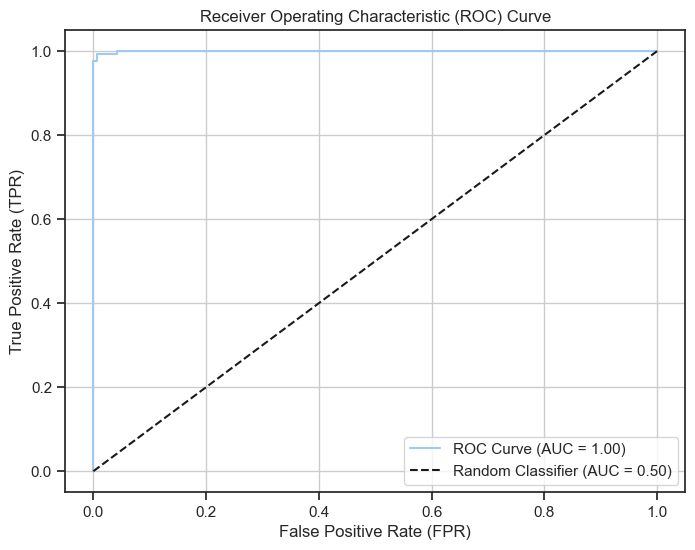

In [344]:
expanded_y_train_binary = [int(entry) for entry in np.where(expanded_y_train == 'M', 1, 0)]
final_expanded_prediction_probs_binary = [x[1] for x in final_expanded_prediction_probs]

fpr, tpr, thresholds = roc_curve(expanded_y_train_binary, final_expanded_prediction_probs_binary)

# 4. Calculate AUC Score
auc_score = roc_auc_score(expanded_y_train_binary, final_expanded_prediction_probs_binary)

# 5. Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

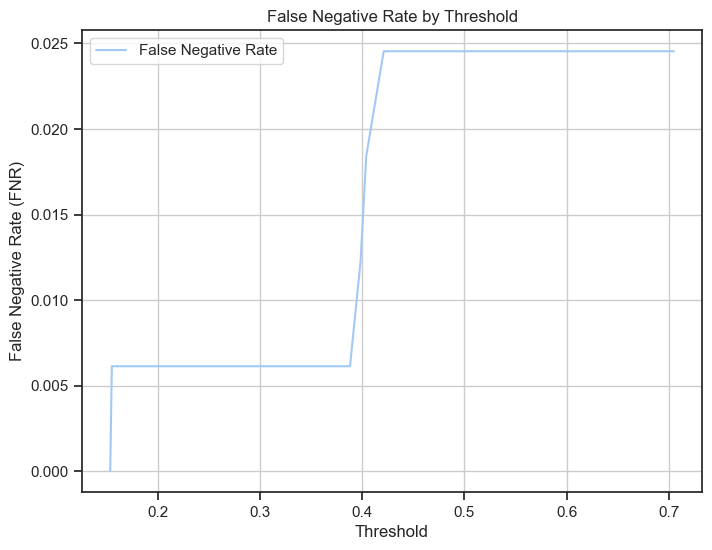

In [345]:
fpr, fnr, thresholds = det_curve(expanded_y_train_binary, final_expanded_prediction_probs_binary)
plt.figure(figsize=(8, 6))
plt.plot(thresholds, fnr, label='False Negative Rate')
plt.xlabel('Threshold')
plt.ylabel('False Negative Rate (FNR)')
plt.title('False Negative Rate by Threshold')
plt.grid(True)
plt.legend()
plt.show()

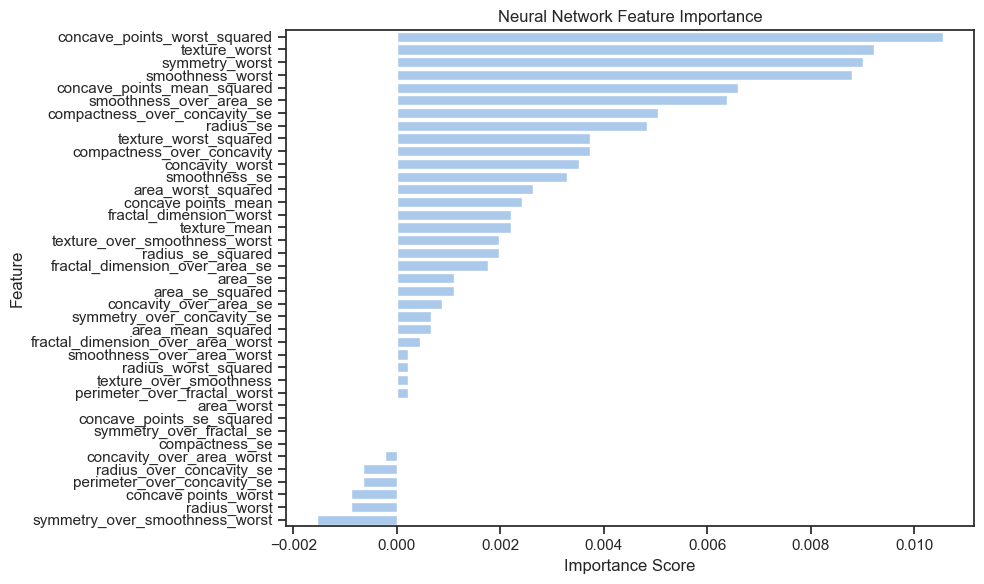

In [348]:
final_expanded_importances = permutation_importance(final_expanded_model, expanded_iterate_X_train_scaled, 
                                                      expanded_y_train, n_repeats=10, random_state=55, scoring='accuracy')
final_expanded_feature_importance_df = pd.DataFrame({'feature': expanded_iterate_model_cols, 
                                              'importance': final_expanded_importances.importances_mean})\
    .sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=final_expanded_feature_importance_df)
plt.title('Neural Network Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

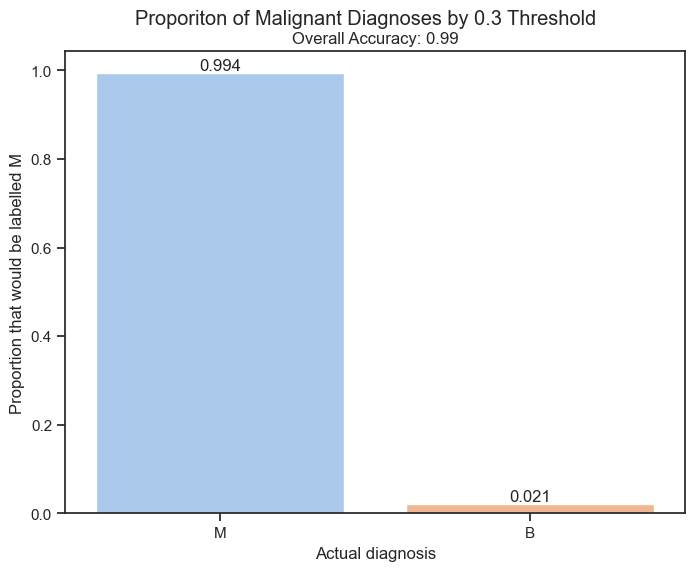

In [355]:
expanded_iterate_X_test_scaled = scaler.transform(expanded_X_test[expanded_iterate_model_cols])

final_expanded_test_predictions = final_expanded_model.predict(expanded_iterate_X_test_scaled)
final_expanded_test_prediction_probs = final_expanded_model.predict_proba(expanded_iterate_X_test_scaled)

final_expanded_test_prediction_df = pd.DataFrame({'diagnosis': expanded_y_test, 
                                    'prediction' : final_expanded_test_predictions,
                                    'M_probability': [x[1] for x in final_expanded_test_prediction_probs],
                                    'prediction_probability': [np.max([x[0], x[1]]) for x in final_expanded_test_prediction_probs],
                                    'is_above_30_percent': [x[1] > 0.2 for x in final_expanded_test_prediction_probs]})

fig, ax = plt.subplots(figsize=(8, 6))
bars = sns.barplot(data=final_expanded_test_prediction_df, x='diagnosis', 
                   y='is_above_30_percent', hue='diagnosis', ax=ax, errorbar=None)
ax.bar_label(bars.containers[0], fmt='%.3f') # fmt can format the number, e.g., '%.2f' for two decimal places
ax.bar_label(bars.containers[1], fmt='%.3f') # fmt can format the number, e.g., '%.2f' for two decimal places
plt.xlabel('Actual diagnosis')
plt.ylabel('Proportion that would be labelled M')
plt.suptitle('Proporiton of Malignant Diagnoses by 0.3 Threshold', y=0.95)
plt.title(f'Overall Accuracy: \
{round(accuracy_score(expanded_y_test, final_expanded_test_predictions, normalize=True, sample_weight=None), 2)}')
plt.show()

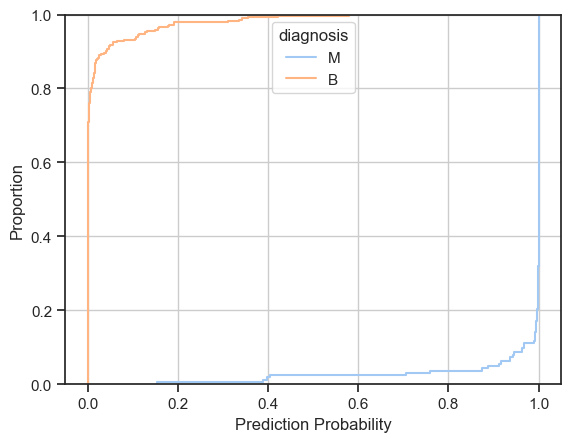

In [356]:
sns.ecdfplot(data=final_expanded_test_prediction_df,
             x='M_probability', hue='diagnosis')
plt.xlabel('Prediction Probability')
plt.grid(True)
plt.show()